# ISO-DEM : ISOPARAMETRIC DOMAIN DEEP ENERGY METHOD

In [1]:
# Link to install debugger in jupyterlab
# First, we have to upgrade jupyterlab to 2.0 version & install nodejs and npm by
# 1. conda update -c conda-forge jupyterlab
# 2. pip install npm
# 3. conda install nodejs
# Second, we have to install debugger extension for notebooklab (https://blog.jupyter.org/a-visual-debugger-for-jupyter-914e61716559)
# Front-end tool:
# jupyter labextension install @jupyterlab/debugger
# Back-end tool:
# conda install xeus-python -c conda-forge
# Please, change the kernel to XPython before using and restart everything.
# If everything does not work, please read the article below for fixing issues
# https://stackoverflow.com/questions/61888748/extension-installation-error-please-install-nodejs-5-and-npm-before-continuing

In [2]:
"""
@author: sfmt4368, texa5140, minh.nguyen@ikm.uni-hannover.de
Implements strain gradient elasticity
"""

from torch.autograd import grad
import numpy as np
import numpy.random as npr
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from mpl_toolkits.mplot3d import Axes3D
from pyevtk.hl import gridToVTK
import time
import torch
import math
from geomdl import NURBS
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
import scipy.special as sp
from numpy import sqrt
import sys
mpl.rcParams['figure.dpi'] = 250
axes = {'labelsize': 'large'}
font = {'family': 'serif',
        'weight': 'normal',
        'size': 5}
legend = {'fontsize': 'medium'}
lines = {'linewidth': 3,
         'markersize': 7}

mpl.rc('font', **font)
mpl.rc('axes', **axes)
mpl.rc('legend', **legend)
mpl.rc('lines', **lines)

dev = torch.device('cpu')
npr.seed(2019)
torch.manual_seed(2019)

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

if torch.cuda.is_available():
    print("CUDA is available, running on GPU")
    dev = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    print("CUDA not available, running on CPU")
    
path_save_pic = "./output/annulus2d/" # remember you have to end with /

CUDA is available, running on GPU


# <u>Example 2</u>: Thick-wall cylinder

## Exact solution

In [3]:
def u_exact_cylinder(P, E, nu, ro, ri, r):
    return (ri **2 * P * r) / (E * (ro**2 - ri**2)) * (1 - nu + (ro/r)**2 * (1 + nu))

def cart2pol(x, y):
    rho = np.sqrt(np.array(x)**2 + np.array(y)**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def sigma_exact_cylinder(x, y, model):
    sigma_xx = np.zeros_like(x)
    sigma_yy = np.zeros_like(x)
    sigma_xy = np.zeros_like(x)
    numPts = len(x)
    for i in range(numPts):
        r, th = cart2pol(x[i],y[i])
        sigma_rr = model['radInt']**2 * model['Pi'] / (model['radExt']**2 - model['radInt']**2) * (1 - model['radExt']**2 / r**2)[0]
        sigma_tt = model['radInt']**2 * model['Pi'] / (model['radExt']**2 - model['radInt']**2) * (1 + model['radExt']**2 / r**2)[0]
        sigma_rt = 0

        A = np.array([[np.cos(th)**2, np.sin(th)**2, 2*np.sin(th)*np.cos(th)],
                       [np.sin(th)**2, np.cos(th)**2, -2*np.sin(th)*np.cos(th)],
                       [-np.sin(th)*np.cos(th), np.sin(th)*np.cos(th), np.cos(th)**2-np.sin(th)**2]])
        A = np.reshape(A, (3,3))
#         print(A.shape)
#         print(sigma_rr)
#         print(sigma_tt)
#         print(sigma_rt)
        stress_vec = np.linalg.solve(A, np.array([sigma_rr, sigma_tt, sigma_rt]))
        sigma_xx[i] = stress_vec[0]
        sigma_yy[i] = stress_vec[1]
        sigma_xy[i] = stress_vec[2]
    return np.concatenate((sigma_xx, sigma_yy, sigma_xy), axis=1)

def Moduli(mu, lmbda):
    # Plane stress
    return 2*mu / (2*mu + lmbda) * np.array([[2*(mu+lmbda), lmbda, 0],
                                    [lmbda, 2*(mu+lmbda), 0],
                                    [0, 0, (2*mu + lmbda)/2]])

def eps_exact_cylinder(mu, lmbda, stress):
    eps = np.zeros_like(stress)
    C = Moduli(mu, lmbda)
    for i, e in enumerate(stress):
        sigma = np.expand_dims(e, axis=1)
        r = np.matmul(np.linalg.inv(C), sigma)
        eps[i, : ] = np.reshape(r, (1, 3))
    return eps

### Step 1: GEOMETRY ISODEM

In [4]:
class GeometryISO2D:
    '''
     Base class for 2D domains
     Input: geomData - dictionary containing the geomety information
     Keys: degree_u, degree_v: polynomial degree in the u and v directions
       ctrlpts_size_u, ctrlpts_size_v: number of control points in u,v directions
       ctrlpts: weighted control points (in a list with
            ctrlpts_size_u*ctrlpts_size_v rows and 3 columns for x,y,z coordinates)
       weights: correspond weights (list with ctrlpts_size_u*ctrlpts_size_v entries)
       knotvector_u, knotvector_v: knot vectors in the u and v directions
    '''

    def __init__(self, geomData):
        self.surf = NURBS.Surface()
        self.surf.degree_u = geomData['degree_u']
        self.surf.degree_v = geomData['degree_v']
        self.surf.ctrlpts_size_u = geomData['ctrlpts_size_u']
        self.surf.ctrlpts_size_v = geomData['ctrlpts_size_v']
        self.surf.ctrlpts = self.getUnweightedCpts(geomData['ctrlpts'],
                                                   geomData['weights'])
        self.surf.weights = geomData['weights']
        self.surf.knotvector_u = geomData['knotvector_u']
        self.surf.knotvector_v = geomData['knotvector_v']
        
    def getUnweightedCpts(self, ctrlpts, weights):
        numCtrlPts = np.shape(ctrlpts)[0]
        PctrlPts = np.zeros_like(ctrlpts)
        for i in range(3):
            for j in range(numCtrlPts):
                PctrlPts[j, i] = ctrlpts[j][i] / weights[j]
        PctrlPts = PctrlPts.tolist()
        return PctrlPts

    def mapPoints(self, uPar, vPar):
        '''
        Map points from the parameter domain [0,1]x[0,1] to the quadrilater domain
        Input:  uPar - array containing the u-coordinates in the parameter space
                vPar - array containing the v-coordinates in the parameter space
                Note: the arrays uPar and vPar must be of the same size
        Output: xPhys - array containing the x-coordinates in the physical space
                yPhys - array containing the y-coordinates in the physical space
        '''
        gpParamUV = np.array([uPar, vPar])
        evalList = tuple(map(tuple, gpParamUV.transpose()))
        res = np.array(self.surf.evaluate_list(evalList))

        return res

    def getUnifIntPts(self, numPtsU, numPtsV, withEdges):
        '''
        Generate uniformly spaced points inside the domain
        Input: numPtsU, numPtsV - number of points (including edges) in the u and v
                   directions in the parameter space
               withEdges - 1x4 array of zeros or ones specifying whether the boundary points
                           should be included. The boundary order is [bottom, right,
                           top, left] for the unit square.
        Output: xM, yM - flattened array containing the x and y coordinates of the points
        '''
        # generate points in the x direction on the interval [0,1]
        uEdge = np.linspace(0, 1, numPtsU)
        vEdge = np.linspace(0, 1, numPtsV)

        # remove endpoints depending on values of withEdges
        if withEdges[0] == 0:
            vEdge = vEdge[1:]
        if withEdges[1] == 0:
            uEdge = uEdge[:-1]
        if withEdges[2] == 0:
            vEdge = vEdge[:-1]
        if withEdges[3] == 0:
            uEdge = uEdge[1:]

        # create meshgrid
        uPar, vPar = np.meshgrid(uEdge, vEdge)

        uPar = uPar.flatten()
        vPar = vPar.flatten()
        # map points
        res = self.mapPoints(uPar.T, vPar.T)

        xPhys = res[:, 0:1]
        yPhys = res[:, 1:2]

        return xPhys, yPhys

    def getQuadIntPts(self, numElemU, numElemV, numGauss):
        '''
        Generate quadrature points inside the domain
        Input: numElemU, numElemV - number of subdivisions in the u and v
                   directions in the parameter space
               numGauss - number of Gauss quadrature points for each subdivision
        Output: xPhys, yPhys, wgtPhy - arrays containing the x and y coordinates
                                    of the points and the corresponding weights
        '''
        # allocate quadPts array
        quadPts = np.zeros((numElemU * numElemV * numGauss ** 2, 3))
        dxidx = np.zeros((numElemU * numElemV * numGauss ** 2, 4))
        # get the Gauss points on the reference interval [-1,1]
        gp, gw = np.polynomial.legendre.leggauss(numGauss)

        # get the Gauss weights on the reference element [-1, 1]x[-1,1]
        gpWeightU, gpWeightV = np.meshgrid(gw, gw)
        gpWeightUV = np.array(gpWeightU.flatten() * gpWeightV.flatten())

        # generate the knots on the interval [0,1]
        uEdge = np.linspace(0, 1, numElemU + 1)
        vEdge = np.linspace(0, 1, numElemV + 1)

        # create meshgrid
        uPar, vPar = np.meshgrid(uEdge, vEdge)
        gpUV = np.empty((0, 2), float)
        # generate points for each element
        indexPt = 0
        for iV in range(numElemV):
            for iU in range(numElemU):
                uMin = uPar[iV, iU]
                uMax = uPar[iV, iU + 1]
                vMin = vPar[iV, iU]
                vMax = vPar[iV + 1, iU]
                gpParamU = (uMax - uMin) / 2 * gp + (uMax + uMin) / 2
                gpParamV = (vMax - vMin) / 2 * gp + (vMax + vMin) / 2
                gpUV = np.append(gpUV, np.array([gpParamU, gpParamV]).T, axis=0)
                gpParamUg, gpParamVg = np.meshgrid(gpParamU, gpParamV)
                gpParamUV = np.array([gpParamUg.flatten(), gpParamVg.flatten()])
                # Jacobian of the transformation from the reference element [-1,1]x[-1,1]
                scaleFac = (uMax - uMin) * (vMax - vMin) / 4

                # map the points to the physical space
                for iPt in range(numGauss ** 2):
                    curPtU = gpParamUV[0, iPt]
                    curPtV = gpParamUV[1, iPt]
                    derivMat = self.surf.derivatives(curPtU, curPtV, order=1)
                    physPtX = derivMat[0][0][0]
                    physPtY = derivMat[0][0][1]
                    derivU = derivMat[1][0][0:2]
                    derivV = derivMat[0][1][0:2]
                    JacobMat = np.array([derivU, derivV])
                    detJac = np.linalg.det(JacobMat)
                    quadPts[indexPt, 0] = physPtX
                    quadPts[indexPt, 1] = physPtY
                    quadPts[indexPt, 2] = scaleFac * detJac * gpWeightUV[iPt]
                    # dxi1/dx = 1/detJac * dy/dxi2
                    dxidx[indexPt, 0] =  1 / detJac * derivV[1]
                    # dxi1/dx = 1/detJac * -dy/dxi1
                    dxidx[indexPt, 1] = -1 / detJac * derivU[1]
                    # dxi1/dx = 1/detJac * -dx/dxi2
                    dxidx[indexPt, 2] = -1 / detJac * derivV[0]
                    # dxi1/dx = 1/detJac * dx/dxi1
                    dxidx[indexPt, 3] =  1 / detJac * derivU[0]
                    indexPt = indexPt + 1

        xPhys = quadPts[:, 0:1]
        yPhys = quadPts[:, 1:2]
        wgtPhys = quadPts[:, 2:3]

        return xPhys, yPhys, wgtPhys , gpUV, dxidx

    def getUnweightedCpts2d(self, ctrlpts2d, weights):
        numCtrlPtsU = np.shape(ctrlpts2d)[0]
        numCtrlPtsV = np.shape(ctrlpts2d)[1]
        PctrlPts = np.zeros([numCtrlPtsU, numCtrlPtsV, 3])
        counter = 0
        for j in range(numCtrlPtsU):
            for k in range(numCtrlPtsV):
                for i in range(3):
                    PctrlPts[j, k, i] = ctrlpts2d[j][k][i] / weights[counter]
                counter = counter + 1
        PctrlPts = PctrlPts.tolist()
        return PctrlPts

    def plotSurf(self):
        # plots the NURBS/B-Spline surface and the control points in 2D
        fig, ax = plt.subplots()
        patches = []
        # get the number of points in the u and v directions
        numPtsU = np.int(1 / self.surf.delta[0])
        numPtsV = np.int(1 / self.surf.delta[1])

        for j in range(numPtsV):
            for i in range(numPtsU):
                # get the index of point in the lower left corner of the visualization element
                indexPtSW = j * (numPtsU + 1) + i
                indexPtSE = indexPtSW + 1
                indexPtNE = indexPtSW + numPtsU + 2
                indexPtNW = indexPtSW + numPtsU + 1
                XYPts = np.array(self.surf.evalpts)[[indexPtSW, indexPtSE,
                                                     indexPtNE, indexPtNW], 0:2]
                poly = mpatches.Polygon(XYPts)
                patches.append(poly)

        collection = PatchCollection(patches, color="lightgreen", cmap=plt.cm.hsv, alpha=1)
        ax.add_collection(collection)

        numCtrlPtsU = self.surf._control_points_size[0]
        numCtrlPtsV = self.surf._control_points_size[1]
        ctrlpts = self.getUnweightedCpts2d(self.surf.ctrlpts2d, self.surf.weights)
        # plot the horizontal lines
        for j in range(numCtrlPtsU):
            plt.plot(np.array(ctrlpts)[j, :, 0], np.array(ctrlpts)[j, :, 1], ls='--', color='black')
        # plot the vertical lines
        for i in range(numCtrlPtsV):
            plt.plot(np.array(ctrlpts)[:, i, 0], np.array(ctrlpts)[:, i, 1], ls='--', color='black')
        # plot the control points
        plt.scatter(np.array(self.surf.ctrlpts)[:, 0], np.array(self.surf.ctrlpts)[:, 1], color='red', zorder=10)
        plt.axis('equal')

    def plotKntSurf(self):
        # plots the NURBS/B-Spline surface and the knot lines in 2D
        fig, ax = plt.subplots(figsize=(2,2))
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        patches = []

        # get the number of points in the u and v directions
        self.surf.delta = 0.02
        self.surf.evaluate()
        numPtsU = np.int(1 / self.surf.delta[0])
        numPtsV = np.int(1 / self.surf.delta[1])

        for j in range(numPtsV):
            for i in range(numPtsU):
                # get the index of point in the lower left corner of the visualization element
                indexPtSW = j * (numPtsU + 1) + i
                indexPtSE = indexPtSW + 1
                indexPtNE = indexPtSW + numPtsU + 2
                indexPtNW = indexPtSW + numPtsU + 1
                XYPts = np.array(self.surf.evalpts)[[indexPtSW, indexPtSE, indexPtNE, indexPtNW], 0:2]
                poly = mpatches.Polygon(XYPts)
                patches.append(poly)

        collection = PatchCollection(patches, color="lightgreen", cmap=plt.cm.hsv, alpha=1)
        ax.add_collection(collection)

        # plot the horizontal knot lines
        for j in np.unique(self.surf.knotvector_u):
            vVal = np.linspace(0, 1, numPtsV)
            uVal = np.ones(numPtsV) * j
            uvVal = np.array([uVal, vVal])

            evalList = tuple(map(tuple, uvVal.transpose()))
            res = np.array(self.surf.evaluate_list(evalList))
            plt.plot(res[:, 0], res[:, 1], ls='-', linewidth=1, color='black')

        # plot the vertical lines
        for i in np.unique(self.surf.knotvector_v):
            uVal = np.linspace(0, 1, numPtsU)
            vVal = np.ones(numPtsU) * i
            uvVal = np.array([uVal, vVal])

            evalList = tuple(map(tuple, uvVal.transpose()))
            res = np.array(self.surf.evaluate_list(evalList))
            plt.plot(res[:, 0], res[:, 1], ls='-', linewidth=1, color='black')

        plt.axis('equal')

    def getQuadEdgePts(self, numElem, numGauss, orient):
        '''
        Generate points on the boundary edge given by orient
        Input: numElem - number of number of subdivisions (in the v direction)
               numGauss - number of Gauss points per subdivision
               orient - edge orientation in parameter space: 1 is down (v=0),
                        2 is left (u=1), 3 is top (v=1), 4 is right (u=0)
        Output: xBnd, yBnd, wgtBnd - coordinates of the boundary in the physical
                                     space and the corresponding weights
                xNorm, yNorm  - x and y component of the outer normal vector
        '''
        # allocate quadPts array
        quadPts = np.zeros((numElem * numGauss, 5))

        # get the Gauss points on the reference interval [-1,1]
        gp, gw = np.polynomial.legendre.leggauss(numGauss)

        # generate the knots on the interval [0,1]
        edgePar = np.linspace(0, 1, numElem + 1)
        gpUV = np.empty((0, 2), float)
        # generate points for each element
        indexPt = 0
        for iE in range(numElem):
            edgeMin = edgePar[iE]
            edgeMax = edgePar[iE + 1]
            if orient == 1:
                gpParamU = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
                gpParamV = np.zeros_like(gp)
            elif orient == 2:
                gpParamU = np.ones_like(gp)
                gpParamV = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
            elif orient == 3:
                gpParamU = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
                gpParamV = np.ones_like(gp)
            elif orient == 4:
                gpParamU = np.zeros_like(gp)
                gpParamV = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
            else:
                raise Exception('Wrong orientation given')

            gpParamUV = np.array([gpParamU.flatten(), gpParamV.flatten()])
            gpUV = np.append(gpUV, np.array([gpParamU, gpParamV]).T, axis=0)
            # Jacobian of the transformation from the reference element [-1,1]
            scaleFac = (edgeMax - edgeMin) / 2

            # map the points to the physical space
            for iPt in range(numGauss):
                curPtU = gpParamUV[0, iPt]
                curPtV = gpParamUV[1, iPt]
                derivMat = self.surf.derivatives(curPtU, curPtV, order=1)
                physPtX = derivMat[0][0][0]
                physPtY = derivMat[0][0][1]
                derivU = derivMat[1][0][0:2]
                derivV = derivMat[0][1][0:2]
                JacobMat = np.array([derivU, derivV])
                if orient == 1:
                    normX = JacobMat[0, 1]
                    normY = -JacobMat[0, 0]
                elif orient == 2:
                    normX = JacobMat[1, 1]
                    normY = -JacobMat[1, 0]
                elif orient == 3:
                    normX = -JacobMat[0, 1]
                    normY = JacobMat[0, 0]
                elif orient == 4:
                    normX = -JacobMat[1, 1]
                    normY = JacobMat[1, 0]
                else:
                    raise Exception('Wrong orientation given')

                JacobEdge = np.sqrt(normX ** 2 + normY ** 2)
                normX = normX / JacobEdge
                normY = normY / JacobEdge

                quadPts[indexPt, 0] = physPtX
                quadPts[indexPt, 1] = physPtY
                quadPts[indexPt, 2] = normX
                quadPts[indexPt, 3] = normY
                quadPts[indexPt, 4] = scaleFac * JacobEdge * gw[iPt]
                indexPt = indexPt + 1

        xPhys = quadPts[:, 0:1]
        yPhys = quadPts[:, 1:2]
        xNorm = quadPts[:, 2:3]
        yNorm = quadPts[:, 3:4]
        wgtPhys = quadPts[:, 4:5]

        return xPhys, yPhys, xNorm, yNorm, wgtPhys, gpUV

### Step 2: Define free energy of the material

In [5]:
class ISODEMEnergyModel:
    # ---------------------------------------------------------------------------------------------------------------------------
    def __init__(self, energy, dim, E=None, nu=None, c=None):
        self.type = energy
        self.dim = dim
        self.E = E
        self.nu = nu
        self.mu = E / (2 * (1 + nu))
        self.lam = (E * nu) / ((1 + nu) * (1 - 2 * nu))
        if self.type == 'straingradient' or self.type == 'straingradientrphi':
            self.c = c

    def linear_elasticity(self, u, xi, dxidx):
        du1_dxi = grad(u[:, 0].unsqueeze(1), xi, torch.ones(xi.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        du2_dxi = grad(u[:, 1].unsqueeze(1), xi, torch.ones(xi.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        
        du1_dxi1 = du1_dxi[:, 0]
        du1_dxi2 = du1_dxi[:, 1] 
        du2_dxi1 = du2_dxi[:, 0]
        du2_dxi2 = du2_dxi[:, 1]
        
        dxi1_dx = dxidx[:, 0]
        dxi2_dx = dxidx[:, 1]
        dxi1_dy = dxidx[:, 2]
        dxi2_dy = dxidx[:, 3]
        
        du1_dx = du1_dxi1 * dxi1_dx + du1_dxi2 * dxi2_dx
        
        du2_dy = du2_dxi1 * dxi1_dy + du2_dxi2 * dxi2_dy
        
        du1_dy = du1_dxi1 * dxi1_dy + du1_dxi2 * dxi2_dy
        
        du2_dx = du2_dxi1 * dxi1_dx + du2_dxi2 * dxi2_dx
        
        eps11 = du1_dx
        eps22 = du2_dy
        eps12 = 0.5 * (du1_dy + du2_dx)
        eps21 = 0.5 * (du2_dx + du1_dy)
        traceEps = eps11 + eps22
        self.c11 = self.E / (1 - self.nu ** 2)
        self.c22 = self.E / (1 - self.nu ** 2)
        self.c12 = self.E * self.nu / (1 - self.nu ** 2)
        self.c21 = self.E * self.nu / (1 - self.nu ** 2)
        self.c31 = 0.0
        self.c32 = 0.0
        self.c13 = 0.0
        self.c23 = 0.0
        self.c33 = self.E / (2 * (1 + self.nu))
        sig11 = self.c11 * eps11 + self.c12 * eps22
        sig22 = self.c21 * eps11 + self.c22 * eps22
        sig12 = self.c33 * 2 * eps12
        
        sigma = torch.cat((sig11.unsqueeze(1), sig22.unsqueeze(1), sig12.unsqueeze(1)), 1)
        epsilon = torch.cat((eps11.unsqueeze(1), eps22.unsqueeze(1), (eps12*2).unsqueeze(1)), 1)
        
#         print(sig11)
        energy = 0.5 * (sig11 * eps11 + sig22 * eps22 + 2 * sig12 * eps12)
        return energy, sigma, epsilon
        
    def getGraduBoundary(self, u, xy):
#         print('uxy = ', u)
#         print('xy = ', xy)
        duy_dxy = \
            grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
#         print('duy_dxy = ', duy_dxy)
        dux_dxy = \
            grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
#         print('dux_dxy = ', dux_dxy)
        return duy_dxy[:, 0], dux_dxy[:, 1]

    def getBCRight(self, u, xy):
        dux_dxy = \
            grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
        duy_dxy = \
            grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
        return dux_dxy[:, 1], duy_dxy[:, 0]

    def getStrainGradient2D(self, u, xy):
        du1_dxy = grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        du2_dxy = grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        eps11 = du1_dxy[:, 0]
        eps12 = 0.5 * (du1_dxy[:, 1] + du2_dxy[:, 0])
        eps21 = 0.5 * (du2_dxy[:, 0] + du1_dxy[:, 1])
        eps22 = du2_dxy[:, 1]
        traceEps = eps11 + eps22
        tau11 = self.lam * traceEps + 2 * self.mu * eps11
        tau12 = 2 * self.mu * eps12
        tau21 = 2 * self.mu * eps21
        tau22 = self.lam * traceEps + 2 * self.mu * eps22
        deps11_dxy = grad(eps11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps12_dxy = grad(eps12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps21_dxy = grad(eps21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps22_dxy = grad(eps22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        kappa111 = deps11_dxy[:, 0]
        kappa112 = deps11_dxy[:, 1]
        kappa121 = deps12_dxy[:, 0]
        kappa122 = deps12_dxy[:, 1]
        kappa211 = deps21_dxy[:, 0]
        kappa212 = deps21_dxy[:, 1]
        kappa221 = deps22_dxy[:, 0]
        kappa222 = deps22_dxy[:, 1]
        dtau11_dxy = grad(tau11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau12_dxy = grad(tau12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau21_dxy = grad(tau21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau22_dxy = grad(tau22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        mu111 = self.c * dtau11_dxy[:, 0]
        mu112 = self.c * dtau11_dxy[:, 1]
        mu121 = self.c * dtau12_dxy[:, 0]
        mu122 = self.c * dtau12_dxy[:, 1]
        mu211 = self.c * dtau21_dxy[:, 0]
        mu212 = self.c * dtau21_dxy[:, 1]
        mu221 = self.c * dtau22_dxy[:, 0]
        mu222 = self.c * dtau22_dxy[:, 1]
        strainEnergy = 0.5 * ((tau11 * eps11 + tau12 * eps12 + tau21 * eps21 + tau22 * eps22) + (
            mu111 * kappa111 + mu112 * kappa112 + mu121 * kappa121 + mu122 * kappa122 + mu211 * kappa211 + mu212 * kappa212 + mu221 * kappa221 + mu222 * kappa222))
        return strainEnergy
    
    def get_stress_strain(self, u, xy):
#     xy_tensor = torch.from_numpy(xy).float()
#     xy_tensor = xy_tensor.to(dev)
#     xy_tensor = requires_grad_(True)
#     u_pred_torch = self.getU(xy_tensor)
#     duxdxy = grad(u_pred_torch[:, 0].unsqueeze(1), xy_tensor, torch.ones(xy_tensor.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
#     duydxy = grad(u_pred_torch[:, 1].unsqueeze(1), xy_tensor, torch.ones(xy_tensor.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
    
        du1_dxy = grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        du2_dxy = grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        eps11 = du1_dxy[:, 0]
        eps12 = 0.5 * (du1_dxy[:, 1] + du2_dxy[:, 0])
        eps21 = 0.5 * (du2_dxy[:, 0] + du1_dxy[:, 1])
        eps22 = du2_dxy[:, 1]
        traceEps = eps11 + eps22
        tau11 = self.lam * traceEps + 2 * self.mu * eps11
        tau12 = 2 * self.mu * eps12
        tau21 = 2 * self.mu * eps21
        tau22 = self.lam * traceEps + 2 * self.mu * eps22
        deps11_dxy = grad(eps11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps12_dxy = grad(eps12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps21_dxy = grad(eps21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps22_dxy = grad(eps22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        kappa111 = deps11_dxy[:, 0]
        kappa112 = deps11_dxy[:, 1]
        kappa121 = deps12_dxy[:, 0]
        kappa122 = deps12_dxy[:, 1]
        kappa211 = deps21_dxy[:, 0]
        kappa212 = deps21_dxy[:, 1]
        kappa221 = deps22_dxy[:, 0]
        kappa222 = deps22_dxy[:, 1]
        dtau11_dxy = grad(tau11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau12_dxy = grad(tau12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau21_dxy = grad(tau21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau22_dxy = grad(tau22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        mu111 = self.c * dtau11_dxy[:, 0]
        mu112 = self.c * dtau11_dxy[:, 1]
        mu121 = self.c * dtau12_dxy[:, 0]
        mu122 = self.c * dtau12_dxy[:, 1]
        mu211 = self.c * dtau21_dxy[:, 0]
        mu212 = self.c * dtau21_dxy[:, 1]
        mu221 = self.c * dtau22_dxy[:, 0]
        mu222 = self.c * dtau22_dxy[:, 1]

        dmu111_dxy = grad(mu111.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu112_dxy = grad(mu112.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu121_dxy = grad(mu121.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu122_dxy = grad(mu122.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu211_dxy = grad(mu211.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu212_dxy = grad(mu212.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu221_dxy = grad(mu221.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu222_dxy = grad(mu222.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        sigma11 = tau11 - (dmu111_dxy[:, 0] + dmu112_dxy[:, 1])
        sigma12 = tau12 - (dmu121_dxy[:, 0] + dmu122_dxy[:, 1])
        sigma21 = tau21 - (dmu211_dxy[:, 0] + dmu212_dxy[:, 1])
        sigma22 = tau22 - (dmu221_dxy[:, 0] + dmu222_dxy[:, 1])

        Phi = torch.atan(xy[:, 1] / xy[:, 0])
        cosPhi = torch.cos(Phi)
        sinPhi = torch.sin(Phi)
        Srr = (cosPhi ** 2) * sigma11 + (sinPhi ** 2) * sigma22 + (sinPhi * cosPhi) * (sigma12 + sigma21)
        Spp = (sinPhi ** 2) * sigma11 + (cosPhi ** 2) * sigma22 - (sinPhi * cosPhi) * (sigma12 + sigma21)
        
        taurr = (cosPhi ** 2) * tau11 + (sinPhi ** 2) * tau22 + (sinPhi * cosPhi) * (tau12 + tau21)
        taupp = (sinPhi ** 2) * tau11 + (cosPhi ** 2) * tau22 - (sinPhi * cosPhi) * (tau12 + tau21)
        epsrr = (cosPhi ** 2) * eps11 + (sinPhi ** 2) * eps22 + (sinPhi * cosPhi) * (eps12 + eps21)
        epspp = (sinPhi ** 2) * eps11 + (cosPhi ** 2) * eps22 - (sinPhi * cosPhi) * (eps12 + eps21)
        
    #     strainEnergy = 0.5 * ((tau11 * eps11 + tau12 * eps12 + tau21 * eps21 + tau22 * eps22) 
    #                    + (mu111 * kappa111 + mu112 * kappa112 + mu121 * kappa121 + mu122 * kappa122 + mu211 * kappa211 + mu212 * kappa212 + mu221 * kappa221 + mu222 * kappa222))

        return taurr, taupp, epsrr, epspp

### Step 3: Define Neural Network Model

In [6]:
import torch.nn.functional as F
class MultiLayerNet(torch.nn.Module):
    def __init__(self, layers, drop_p=0.0):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        input_size = layers[0]
        output_size = layers[-1]
        hidden_layers = layers[1:-1]
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = torch.nn.ModuleList([torch.nn.Linear(input_size, hidden_layers[0])])
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([torch.nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = torch.nn.Linear(hidden_layers[-1], output_size)
        self.dropout = torch.nn.Dropout(p=drop_p)
        for layer in self.hidden_layers:
            self.init_weights_biases(layer, 'xavier_uniform')
        self.init_weights_biases(self.output, 'xavier_uniform')

    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''     
        for each in self.hidden_layers:
            x = self.apply_activation(each(x), 'tanh')
#             x = torch.tanh(each(x))
            x = self.dropout(x)
        return self.output(x)
    
    def init_weights_biases(self, layer, type_dist):
        if type(layer) == torch.nn.Linear:
            if type_dist == 'normal':
                y = layer.in_features
                layer.weight.data.normal_(0.0, 1 / np.sqrt(y))
                # layer.weight.data.normal_(0.0, 0.1)
            if type_dist == 'xavier_normal':
                torch.nn.init.xavier_normal_(layer.weight)
            if type_dist == 'xavier_uniform':
                torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0)
            
    def apply_activation(self, n, type_func):
        if type_func == 'tanh':
            f = torch.nn.Tanh()
        if type_func == 'sigmoid':
            f = torch.nn.Sigmoid()
        if type_func == 'celu':
            f = torch.nn.CELU()
        return f(n)

### GEOMETRY for 2D Annulus

In [7]:
class AnnulusISO(GeometryISO2D):
    """
     Class for definining a quarter-annulus domain centered at the orgin
         (the domain is in the first quadrant)
     Input: rad_int, rad_ext - internal and external radii of the annulus
    """

    def __init__(self, radInt, radExt):
        geomData = dict()

        # Set degrees
        geomData['degree_u'] = 1
        geomData['degree_v'] = 2

        # Set control points
        geomData['ctrlpts_size_u'] = 2
        geomData['ctrlpts_size_v'] = 3

        geomData['ctrlpts'] = [[radInt, 0., 0.],
                               [radInt * np.sqrt(2) / 2, radInt * np.sqrt(2) / 2, 0.],
                               [0., radInt, 0.],
                               [radExt, 0., 0.],
                               [radExt * np.sqrt(2) / 2, radExt * np.sqrt(2) / 2, 0.],
                               [0., radExt, 0.]]

        geomData['weights'] = [1, np.sqrt(2) / 2, 1, 1, np.sqrt(2) / 2, 1]

        # Set knot vectors
        geomData['knotvector_u'] = [0.0, 0.0, 1.0, 1.0]
        geomData['knotvector_v'] = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
        super().__init__(geomData)

### Step 4: ISODEM class

In [8]:
class ISODEMCYLINDER:
    # Instance attributes
    def __init__(self, layers, numIntType, energy, dim, nn_param, network=False):
        # self.data = data
        if network == False:
            self.model = MultiLayerNet(layers)
        else:
            state_dict = torch.load('isodem_elasticity_beam2d.pth', map_location=dev)
#             print(state_dict.keys())
            # Try this
            self.model = MultiLayerNet(layers)
            # This will throw an error because the tensor sizes are wrong!
            self.model.load_state_dict(state_dict)
            self.model = self.model.to(dev)
#         self.intLoss = IntegrationLoss(numIntType, dim)
        self.energy = energy
        # self.post = PostProcessing(energy, dim)
        self.dim = dim
        
        self.iteration_lbfgs = nn_param['iteration']
        self.learning_rate_lbfgs = nn_param['learning_rate']

        self.optimizer = torch.optim.LBFGS(self.model.parameters(), lr=self.learning_rate_lbfgs, max_iter=20)
    
        self.lossArray = []
        self.valLossArray = []
        self.l2errorArray = []
        self.enerrorArray = []

    def train_model(self, data, param_model):
        # ---------- training data ---------------#
        xy_domain = data['xy']
        
        xi_domain = data['xi']

        dxidx_domain = data['dxidx']
        
        xy_boundary_in = data['xy_boundary_in']
        
        xi_boundary_in = data['xi_boundary_in']
        
        traction_boundary_in = data['traction_boundary_in']

        xy_boundary_out = data['xy_boundary_out']
        
        xi_boundary_out = data['xi_boundary_out']
        
        traction_boundary_out = data['traction_boundary_out']

        xy_boundary_left = data['xy_boundary_left']
        
        xi_boundary_left = data['xi_boundary_left']
        
        xy_boundary_right = data['xy_boundary_right']
        
        xi_boundary_right = data['xi_boundary_right']

        xy = torch.from_numpy(xy_domain[:, 0:2]).float()
        xy = xy.to(dev)
        xy.requires_grad_(True)
        weightXY = torch.from_numpy(xy_domain[:, 2]).float()
        weightXY = weightXY.to(dev)

        xi = torch.from_numpy(xi_domain[:, 0:2]).float()
        xi = xi.to(dev)
        xi.requires_grad_(True)
        
        dxidx = torch.from_numpy(dxidx_domain[:, 0:4]).float()
        dxidx = dxidx.to(dev)
        
        xyIn = torch.from_numpy(xy_boundary_in[:, 0:2]).float()
        xyIn = xyIn.to(dev)
        xyIn.requires_grad_(True)
        weightXYBoundI = torch.from_numpy(xy_boundary_in[:, 2:3]).float()
        weightXYBoundI = weightXYBoundI.to(dev)
        
        xiIn = torch.from_numpy(xi_boundary_in[:, 0:2]).float()
        xiIn = xiIn.to(dev)
        xiIn.requires_grad_(True)

        xyOut = torch.from_numpy(xy_boundary_out[:, 0:2]).float()
        xyOut = xyOut.to(dev)
        xyOut.requires_grad_(True)
        weightXYBoundO = torch.from_numpy(xy_boundary_out[:, 2:3]).float()
        weightXYBoundO = weightXYBoundO.to(dev)

        xiOut = torch.from_numpy(xi_boundary_out[:, 0:2]).float()
        xiOut = xiOut.to(dev)
        xiOut.requires_grad_(True)
        
        xyLeft = torch.from_numpy(xy_boundary_left[:, 0:2]).float()
        xyLeft = xyLeft.to(dev)
        xyLeft.requires_grad_(True)

        xiLeft = torch.from_numpy(xi_boundary_left[:, 0:2]).float()
        xiLeft = xiLeft.to(dev)
        xiLeft.requires_grad_(True)
        
        xyRight = torch.from_numpy(xy_boundary_right[:, 0:2]).float()
        xyRight = xyRight.to(dev)
        xyRight.requires_grad_(True)

        xiRight = torch.from_numpy(xi_boundary_right[:, 0:2]).float()
        xiRight = xiRight.to(dev)
        xiRight.requires_grad_(True)
        
        inner_t = torch.from_numpy(traction_boundary_in).float().to(dev)
        outer_t = torch.from_numpy(traction_boundary_out).float().to(dev)
        
        # ----------------- end ---------------------- #
        
        start_time = time.time()
        energy_loss_array = []
        boundary_loss_array = []
        # loss_array = []
        for t in range(self.iteration_lbfgs):
            # Zero gradients, perform a backward pass, and update the weights.
            def closure():
                it_time = time.time()
                self.optimizer.zero_grad()
                # ------------------------------------------------------------------------------------
                u_pred = self.getU(xi)
                u_pred.double()
                strain_energy, sigma_pred, eps_pred = self.energy.linear_elasticity(u_pred, xi, dxidx)
                U = torch.sum(strain_energy * weightXY)

                u_boundary_i_pred = self.getU(xiIn)
                pressure_i = torch.bmm(u_boundary_i_pred.unsqueeze(1), inner_t.unsqueeze(2))
                W1 = torch.sum(pressure_i[:, 0] * weightXYBoundI)

                u_boundary_o_pred = self.getU(xiOut)
                pressure_o = torch.bmm(u_boundary_o_pred.unsqueeze(1), outer_t.unsqueeze(2))
                W2 = torch.sum(pressure_o[:, 0] * weightXYBoundO)

                u_boundary_left_pred = self.getU(xiLeft)
                u_boundary_right_pred = self.getU(xiRight)
                
                loss = U - (W1 + W2)  
                #--------------------------- #
                u_nn = u_pred.detach().cpu().numpy()
                ur_nn = np.sqrt(u_nn[:, 0] ** 2 + u_nn[:, 1] ** 2)
                xy_coordinates = xy.detach().cpu().numpy()
                radius = np.sqrt(xy_coordinates[:, 0] ** 2 + xy_coordinates[:, 1] ** 2)
                ur_exact = u_exact_cylinder(problem_param['Pi'], self.energy.E, self.energy.nu, problem_param['radExt'], problem_param['radInt'], radius)
                l2_error = np.linalg.norm((ur_exact - ur_nn), 2) / np.linalg.norm(ur_exact, 2)
                
                sigma_nn = sigma_pred.detach().cpu().numpy()
                eps_nn = eps_pred.detach().cpu().numpy()
                sigma_exact = sigma_exact_cylinder(xy_domain[:, 0:1], xy_domain[:, 1:2], problem_param)
                eps_exact = eps_exact_cylinder(self.energy.mu, self.energy.lam, sigma_exact)
                energy_norm_nu = 0.5 * np.matmul(np.reshape((eps_exact - eps_nn), (len(xy), 1, 3)), np.reshape((sigma_exact - sigma_nn), (len(xy), 3, 1 )))
                energy_norm_de = 0.5 * np.matmul(np.reshape(eps_exact, (len(xy), 1, 3)), np.reshape(sigma_exact, (len(xy), 3, 1 )))
                e_error = np.sqrt(np.sum(energy_norm_nu * xy_domain[:, 2:3]) / np.sum(energy_norm_de * xy_domain[:, 2:3]))
                
                loss.backward()
                print('Iter: %d Loss: %.9e - L2-error: %.9e - Energy-error: %.9e - Time: %.3e' % (t + 1, loss.item(), l2_error, e_error, time.time() - it_time))
                # energy_loss_array.append(energy_loss.data)
                # boundary_loss_array.append(boundary_loss.data)
                self.l2errorArray.append(l2_error)
                self.enerrorArray.append(e_error)
                self.lossArray.append(loss.data)        
                return loss
            self.optimizer.step(closure)
            
        elapsed = time.time() - start_time
        print('Training time: %.4f' % elapsed)

    def getU(self, xi):
        u = self.model(xi)
        u1 = (xi[:, 1:2] - 1) * u[:, 0:1]
        u2 = (xi[:, 1:2]) * u[:, 1:2]
#         u2 = (xi[:, 1:2]) * (xi[:, 1:2] - 1) * u[:, 1:2]
        u_pred = torch.cat((u1, u2), 1)
        return u_pred

    # --------------------------------------------------------------------------------
    # method: loss sum for the energy part
    # --------------------------------------------------------------------------------
    @staticmethod
    def loss_sum(tinput):
        return torch.sum(tinput) / tinput.data.nelement()

    def mse_loss(self, tinput, target):
        return torch.sum((tinput - target) ** 2) / tinput.data.nelement()

    # --------------------------------------------------------------------------------
    # purpose: loss square sum for the boundary part
    # --------------------------------------------------------------------------------
    @staticmethod
    def loss_squared_sum(tinput, target):
        row, column = tinput.shape
        loss = 0
        for j in range(column):
            loss += torch.sum((tinput[:, j] - target[:, j]) ** 2) / tinput[:, j].data.nelement()
        return loss


### Step 5: Define the thick-wall cylinder & training network

In [9]:
def gen_data_isodem_cylinder(problem_param, annulus, numElemU, numElemV, numGauss, numElemEdge, numGaussEdge):
    xPhys, yPhys, wgtsPhys, xiDomain, dxidxDomain = annulus.getQuadIntPts(numElemU, numElemV, numGauss)    
#     print(xiCoords)
    annulus.plotKntSurf()
    X_f = np.concatenate((xPhys, yPhys, wgtsPhys), axis=1)

    # Generate the boundary points using Geometry class
    # ********************************************** Internal boundary **********************************************
    xEdgeI, yEdgeI, xNormEdgeI, yNormEdgeI, wgtsEdgeI, xiEdgeI = annulus.getQuadEdgePts(numElemEdge, numGaussEdge, 4)
    phiEdgeI = np.arctan(yEdgeI / xEdgeI)
    inner_tEdgeI = np.zeros([phiEdgeI.shape[0], 2])
    inner_tEdgeI[:, 0:1] = problem_param['Pi'] * np.cos(phiEdgeI)
    inner_tEdgeI[:, 1:2] = problem_param['Pi'] * np.sin(phiEdgeI)
    X_fEdgeI = np.concatenate((xEdgeI, yEdgeI, wgtsEdgeI), axis=1)
    # ********************************************** Outer boundary **********************************************
    xEdgeO, yEdgeO, xNormEdgeO, yNormEdgeO, wgtsEdgeO, xiEdgeO = annulus.getQuadEdgePts(numElemEdge, numGaussEdge, 2)
    phiEdgeO = np.arctan(yEdgeO / xEdgeO)
    outer_tEdgeO = np.zeros([phiEdgeO.shape[0], 2])
    outer_tEdgeO[:, 0:1] = -problem_param['Po'] * np.cos(phiEdgeO)
    outer_tEdgeO[:, 1:2] = -problem_param['Po'] * np.sin(phiEdgeO)
    X_fEdgeO = np.concatenate((xEdgeO, yEdgeO, wgtsEdgeO), axis=1)
    # ********************************************** Left boundary **********************************************
    xEdgeL, yEdgeL, xNormEdgeL, yNormEdgeL, wgtsEdgeL, xiEdgeL = annulus.getQuadEdgePts(numElemEdge, numGaussEdge, 3)
    X_fEdgeL = np.concatenate((xEdgeL, yEdgeL, wgtsEdgeL), axis=1)
    # ********************************************** Right boundary **********************************************
    xEdgeR, yEdgeR, xNormEdgeR, yNormEdgeR, wgtsEdgeR, xiEdgeR = annulus.getQuadEdgePts(numElemEdge, numGaussEdge, 1)
    X_fEdgeR = np.concatenate((xEdgeR, yEdgeR, wgtsEdgeR), axis=1)
    return X_f, X_fEdgeI, inner_tEdgeI, X_fEdgeO, outer_tEdgeO, X_fEdgeL, X_fEdgeR, xiDomain, dxidxDomain, xiEdgeI, xiEdgeO, xiEdgeL, xiEdgeR

#### Without transfer learning in Reference domain

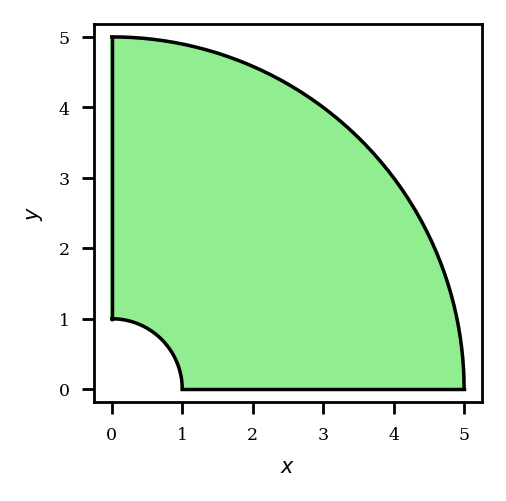

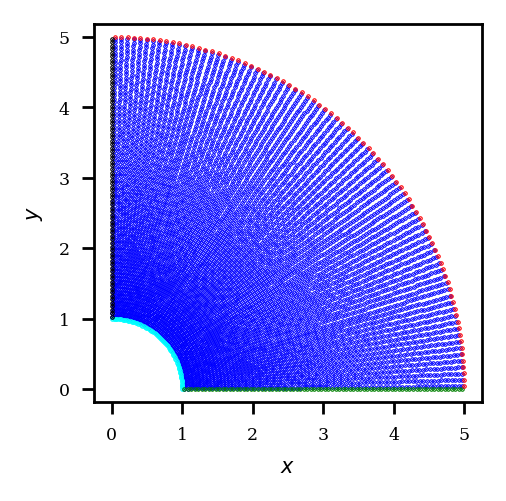

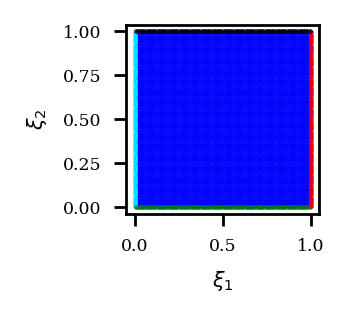

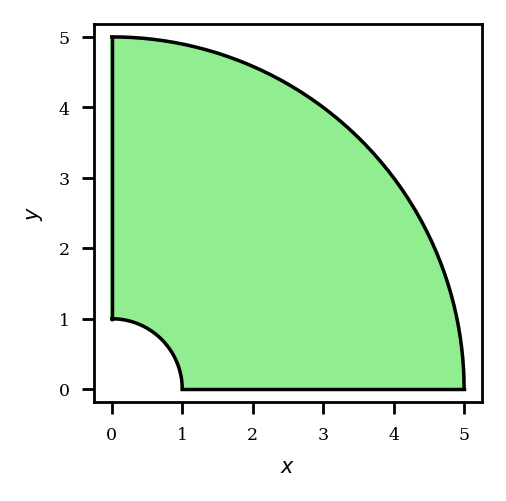

In [10]:
model_data = dict()
problem_param = dict()
realscale = 1e-3 # makes the result less sensitive w.r.t the small scale. Results will be given after unscaling.
problem_param['E'] = 135  # 135 * 1e-9 N/nm^2
problem_param['nu'] = 0.3
problem_param['lengthscale'] = 0.0 # 0.25 * 1e6 nm^2
problem_param['radInt'] = 1.0 # 1 * 1e3 nm
problem_param['radExt'] = 5.0 # 5 * 1e3 nm
problem_param['Pi'] = 10.0 # 10 * 1e-12 N/nm^2
problem_param['Po'] = 0.0 # 10 * 1e-12 N/nm^2
problem_param['scale_factor'] = realscale
# Domain bounds
problem_param['lb'] = np.array([0.0, 0.0])  # lower bound of the plate
problem_param['ub'] = np.array([problem_param['radExt'], problem_param['radExt']])  # Upper bound of the plate
NN_param = dict()
NN_param['layers'] = [2, 30, 30, 30, 2]
NN_param['iteration'] = 100
NN_param['learning_rate'] = 0.1

# Generating points inside the domain using GeometryIGA
myAnnulus = AnnulusISO(problem_param['radInt'], problem_param['radExt'])

numElemU = 80
numElemV = 80
numGauss = 1
# Generate the boundary points using Geometry class
numElemEdge = 80
numGaussEdge = 1

xyw_domain, xyw_inner, t_inner, xyw_outer, t_outer, xyw_left, xyw_right, xi_domain, dxidx_domain, xi_inner, xi_outer, xi_left, xi_right = \
gen_data_isodem_cylinder(problem_param, myAnnulus, numElemU, numElemV, numGauss, numElemEdge, numGaussEdge)

model_data['xy'] = xyw_domain
model_data['xi'] = xi_domain
model_data['dxidx'] = dxidx_domain
model_data['xy_boundary_in'] = xyw_inner
model_data['xi_boundary_in'] = xi_inner
model_data['traction_boundary_in'] = t_inner
model_data['xy_boundary_out'] = xyw_outer
model_data['xi_boundary_out'] = xi_outer
model_data['traction_boundary_out'] = t_outer
model_data['xy_boundary_left'] = xyw_left
model_data['xi_boundary_left'] = xi_left
model_data['xy_boundary_right'] = xyw_right
model_data['xi_boundary_right'] = xi_right


fig1 = plt.figure(figsize=(2, 2))
subfig1 = fig1.add_subplot(1, 1, 1)
subfig1.scatter(xyw_domain[:, 0:1], xyw_domain[:, 1:2], s=0.1, c='blue')
subfig1.scatter(xyw_inner[:, 0:1], xyw_inner[:, 1:2], s=0.1, c='cyan', zorder=10)
subfig1.scatter(xyw_right[:, 0:1], xyw_right[:, 1:2], s=0.1, c='green', zorder=10)
subfig1.scatter(xyw_outer[:, 0:1], xyw_outer[:, 1:2], s=0.1, c='red', zorder=10)
subfig1.scatter(xyw_left[:, 0:1], xyw_left[:, 1:2], s=0.1, c='black', zorder=10)
subfig1.set_xlabel(r'$x$')
subfig1.set_ylabel(r'$y$')
subfig1.axis('equal')
fig1.savefig(path_save_pic + '/physical_cylinder.eps', format='eps')  

fig2 = plt.figure(figsize=(1.0, 1.0))
subfig2 = fig2.add_subplot(1, 1, 1)
subfig2.scatter(xi_domain[:, 0:1], xi_domain[:, 1:2], s=0.1, c='blue')
subfig2.scatter(xi_inner[:, 0:1], xi_inner[:, 1:2], s=0.1, c='cyan')
subfig2.scatter(xi_right[:, 0:1], xi_right[:, 1:2], s=0.1, c='green')
subfig2.scatter(xi_outer[:, 0:1], xi_outer[:, 1:2], s=0.1, c='red')
subfig2.scatter(xi_left[:, 0:1], xi_left[:, 1:2], s=0.1, c='black')
subfig2.set_xlabel(r'$\xi_1$')
subfig2.set_ylabel(r'$\xi_2$')
subfig2.axis('equal')
fig2.savefig(path_save_pic +  '/isoparam_cylinder.eps', format='eps')
plt.show()

#  %%%%%%%%%%%%%% VALIDATION SET %%%%%%%%%%%%%% #
valnumElemU = 50
valnumElemV = 50
valnumGauss = 1
valnumElemEdge = 50
valnumGaussEdge = 1
val_xyw_domain, val_xyw_inner, val_t_inner, val_xyw_outer, val_t_outer, val_xyw__left, val_xyw_right, val_xi_domain, val_dxidx_domain, val_xi_inner, val_xi_outer, val_xi_left, val_xi_right = \
gen_data_isodem_cylinder(problem_param, myAnnulus, valnumElemU, valnumElemV, valnumGauss, valnumElemEdge, valnumGaussEdge)
model_data['val_xy'] = val_xyw_domain
model_data['val_xy_boundary_in'] = val_xyw_inner
model_data['val_traction_boundary_in'] = val_t_inner
model_data['val_xy_boundary_out'] = val_xyw_outer
model_data['val_traction_boundary_out'] = val_t_outer
model_data['val_xy_boundary_left'] = val_xyw__left
model_data['val_xy_boundary_right'] = val_xyw_right
#  %%%%%%%%%%%%%% END %%%%%%%%%%%%%% #
# -----------------------------


In [11]:
# # ----------------------------------------------------------------------
# #               TRAINING MODEL
# # ----------------------------------------------------------------------

mat = ISODEMEnergyModel('elasticity', 2, problem_param['E'], problem_param['nu'], problem_param['lengthscale'])

isodem_cylinder1 = ISODEMCYLINDER(NN_param['layers'], 'gauss', mat, 2, NN_param, network=False)

print(isodem_cylinder1.model)

start_time = time.time()
isodem_cylinder1.model.train()
isodem_cylinder1.train_model(model_data, problem_param)
end_time = time.time() - start_time
print("End time: %.5f" % end_time)
# -----------------------------

MultiLayerNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=2, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
Iter: 1 Loss: 5.379576683e+00 - L2-error: 2.563708305e+00 - Energy-error: 2.390979877e+00 - Time: 1.335e+00
Iter: 1 Loss: 4.937294006e+00 - L2-error: 2.409799099e+00 - Energy-error: 2.303876813e+00 - Time: 1.065e+00
Iter: 1 Loss: 4.202218533e+00 - L2-error: 2.158021212e+00 - Energy-error: 2.152891323e+00 - Time: 8.352e-01
Iter: 1 Loss: 3.478327274e+00 - L2-error: 1.908975840e+00 - Energy-error: 1.993951030e+00 - Time: 8.110e-01
Iter: 1 Loss: 2.822239399e+00 - L2-error: 1.681278229e+00 - Energy-error: 1.838364212e+00 - Time: 7.039e-01
Iter: 1 Loss: 2.250108004e+00 - L2-error: 1.479990602e+00 - Energy-error: 1.690916987e+00 - Time: 6.839e-01
Iter: 1 Loss: 1.

#### With transfer learning in reference domain

In [12]:
# # ----------------------------------------------------------------------
# #               TRANSFER LEARNING APPLIED
# # ----------------------------------------------------------------------
NN_param['iteration'] = 100
NN_param['learning_rate'] = 0.1

mat = ISODEMEnergyModel('elasticity', 2, problem_param['E'], problem_param['nu'], problem_param['lengthscale'])

isodem_cylinder2 = ISODEMCYLINDER(NN_param['layers'], 'gauss', mat, 2, NN_param, network=True)

# # Free mlp1 parameters
# for param in isodem_cylinder2.model.parameters():
#     param.requires_grad = False
#     print(param)

# isodem_cylinder2.model.mlp2 = nn.Sequential(
#             nn.Linear(30, 100),
#             nn.Tanh(),
#             nn.Linear(100, 100),
#             nn.Tanh(),
#             nn.Linear(100, 30),
#             nn.Tanh()
#         )
# for param in isodem_cylinder2.model.parameters():
# #     param.requires_grad = False
#     print(param)
    
# print(isodem_cylinder2.model)

# isodem_cylinder2.optimizer = torch.optim.LBFGS(isodem_cylinder2.model.mlp2.parameters(), lr=isodem_cylinder2.learning_rate_lbfgs, max_iter=20)

start_time = time.time()
isodem_cylinder2.model.train()
isodem_cylinder2.train_model(model_data, problem_param)
end_time = time.time() - start_time
print("End time: %.5f" % end_time)
# -----------------------------

Iter: 1 Loss: 1.403464508e+01 - L2-error: 3.594503403e+00 - Energy-error: 3.288258174e+00 - Time: 6.048e-01
Iter: 1 Loss: 1.305774689e+01 - L2-error: 3.421209574e+00 - Energy-error: 3.179441587e+00 - Time: 5.988e-01
Iter: 1 Loss: 1.137700939e+01 - L2-error: 3.092882872e+00 - Energy-error: 2.983415934e+00 - Time: 5.963e-01
Iter: 1 Loss: 9.661358833e+00 - L2-error: 2.730485201e+00 - Energy-error: 2.769906968e+00 - Time: 6.215e-01
Iter: 1 Loss: 8.075363159e+00 - L2-error: 2.375485182e+00 - Energy-error: 2.557420848e+00 - Time: 6.623e-01
Iter: 1 Loss: 6.673119545e+00 - L2-error: 2.049241304e+00 - Energy-error: 2.353977237e+00 - Time: 6.427e-01
Iter: 1 Loss: 5.460732937e+00 - L2-error: 1.758843899e+00 - Energy-error: 2.162641557e+00 - Time: 6.112e-01
Iter: 1 Loss: 4.427734375e+00 - L2-error: 1.504495621e+00 - Energy-error: 1.984728450e+00 - Time: 6.050e-01
Iter: 1 Loss: 3.556910515e+00 - L2-error: 1.283903360e+00 - Energy-error: 1.820734455e+00 - Time: 6.099e-01
Iter: 1 Loss: 2.828438044e+0

#### <u> Extra step (for comparison) </u>: Solving the problem without transfer learning in physical domain

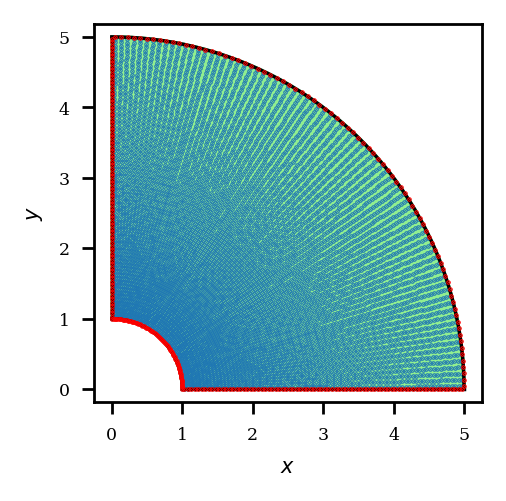

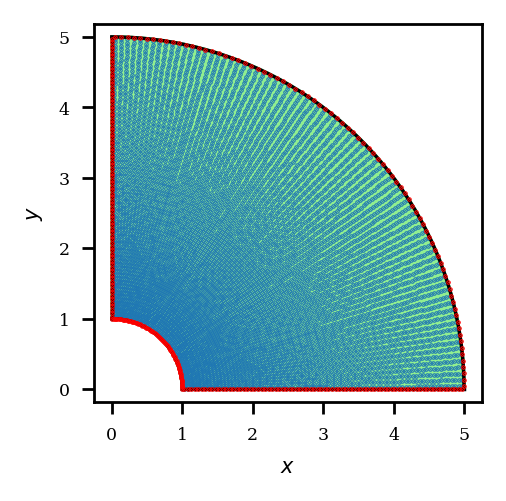

Iter: 1 Loss: 2.716772949e+03 - Validation Loss: 2.716772949e+03 - L2-error: 4.487760925e+01 - Energy-error: 3.851650881e+01 - Time: 6.542e-01
Iter: 1 Loss: 2.649501953e+03 - Validation Loss: 2.649501953e+03 - L2-error: 4.424339676e+01 - Energy-error: 3.802814351e+01 - Time: 6.776e-01
Iter: 1 Loss: 2.167664307e+03 - Validation Loss: 2.167664307e+03 - L2-error: 3.948908997e+01 - Energy-error: 3.433689293e+01 - Time: 6.674e-01
Iter: 1 Loss: 1.729550781e+03 - Validation Loss: 1.729550781e+03 - L2-error: 3.474109268e+01 - Energy-error: 3.061251609e+01 - Time: 6.338e-01
Iter: 1 Loss: 1.351866699e+03 - Validation Loss: 1.351866699e+03 - L2-error: 3.019562912e+01 - Energy-error: 2.700942173e+01 - Time: 6.219e-01
Iter: 1 Loss: 1.042508179e+03 - Validation Loss: 1.042508179e+03 - L2-error: 2.602039528e+01 - Energy-error: 2.366854156e+01 - Time: 6.186e-01
Iter: 1 Loss: 8.013021851e+02 - Validation Loss: 8.013021851e+02 - L2-error: 2.234844589e+01 - Energy-error: 2.070618075e+01 - Time: 6.358e-01

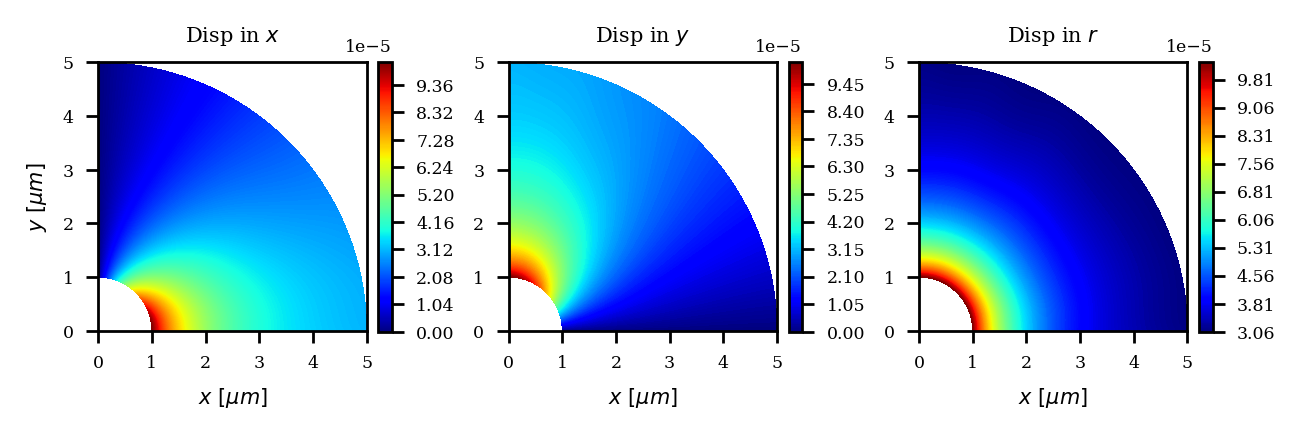

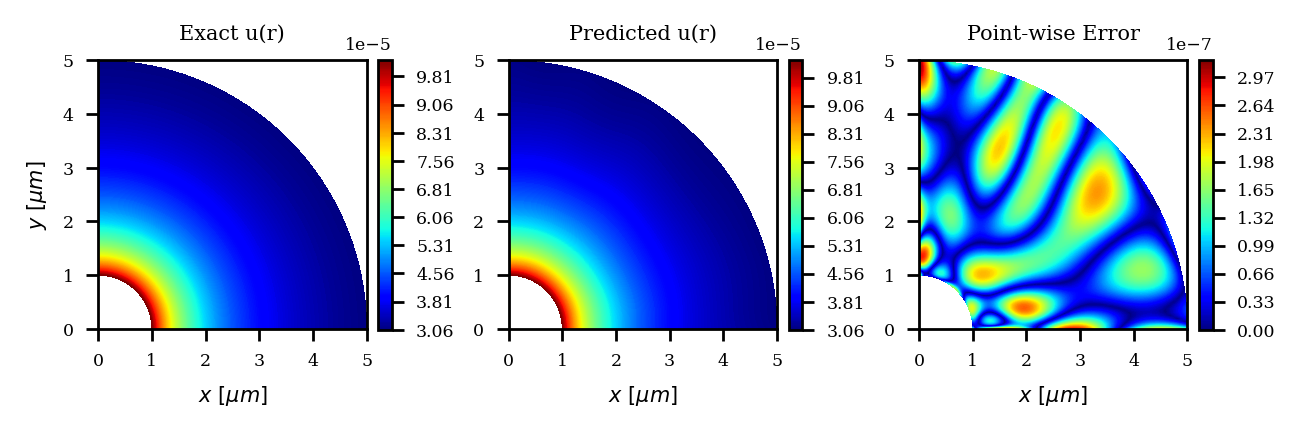

Relative L2 error:  0.0015925708394280357


In [13]:
class Geometry2D:
    '''
     Base class for 2D domains
     Input: geomData - dictionary containing the geomety information
     Keys: degree_u, degree_v: polynomial degree in the u and v directions
       ctrlpts_size_u, ctrlpts_size_v: number of control points in u,v directions
       ctrlpts: weighted control points (in a list with
            ctrlpts_size_u*ctrlpts_size_v rows and 3 columns for x,y,z coordinates)
       weights: correspond weights (list with ctrlpts_size_u*ctrlpts_size_v entries)
       knotvector_u, knotvector_v: knot vectors in the u and v directions
    '''

    def __init__(self, geomData):
        self.surf = NURBS.Surface()
        self.surf.degree_u = geomData['degree_u']
        self.surf.degree_v = geomData['degree_v']
        self.surf.ctrlpts_size_u = geomData['ctrlpts_size_u']
        self.surf.ctrlpts_size_v = geomData['ctrlpts_size_v']
        self.surf.ctrlpts = self.getUnweightedCpts(geomData['ctrlpts'],
                                                   geomData['weights'])
        self.surf.weights = geomData['weights']
        self.surf.knotvector_u = geomData['knotvector_u']
        self.surf.knotvector_v = geomData['knotvector_v']

    def getUnweightedCpts(self, ctrlpts, weights):
        numCtrlPts = np.shape(ctrlpts)[0]
        PctrlPts = np.zeros_like(ctrlpts)
        for i in range(3):
            for j in range(numCtrlPts):
                PctrlPts[j, i] = ctrlpts[j][i] / weights[j]
        PctrlPts = PctrlPts.tolist()
        return PctrlPts

    def mapPoints(self, uPar, vPar):
        '''
        Map points from the parameter domain [0,1]x[0,1] to the quadrilater domain
        Input:  uPar - array containing the u-coordinates in the parameter space
                vPar - array containing the v-coordinates in the parameter space
                Note: the arrays uPar and vPar must be of the same size
        Output: xPhys - array containing the x-coordinates in the physical space
                yPhys - array containing the y-coordinates in the physical space
        '''
        gpParamUV = np.array([uPar, vPar])
        evalList = tuple(map(tuple, gpParamUV.transpose()))
        res = np.array(self.surf.evaluate_list(evalList))

        return res

    def getUnifIntPts(self, numPtsU, numPtsV, withEdges):
        '''
        Generate uniformly spaced points inside the domain
        Input: numPtsU, numPtsV - number of points (including edges) in the u and v
                   directions in the parameter space
               withEdges - 1x4 array of zeros or ones specifying whether the boundary points
                           should be included. The boundary order is [bottom, right,
                           top, left] for the unit square.
        Output: xM, yM - flattened array containing the x and y coordinates of the points
        '''
        # generate points in the x direction on the interval [0,1]
        uEdge = np.linspace(0, 1, numPtsU)
        vEdge = np.linspace(0, 1, numPtsV)

        # remove endpoints depending on values of withEdges
        if withEdges[0] == 0:
            vEdge = vEdge[1:]
        if withEdges[1] == 0:
            uEdge = uEdge[:-1]
        if withEdges[2] == 0:
            vEdge = vEdge[:-1]
        if withEdges[3] == 0:
            uEdge = uEdge[1:]

        # create meshgrid
        uPar, vPar = np.meshgrid(uEdge, vEdge)

        uPar = uPar.flatten()
        vPar = vPar.flatten()
        # map points
        res = self.mapPoints(uPar.T, vPar.T)

        xPhys = res[:, 0:1]
        yPhys = res[:, 1:2]

        return xPhys, yPhys

    def getQuadIntPts(self, numElemU, numElemV, numGauss):
        '''
        Generate quadrature points inside the domain
        Input: numElemU, numElemV - number of subdivisions in the u and v
                   directions in the parameter space
               numGauss - number of Gauss quadrature points for each subdivision
        Output: xPhys, yPhys, wgtPhy - arrays containing the x and y coordinates
                                    of the points and the corresponding weights
        '''
        # allocate quadPts array
        quadPts = np.zeros((numElemU * numElemV * numGauss ** 2, 3))

        # get the Gauss points on the reference interval [-1,1]
        gp, gw = np.polynomial.legendre.leggauss(numGauss)

        # get the Gauss weights on the reference element [-1, 1]x[-1,1]
        gpWeightU, gpWeightV = np.meshgrid(gw, gw)
        gpWeightUV = np.array(gpWeightU.flatten() * gpWeightV.flatten())

        # generate the knots on the interval [0,1]
        uEdge = np.linspace(0, 1, numElemU + 1)
        vEdge = np.linspace(0, 1, numElemV + 1)

        # create meshgrid
        uPar, vPar = np.meshgrid(uEdge, vEdge)

        # generate points for each element
        indexPt = 0
        for iV in range(numElemV):
            for iU in range(numElemU):
                uMin = uPar[iV, iU]
                uMax = uPar[iV, iU + 1]
                vMin = vPar[iV, iU]
                vMax = vPar[iV + 1, iU]
                gpParamU = (uMax - uMin) / 2 * gp + (uMax + uMin) / 2
                gpParamV = (vMax - vMin) / 2 * gp + (vMax + vMin) / 2
                gpParamUg, gpParamVg = np.meshgrid(gpParamU, gpParamV)
                gpParamUV = np.array([gpParamUg.flatten(), gpParamVg.flatten()])
                # Jacobian of the transformation from the reference element [-1,1]x[-1,1]
                scaleFac = (uMax - uMin) * (vMax - vMin) / 4

                # map the points to the physical space
                for iPt in range(numGauss ** 2):
                    curPtU = gpParamUV[0, iPt]
                    curPtV = gpParamUV[1, iPt]
                    derivMat = self.surf.derivatives(curPtU, curPtV, order=1)
                    physPtX = derivMat[0][0][0]
                    physPtY = derivMat[0][0][1]
                    derivU = derivMat[1][0][0:2]
                    derivV = derivMat[0][1][0:2]
                    JacobMat = np.array([derivU, derivV])
                    detJac = np.linalg.det(JacobMat)
                    quadPts[indexPt, 0] = physPtX
                    quadPts[indexPt, 1] = physPtY
                    quadPts[indexPt, 2] = scaleFac * detJac * gpWeightUV[iPt]
                    indexPt = indexPt + 1

        xPhys = quadPts[:, 0:1]
        yPhys = quadPts[:, 1:2]
        wgtPhys = quadPts[:, 2:3]

        return xPhys, yPhys, wgtPhys

    def getUnweightedCpts2d(self, ctrlpts2d, weights):
        numCtrlPtsU = np.shape(ctrlpts2d)[0]
        numCtrlPtsV = np.shape(ctrlpts2d)[1]
        PctrlPts = np.zeros([numCtrlPtsU, numCtrlPtsV, 3])
        counter = 0
        for j in range(numCtrlPtsU):
            for k in range(numCtrlPtsV):
                for i in range(3):
                    PctrlPts[j, k, i] = ctrlpts2d[j][k][i] / weights[counter]
                counter = counter + 1
        PctrlPts = PctrlPts.tolist()
        return PctrlPts

    def plotSurf(self):
        # plots the NURBS/B-Spline surface and the control points in 2D
        fig, ax = plt.subplots(size=(2, 1))
        patches = []

        # get the number of points in the u and v directions
        numPtsU = np.int(1 / self.surf.delta[0])
        numPtsV = np.int(1 / self.surf.delta[1])

        for j in range(numPtsV):
            for i in range(numPtsU):
                # get the index of point in the lower left corner of the visualization element
                indexPtSW = j * (numPtsU + 1) + i
                indexPtSE = indexPtSW + 1
                indexPtNE = indexPtSW + numPtsU + 2
                indexPtNW = indexPtSW + numPtsU + 1
                XYPts = np.array(self.surf.evalpts)[[indexPtSW, indexPtSE,
                                                     indexPtNE, indexPtNW], 0:2]
                poly = mpatches.Polygon(XYPts)
                patches.append(poly)

        collection = PatchCollection(patches, color="lightgreen", cmap=plt.cm.hsv, alpha=1)
        ax.add_collection(collection)

        numCtrlPtsU = self.surf._control_points_size[0]
        numCtrlPtsV = self.surf._control_points_size[1]
        ctrlpts = self.getUnweightedCpts2d(self.surf.ctrlpts2d, self.surf.weights)
        # plot the horizontal lines
        for j in range(numCtrlPtsU):
            plt.plot(np.array(ctrlpts)[j, :, 0], np.array(ctrlpts)[j, :, 1], ls='--', color='black')
        # plot the vertical lines
        for i in range(numCtrlPtsV):
            plt.plot(np.array(ctrlpts)[:, i, 0], np.array(ctrlpts)[:, i, 1], ls='--', color='black')
        # plot the control points
        plt.scatter(np.array(self.surf.ctrlpts)[:, 0], np.array(self.surf.ctrlpts)[:, 1], color='red', zorder=10)
        plt.axis('equal')

    def plotKntSurf(self):
        # plots the NURBS/B-Spline surface and the knot lines in 2D
        fig, ax = plt.subplots(figsize=(2,2))
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        patches = []

        # get the number of points in the u and v directions
        self.surf.delta = 0.02
        self.surf.evaluate()
        numPtsU = np.int(1 / self.surf.delta[0])
        numPtsV = np.int(1 / self.surf.delta[1])

        for j in range(numPtsV):
            for i in range(numPtsU):
                # get the index of point in the lower left corner of the visualization element
                indexPtSW = j * (numPtsU + 1) + i
                indexPtSE = indexPtSW + 1
                indexPtNE = indexPtSW + numPtsU + 2
                indexPtNW = indexPtSW + numPtsU + 1
                XYPts = np.array(self.surf.evalpts)[[indexPtSW, indexPtSE, indexPtNE, indexPtNW], 0:2]
                poly = mpatches.Polygon(XYPts)
                patches.append(poly)

        collection = PatchCollection(patches, color="lightgreen", cmap=plt.cm.hsv, alpha=1)
        ax.add_collection(collection)

        # plot the horizontal knot lines
        for j in np.unique(self.surf.knotvector_u):
            vVal = np.linspace(0, 1, numPtsV)
            uVal = np.ones(numPtsV) * j
            uvVal = np.array([uVal, vVal])

            evalList = tuple(map(tuple, uvVal.transpose()))
            res = np.array(self.surf.evaluate_list(evalList))
            plt.plot(res[:, 0], res[:, 1], ls='-', linewidth=1, color='black')

        # plot the vertical lines
        for i in np.unique(self.surf.knotvector_v):
            uVal = np.linspace(0, 1, numPtsU)
            vVal = np.ones(numPtsU) * i
            uvVal = np.array([uVal, vVal])

            evalList = tuple(map(tuple, uvVal.transpose()))
            res = np.array(self.surf.evaluate_list(evalList))
            plt.plot(res[:, 0], res[:, 1], ls='-', linewidth=1, color='black')

        plt.axis('equal')

    def getQuadEdgePts(self, numElem, numGauss, orient):
        '''
        Generate points on the boundary edge given by orient
        Input: numElem - number of number of subdivisions (in the v direction)
               numGauss - number of Gauss points per subdivision
               orient - edge orientation in parameter space: 1 is down (v=0),
                        2 is left (u=1), 3 is top (v=1), 4 is right (u=0)
        Output: xBnd, yBnd, wgtBnd - coordinates of the boundary in the physical
                                     space and the corresponding weights
                xNorm, yNorm  - x and y component of the outer normal vector
        '''
        # allocate quadPts array
        quadPts = np.zeros((numElem * numGauss, 5))

        # get the Gauss points on the reference interval [-1,1]
        gp, gw = np.polynomial.legendre.leggauss(numGauss)

        # generate the knots on the interval [0,1]
        edgePar = np.linspace(0, 1, numElem + 1)

        # generate points for each element
        indexPt = 0
        for iE in range(numElem):
            edgeMin = edgePar[iE]
            edgeMax = edgePar[iE + 1]
            if orient == 1:
                gpParamU = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
                gpParamV = np.zeros_like(gp)
            elif orient == 2:
                gpParamU = np.ones_like(gp)
                gpParamV = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
            elif orient == 3:
                gpParamU = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
                gpParamV = np.ones_like(gp)
            elif orient == 4:
                gpParamU = np.zeros_like(gp)
                gpParamV = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
            else:
                raise Exception('Wrong orientation given')

            gpParamUV = np.array([gpParamU.flatten(), gpParamV.flatten()])

            # Jacobian of the transformation from the reference element [-1,1]
            scaleFac = (edgeMax - edgeMin) / 2

            # map the points to the physical space
            for iPt in range(numGauss):
                curPtU = gpParamUV[0, iPt]
                curPtV = gpParamUV[1, iPt]
                derivMat = self.surf.derivatives(curPtU, curPtV, order=1)
                physPtX = derivMat[0][0][0]
                physPtY = derivMat[0][0][1]
                derivU = derivMat[1][0][0:2]
                derivV = derivMat[0][1][0:2]
                JacobMat = np.array([derivU, derivV])
                if orient == 1:
                    normX = JacobMat[0, 1]
                    normY = -JacobMat[0, 0]
                elif orient == 2:
                    normX = JacobMat[1, 1]
                    normY = -JacobMat[1, 0]
                elif orient == 3:
                    normX = -JacobMat[0, 1]
                    normY = JacobMat[0, 0]
                elif orient == 4:
                    normX = -JacobMat[1, 1]
                    normY = JacobMat[1, 0]
                else:
                    raise Exception('Wrong orientation given')

                JacobEdge = np.sqrt(normX ** 2 + normY ** 2)
                normX = normX / JacobEdge
                normY = normY / JacobEdge

                quadPts[indexPt, 0] = physPtX
                quadPts[indexPt, 1] = physPtY
                quadPts[indexPt, 2] = normX
                quadPts[indexPt, 3] = normY
                quadPts[indexPt, 4] = scaleFac * JacobEdge * gw[iPt]
                indexPt = indexPt + 1

        xPhys = quadPts[:, 0:1]
        yPhys = quadPts[:, 1:2]
        xNorm = quadPts[:, 2:3]
        yNorm = quadPts[:, 3:4]
        wgtPhys = quadPts[:, 4:5]

        return xPhys, yPhys, xNorm, yNorm, wgtPhys


class Annulus(Geometry2D):
    """
     Class for definining a quarter-annulus domain centered at the orgin
         (the domain is in the first quadrant)
     Input: rad_int, rad_ext - internal and external radii of the annulus
    """

    def __init__(self, radInt, radExt):
        geomData = dict()

        # Set degrees
        geomData['degree_u'] = 1
        geomData['degree_v'] = 2

        # Set control points
        geomData['ctrlpts_size_u'] = 2
        geomData['ctrlpts_size_v'] = 3

        geomData['ctrlpts'] = [[radInt, 0., 0.],
                               [radInt * np.sqrt(2) / 2, radInt * np.sqrt(2) / 2, 0.],
                               [0., radInt, 0.],
                               [radExt, 0., 0.],
                               [radExt * np.sqrt(2) / 2, radExt * np.sqrt(2) / 2, 0.],
                               [0., radExt, 0.]]

        geomData['weights'] = [1, np.sqrt(2) / 2, 1, 1, np.sqrt(2) / 2, 1]

        # Set knot vectors
        geomData['knotvector_u'] = [0.0, 0.0, 1.0, 1.0]
        geomData['knotvector_v'] = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0]

        super().__init__(geomData)


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Energy model %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
class EnergyModel:
    # ---------------------------------------------------------------------------------------------------------------------------
    def __init__(self, energy, dim, E=None, nu=None, c=None):
        self.type = energy
        self.dim = dim
        self.E = E
        self.nu = nu
        self.mu = E / (2 * (1 + nu))
        self.lam = (E * nu) / ((1 + nu) * (1 - 2 * nu))
        if self.type == 'straingradient' or self.type == 'straingradientrphi':
            self.c = c

    def linear_elasticity(self, u, xy):
        du1_dxy = grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        du2_dxy = grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        eps11 = du1_dxy[:, 0]
        eps12 = 0.5 * (du1_dxy[:, 1] + du2_dxy[:, 0])
        eps21 = 0.5 * (du2_dxy[:, 0] + du1_dxy[:, 1])
        eps22 = du2_dxy[:, 1]
        traceEps = eps11 + eps22

        self.c11 = self.E / (1 - self.nu ** 2)
        self.c22 = self.E / (1 - self.nu ** 2)
        self.c12 = self.E * self.nu / (1 - self.nu ** 2)
        self.c21 = self.E * self.nu / (1 - self.nu ** 2)
        self.c31 = 0.0
        self.c32 = 0.0
        self.c13 = 0.0
        self.c23 = 0.0
        self.c33 = self.E / (2 * (1 + self.nu))
        sig11 = self.c11 * eps11 + self.c12 * eps22
        sig22 = self.c21 * eps11 + self.c22 * eps22
        sig12 = self.c33 * 2 * eps12
        
        sigma = torch.cat((sig11.unsqueeze(1), sig22.unsqueeze(1), sig12.unsqueeze(1)), 1)
        epsilon = torch.cat((eps11.unsqueeze(1), eps22.unsqueeze(1), (eps12*2).unsqueeze(1)), 1)
        
#         print(sig11)
        energy = 0.5 * (sig11 * eps11 + sig22 * eps22 + 2 * sig12 * eps12)
        return energy, sigma, epsilon
        
    def getGraduBoundary(self, u, xy):
#         print('uxy = ', u)
#         print('xy = ', xy)
        duy_dxy = \
            grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
#         print('duy_dxy = ', duy_dxy)
        dux_dxy = \
            grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
#         print('dux_dxy = ', dux_dxy)
        return duy_dxy[:, 0], dux_dxy[:, 1]

    def getBCRight(self, u, xy):
        dux_dxy = \
            grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
        duy_dxy = \
            grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
        return dux_dxy[:, 1], duy_dxy[:, 0]

    def getStrainGradient2D(self, u, xy):
        du1_dxy = grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        du2_dxy = grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        eps11 = du1_dxy[:, 0]
        eps12 = 0.5 * (du1_dxy[:, 1] + du2_dxy[:, 0])
        eps21 = 0.5 * (du2_dxy[:, 0] + du1_dxy[:, 1])
        eps22 = du2_dxy[:, 1]
        traceEps = eps11 + eps22
        tau11 = self.lam * traceEps + 2 * self.mu * eps11
        tau12 = 2 * self.mu * eps12
        tau21 = 2 * self.mu * eps21
        tau22 = self.lam * traceEps + 2 * self.mu * eps22
        deps11_dxy = grad(eps11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps12_dxy = grad(eps12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps21_dxy = grad(eps21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps22_dxy = grad(eps22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        kappa111 = deps11_dxy[:, 0]
        kappa112 = deps11_dxy[:, 1]
        kappa121 = deps12_dxy[:, 0]
        kappa122 = deps12_dxy[:, 1]
        kappa211 = deps21_dxy[:, 0]
        kappa212 = deps21_dxy[:, 1]
        kappa221 = deps22_dxy[:, 0]
        kappa222 = deps22_dxy[:, 1]
        dtau11_dxy = grad(tau11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau12_dxy = grad(tau12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau21_dxy = grad(tau21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau22_dxy = grad(tau22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        mu111 = self.c * dtau11_dxy[:, 0]
        mu112 = self.c * dtau11_dxy[:, 1]
        mu121 = self.c * dtau12_dxy[:, 0]
        mu122 = self.c * dtau12_dxy[:, 1]
        mu211 = self.c * dtau21_dxy[:, 0]
        mu212 = self.c * dtau21_dxy[:, 1]
        mu221 = self.c * dtau22_dxy[:, 0]
        mu222 = self.c * dtau22_dxy[:, 1]
        strainEnergy = 0.5 * ((tau11 * eps11 + tau12 * eps12 + tau21 * eps21 + tau22 * eps22) + (
            mu111 * kappa111 + mu112 * kappa112 + mu121 * kappa121 + mu122 * kappa122 + mu211 * kappa211 + mu212 * kappa212 + mu221 * kappa221 + mu222 * kappa222))
        return strainEnergy
    
    def get_stress_strain(self, u, xy):
#     xy_tensor = torch.from_numpy(xy).float()
#     xy_tensor = xy_tensor.to(dev)
#     xy_tensor = requires_grad_(True)
#     u_pred_torch = self.getU(xy_tensor)
#     duxdxy = grad(u_pred_torch[:, 0].unsqueeze(1), xy_tensor, torch.ones(xy_tensor.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
#     duydxy = grad(u_pred_torch[:, 1].unsqueeze(1), xy_tensor, torch.ones(xy_tensor.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
    
        du1_dxy = grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        du2_dxy = grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        eps11 = du1_dxy[:, 0]
        eps12 = 0.5 * (du1_dxy[:, 1] + du2_dxy[:, 0])
        eps21 = 0.5 * (du2_dxy[:, 0] + du1_dxy[:, 1])
        eps22 = du2_dxy[:, 1]
        traceEps = eps11 + eps22
        tau11 = self.lam * traceEps + 2 * self.mu * eps11
        tau12 = 2 * self.mu * eps12
        tau21 = 2 * self.mu * eps21
        tau22 = self.lam * traceEps + 2 * self.mu * eps22
        deps11_dxy = grad(eps11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps12_dxy = grad(eps12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps21_dxy = grad(eps21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps22_dxy = grad(eps22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        kappa111 = deps11_dxy[:, 0]
        kappa112 = deps11_dxy[:, 1]
        kappa121 = deps12_dxy[:, 0]
        kappa122 = deps12_dxy[:, 1]
        kappa211 = deps21_dxy[:, 0]
        kappa212 = deps21_dxy[:, 1]
        kappa221 = deps22_dxy[:, 0]
        kappa222 = deps22_dxy[:, 1]
        dtau11_dxy = grad(tau11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau12_dxy = grad(tau12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau21_dxy = grad(tau21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau22_dxy = grad(tau22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        mu111 = self.c * dtau11_dxy[:, 0]
        mu112 = self.c * dtau11_dxy[:, 1]
        mu121 = self.c * dtau12_dxy[:, 0]
        mu122 = self.c * dtau12_dxy[:, 1]
        mu211 = self.c * dtau21_dxy[:, 0]
        mu212 = self.c * dtau21_dxy[:, 1]
        mu221 = self.c * dtau22_dxy[:, 0]
        mu222 = self.c * dtau22_dxy[:, 1]

        dmu111_dxy = grad(mu111.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu112_dxy = grad(mu112.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu121_dxy = grad(mu121.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu122_dxy = grad(mu122.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu211_dxy = grad(mu211.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu212_dxy = grad(mu212.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu221_dxy = grad(mu221.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu222_dxy = grad(mu222.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        sigma11 = tau11 - (dmu111_dxy[:, 0] + dmu112_dxy[:, 1])
        sigma12 = tau12 - (dmu121_dxy[:, 0] + dmu122_dxy[:, 1])
        sigma21 = tau21 - (dmu211_dxy[:, 0] + dmu212_dxy[:, 1])
        sigma22 = tau22 - (dmu221_dxy[:, 0] + dmu222_dxy[:, 1])

        Phi = torch.atan(xy[:, 1] / xy[:, 0])
        cosPhi = torch.cos(Phi)
        sinPhi = torch.sin(Phi)
        Srr = (cosPhi ** 2) * sigma11 + (sinPhi ** 2) * sigma22 + (sinPhi * cosPhi) * (sigma12 + sigma21)
        Spp = (sinPhi ** 2) * sigma11 + (cosPhi ** 2) * sigma22 - (sinPhi * cosPhi) * (sigma12 + sigma21)
        
        taurr = (cosPhi ** 2) * tau11 + (sinPhi ** 2) * tau22 + (sinPhi * cosPhi) * (tau12 + tau21)
        taupp = (sinPhi ** 2) * tau11 + (cosPhi ** 2) * tau22 - (sinPhi * cosPhi) * (tau12 + tau21)
        epsrr = (cosPhi ** 2) * eps11 + (sinPhi ** 2) * eps22 + (sinPhi * cosPhi) * (eps12 + eps21)
        epspp = (sinPhi ** 2) * eps11 + (cosPhi ** 2) * eps22 - (sinPhi * cosPhi) * (eps12 + eps21)
        
    #     strainEnergy = 0.5 * ((tau11 * eps11 + tau12 * eps12 + tau21 * eps21 + tau22 * eps22) 
    #                    + (mu111 * kappa111 + mu112 * kappa112 + mu121 * kappa121 + mu122 * kappa122 + mu211 * kappa211 + mu212 * kappa212 + mu221 * kappa221 + mu222 * kappa222))

        return taurr, taupp, epsrr, epspp

def u_exact(P, E, nu, ro, ri, r):
    return (ri **2 * P * r) / (E * (ro**2 - ri**2)) * (1 - nu + (ro/r)**2 * (1 + nu))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Deep energy method %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
class DeepEnergyMethod:
    # Instance attributes
    def __init__(self, layers, numIntType, energy, dim, network=False):
        # self.data = data
        if network == False:
            self.model = MultiLayerNet(layers)
        else:
            state_dict = torch.load('dem_AdvNN_v1_thickwall_straingrad_xy_checkpoint.pth', map_location=torch.device('cpu'))
#             print(state_dict.keys())
            # Try this
            print("Transfer learning")
            self.model = MultiLayerNet(layers)
            # This will throw an error because the tensor sizes are wrong!
            self.model.load_state_dict(state_dict)
            self.model = self.model.to(dev)
#         self.intLoss = IntegrationLoss(numIntType, dim)
        self.energy = energy
        # self.post = PostProcessing(energy, dim)
        self.dim = dim
        self.lossArray = []
        self.valLossArray = []
        self.l2errorArray = []
        self.enerrorArray = []

    def train_model(self, data, nn_param, problem_param):
        # ---------- training data ---------------#
        xy_domain = data['xy']

        xy_boundary_in = data['xy_boundary_in']
        traction_boundary_in = data['traction_boundary_in']

        xy_boundary_out = data['xy_boundary_out']
        traction_boundary_out = data['traction_boundary_out']

        xy_boundary_left = data['xy_boundary_left']
        xy_boundary_right = data['xy_boundary_right']

        xy = torch.from_numpy(xy_domain[:, 0:2]).float()
        xy = xy.to(dev)
        xy.requires_grad_(True)
        weightXY = torch.from_numpy(xy_domain[:, 2]).float()
        weightXY = weightXY.to(dev)

        xyIn = torch.from_numpy(xy_boundary_in[:, 0:2]).float()
        xyIn = xyIn.to(dev)
        xyIn.requires_grad_(True)
        weightXYBoundI = torch.from_numpy(xy_boundary_in[:, 2:3]).float()
        weightXYBoundI = weightXYBoundI.to(dev)

        xyOut = torch.from_numpy(xy_boundary_out[:, 0:2]).float()
        xyOut = xyOut.to(dev)
        xyOut.requires_grad_(True)
        weightXYBoundO = torch.from_numpy(xy_boundary_out[:, 2:3]).float()
        weightXYBoundO = weightXYBoundO.to(dev)

        xyLeft = torch.from_numpy(xy_boundary_left[:, 0:2]).float()
        xyLeft = xyLeft.to(dev)
        xyLeft.requires_grad_(True)

        xyRight = torch.from_numpy(xy_boundary_right[:, 0:2]).float()
        xyRight = xyRight.to(dev)
        xyRight.requires_grad_(True)

        inner_t = torch.from_numpy(traction_boundary_in).float().to(dev)
        outer_t = torch.from_numpy(traction_boundary_out).float().to(dev)

        # ---------- validation data ---------------#
        
        val_xy_domain = data['val_xy']

        val_xy_boundary_in = data['val_xy_boundary_in']
        val_traction_boundary_in = data['val_traction_boundary_in']

        val_xy_boundary_out = data['val_xy_boundary_out']
        val_traction_boundary_out = data['val_traction_boundary_out']

        val_xy_boundary_left = data['val_xy_boundary_left']
        val_xy_boundary_right = data['val_xy_boundary_right']

        val_xy = torch.from_numpy(val_xy_domain[:, 0:2]).float()
        val_xy = val_xy.to(dev)
        val_xy.requires_grad_(True)
        val_weightXY = torch.from_numpy(val_xy_domain[:, 2]).float()
        val_weightXY = val_weightXY.to(dev)

        val_xyIn = torch.from_numpy(val_xy_boundary_in[:, 0:2]).float()
        val_xyIn = val_xyIn.to(dev)
        val_xyIn.requires_grad_(True)
        val_weightXYBoundI = torch.from_numpy(val_xy_boundary_in[:, 2:3]).float()
        val_weightXYBoundI = val_weightXYBoundI.to(dev)

        val_xyOut = torch.from_numpy(val_xy_boundary_out[:, 0:2]).float()
        val_xyOut = val_xyOut.to(dev)
        val_xyOut.requires_grad_(True)
        val_weightXYBoundO = torch.from_numpy(val_xy_boundary_out[:, 2:3]).float()
        val_weightXYBoundO = val_weightXYBoundO.to(dev)

        val_xyLeft = torch.from_numpy(val_xy_boundary_left[:, 0:2]).float()
        val_xyLeft = val_xyLeft.to(dev)
        val_xyLeft.requires_grad_(True)

        val_xyRight = torch.from_numpy(val_xy_boundary_right[:, 0:2]).float()
        val_xyRight = val_xyRight.to(dev)
        val_xyRight.requires_grad_(True)

        val_inner_t = torch.from_numpy(val_traction_boundary_in).float().to(dev)
        val_outer_t = torch.from_numpy(val_traction_boundary_out).float().to(dev)
        # ----------------- end ---------------------- #
        
        iteration_lbfgs = nn_param['iteration']
        learning_rate_lbfgs = nn_param['learning_rate']

        optimizer1 = torch.optim.Adam(self.model.parameters())
        optimizer = torch.optim.LBFGS(self.model.parameters(), lr=learning_rate_lbfgs, max_iter=20)
        start_time = time.time()
        energy_loss_array = []
        boundary_loss_array = []
        # loss_array = []
        iteration1 = 1000
        # iteration2 = 90
        # for t in range(iteration1):
        #     it_time = time.time()
        #     # ------------------------------------------------------------------------------------
        #     u_pred = self.getU(xy)
        #     u_pred.double()
        #     strain_energy = self.energy.getStoredEnergy(u_pred, xy)
        #     U = torch.sum(strain_energy * weightXY)
        #
        #     u_boundary_i_pred = self.getU(xyIn)
        #     pressure_i = torch.bmm(u_boundary_i_pred.unsqueeze(1), inner_t.unsqueeze(2))
        #     W1 = torch.sum(pressure_i[:, 0] * weightXYBound)
        #
        #     u_boundary_o_pred = self.getU(xyOut)
        #     pressure_o = torch.bmm(u_boundary_o_pred.unsqueeze(1), outer_t.unsqueeze(2))
        #     W2 = torch.sum(pressure_o[:, 0] * weightXYBoundO)
        #
        #     u_boundary_left_pred = self.getU(xyLeft)
        #     bcleft1, bcleft2 = self.energy.getBCLeft(u_boundary_left_pred, xyLeft)
        #     crit1 = self.mse_loss(bcleft1, torch.zeros_like(bcleft1))
        #     crit2 = self.mse_loss(bcleft2, torch.zeros_like(bcleft2))
        #     u_boundary_right_pred = self.getU(xyRight)
        #     bcright1, bcright2 = self.energy.getBCRight(u_boundary_right_pred, xyRight)
        #     crit3 = self.mse_loss(bcright1, torch.zeros_like(bcright1))
        #     crit4 = self.mse_loss(bcright2, torch.zeros_like(bcright2))
        #     loss = U - (W1 + W2) + (crit1 + crit2 + crit3 + crit4) * 1e4
        #     # ------------------------------------------------------------------------------------
        #     optimizer1.zero_grad()
        #     loss.backward()
        #     optimizer1.step()  # Them vao cho adam optimizer
        #     print('Iter: %d Loss: %.9e Time: %.3e' % (t + 1, loss.item(), time.time() - it_time))
        #     self.lossArray.append(loss.data)

        for t in range(iteration_lbfgs):
            # Zero gradients, perform a backward pass, and update the weights.
            def closure():
                it_time = time.time()
                optimizer.zero_grad()
                # ------------------------------------------------------------------------------------
                u_pred = self.getU(xy)
                u_pred.double()
                strain_energy, sigma_pred, eps_pred = self.energy.linear_elasticity(u_pred, xy)
                U = torch.sum(strain_energy * weightXY)

                u_boundary_i_pred = self.getU(xyIn)
                pressure_i = torch.bmm(u_boundary_i_pred.unsqueeze(1), inner_t.unsqueeze(2))
                W1 = torch.sum(pressure_i[:, 0] * weightXYBoundI)

                u_boundary_o_pred = self.getU(xyOut)
                pressure_o = torch.bmm(u_boundary_o_pred.unsqueeze(1), outer_t.unsqueeze(2))
                W2 = torch.sum(pressure_o[:, 0] * weightXYBoundO)

                u_boundary_left_pred = self.getU(xyLeft)
                u_boundary_right_pred = self.getU(xyRight)
                
                loss = U - (W1 + W2)
                
                
                # ------------------------------------------------------------------------------------
                # # ----------------------------------------------------------------------------------
                # # Internal Energy
                # # ----------------------------------------------------------------------------------
                # u_pred = self.getU(xy)
                # u_pred.double()
                # strain_energy = self.energy.getStoredEnergy(u_pred, xy)
                # # internal2 = self.intLoss.lossInternalEnergy(storedEnergy, x, shape=shape)
                # # area = 1. / 4. * math.pi * (cf.radiusOut ** 2 - cf.radiusIn ** 2)
                # # U = area * torch.sum(strain_energy) / strain_energy.data.nelement()
                # U = torch.sum(strain_energy * weightXY)
                # # internal2 = self.intLoss.montecarlo2D(strain_energy, LHD[0], LHD[1])
                # # internal2 = self.intLoss.lossInternalEnergy(storedEnergy, dx=dxdydz[0], dy=dxdydz[1], shape=shape)
                # # bc_n_crit = torch.zeros(len(neuBC_coordinates))
                #
                # externalWork1 = torch.zeros(len(inner_points))
                # u_boundary_i_pred = self.getU(xyIn)
                # pressure_i = torch.bmm(u_boundary_i_pred.unsqueeze(1), inner_t.unsqueeze(2))
                # W1 = torch.sum(pressure_i[:, 0] * weightXYBound)
                #
                # u_boundary_o_pred = self.getU(xyOut)
                # pressure_o = torch.bmm(u_boundary_o_pred.unsqueeze(1), outer_t.unsqueeze(2))
                # W2 = torch.sum(pressure_o[:, 0] * weightXYBoundO)
                #
                # # area1 = 2 * math.pi * cf.radiusIn
                # # W1 = 1. / 4. * area1 * torch.sum(pressure_i) / pressure_i.data.nelement()
                # # externalWork_o = torch.zeros(len(outer_points))
                # # u_boundary_o_pred = self.getU(xyOut)
                # # pressure_o = torch.bmm(u_boundary_o_pred.unsqueeze(1), outer_t.unsqueeze(2))
                # # area2 = 2 * math.pi * cf.radiusOut
                # # W2 = 1. / 4. * area2 * torch.sum(pressure_o) / pressure_o.data.nelement()
                #
                # u_boundary_left_pred = self.getU(xyLeft)
                # bcleft = self.energy.getBCLeft(u_boundary_left_pred, xyLeft)
                # crit1 = self.mse_loss(bcleft, torch.zeros_like(bcleft)) * 1e2
                # u_boundary_right_pred = self.getU(xyRight)
                # bcright = self.energy.getBCRight(u_boundary_right_pred, xyRight)
                # crit2 = self.mse_loss(bcright, torch.zeros_like(bcright)) * 1e2
                # loss = U - (W1 + W2) + (crit1 + crit2)
                # # for i, vali in enumerate(neuBC_coordinates):
                # #     neu_u_pred = self.getU(neuBC_coordinates[i])
                # #     # area = LHD[1] * LHD[2]
                # #     fext = torch.bmm((neu_u_pred + neuBC_coordinates[i]).unsqueeze(1), neuBC_values[i].unsqueeze(2))
                # #     # bc_n_crit[i] = area * self.loss_sum(fext) * neuBC_penalty[i]
                # #     # external2[i] = self.intLoss.lossExternalEnergy(fext, neuBC_coordinates[i][:, 1])
                # #     # external2[i] = self.intLoss.lossExternalEnergy(fext, dx=dxdydz[1])
                # #     external2[i] = self.intLoss.montecarlo1D(fext, LHD[1])
                # # bc_u_crit = torch.zeros((len(dirBC_coordinates)))
                # # for i, vali in enumerate(dirBC_coordinates):
                # #     dir_u_pred = self.getU(dirBC_coordinates[i])
                # #     bc_u_crit[i] = self.loss_squared_sum(dir_u_pred, dirBC_values[i])
                # # energy_loss = internal2 - torch.sum(external2)
                # # boundary_loss = torch.sum(bc_u_crit)
                # # loss = energy_loss + boundary_loss
                
                # ---- validation ------ #
                val_u_pred = self.getU(val_xy)
                val_u_pred.double()
                val_strain_energy, val_stress, val_strain = self.energy.linear_elasticity(val_u_pred, val_xy)
                val_U = torch.sum(val_strain_energy * val_weightXY)

                val_u_boundary_i_pred = self.getU(val_xyIn)
                val_pressure_i = torch.bmm(val_u_boundary_i_pred.unsqueeze(1), val_inner_t.unsqueeze(2))
                val_W1 = torch.sum(val_pressure_i[:, 0] * val_weightXYBoundI)

                val_u_boundary_o_pred = self.getU(val_xyOut)
                val_pressure_o = torch.bmm(val_u_boundary_o_pred.unsqueeze(1), val_outer_t.unsqueeze(2))
                val_W2 = torch.sum(val_pressure_o[:, 0] * val_weightXYBoundO)
                val_loss = val_U - (val_W1 + val_W2)
                # -------------------------- #
                # Compare L2 norm
#                 u_nn_torch = torch.cat((u_pred, u_boundary_i_pred, u_boundary_o_pred, u_boundary_left_pred, u_boundary_right_pred), 0)
#                 u_nn = u_nn_torch.detach().cpu().numpy()
#                 ur_nn = np.sqrt(u_nn[:, 0] ** 2 + u_nn[:, 1] ** 2)
# #                 print(ur_nn[20:25])
#                 xy_coordinates_torch = torch.cat((xy, xyIn, xyOut, xyLeft, xyRight), 0)
#                 xy_coordinates = xy_coordinates_torch.detach().cpu().numpy()
#                 radius = np.sqrt(xy_coordinates[:, 0] ** 2 + xy_coordinates[:, 1] ** 2)
#                 ur_exact = u_exact(problem_param['Pi'], self.energy.E, self.energy.nu, problem_param['radExt'], problem_param['radInt'], radius)
#                 l2_error = np.linalg.norm((ur_exact - ur_nn), 2) / np.linalg.norm(ur_exact, 2)
                
  
                u_nn = u_pred.detach().cpu().numpy()
                ur_nn = np.sqrt(u_nn[:, 0] ** 2 + u_nn[:, 1] ** 2)
                xy_coordinates = xy.detach().cpu().numpy()
                radius = np.sqrt(xy_coordinates[:, 0] ** 2 + xy_coordinates[:, 1] ** 2)
                ur_exact = u_exact(problem_param['Pi'], self.energy.E, self.energy.nu, problem_param['radExt'], problem_param['radInt'], radius)
                l2_error = np.linalg.norm((ur_exact - ur_nn), 2) / np.linalg.norm(ur_exact, 2)
                
                sigma_nn = sigma_pred.detach().cpu().numpy()
                eps_nn = eps_pred.detach().cpu().numpy()
                sigma_exact = sigma_exact_cylinder(xy_domain[:, 0:1], xy_domain[:, 1:2], problem_param)
                eps_exact = eps_exact_cylinder(self.energy.mu, self.energy.lam, sigma_exact)
                energy_norm_nu = 0.5 * np.matmul(np.reshape((eps_exact - eps_nn), (len(xy), 1, 3)), np.reshape((sigma_exact - sigma_nn), (len(xy), 3, 1 )))
                energy_norm_de = 0.5 * np.matmul(np.reshape(eps_exact, (len(xy), 1, 3)), np.reshape(sigma_exact, (len(xy), 3, 1 )))
                e_error = np.sqrt(np.sum(energy_norm_nu * xy_domain[:, 2:3]) / np.sum(energy_norm_de * xy_domain[:, 2:3]))
                
                
                #--------------------------- #
                loss.backward()
                print('Iter: %d Loss: %.9e - Validation Loss: %.9e - L2-error: %.9e - Energy-error: %.9e - Time: %.3e' % (t + 1, loss.item(), val_loss.item(), l2_error, e_error, time.time() - it_time))
                # energy_loss_array.append(energy_loss.data)
                # boundary_loss_array.append(boundary_loss.data)
                self.lossArray.append(loss.data)
                self.valLossArray.append(val_loss.data)
                self.l2errorArray.append(l2_error)
                self.enerrorArray.append(e_error)
                return loss
            optimizer.step(closure)
            
        elapsed = time.time() - start_time
        print('Training time: %.4f' % elapsed)

    def getU(self, xy):
        u = self.model(xy)
        Ux = (xy[:, 0:1]) * u[:, 0:1]
        Uy = (xy[:, 1:2]) * u[:, 1:2]
        # Ux = u[:, 0:1]
        # Uy = u[:, 1:2]
        u_pred = torch.cat((Ux, Uy), 1)
        return u_pred

    # --------------------------------------------------------------------------------
    # method: loss sum for the energy part
    # --------------------------------------------------------------------------------
    @staticmethod
    def loss_sum(tinput):
        return torch.sum(tinput) / tinput.data.nelement()

    def mse_loss(self, tinput, target):
        return torch.sum((tinput - target) ** 2) / tinput.data.nelement()

    # --------------------------------------------------------------------------------
    # purpose: loss square sum for the boundary part
    # --------------------------------------------------------------------------------
    @staticmethod
    def loss_squared_sum(tinput, target):
        row, column = tinput.shape
        loss = 0
        for j in range(column):
            loss += torch.sum((tinput[:, j] - target[:, j]) ** 2) / tinput[:, j].data.nelement()
        return loss

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% GENERATE DATA %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def gen_data(model, annulus, numElemU, numElemV, numGauss, numElemEdge, numGaussEdge):
    xPhys, yPhys, wgtsPhys = annulus.getQuadIntPts(numElemU, numElemV, numGauss)
    annulus.plotKntSurf()
    X_f = np.concatenate((xPhys, yPhys, wgtsPhys), axis=1)
    plt.axis('equal')
    plt.scatter(X_f[:, 0:1], X_f[:, 1:2], s=0.1)
    # Generate the boundary points using Geometry class
    xEdgeI, yEdgeI, xNormEdgeI, yNormEdgeI, wgtsEdgeI = annulus.getQuadEdgePts(numElemEdge, numGaussEdge, 4)
    phiEdgeI = np.arctan(yEdgeI / xEdgeI)
    inner_tEdgeI = np.zeros([phiEdgeI.shape[0], 2])
    inner_tEdgeI[:, 0:1] = model['Pi'] * np.cos(phiEdgeI)
    inner_tEdgeI[:, 1:2] = model['Pi'] * np.sin(phiEdgeI)
    X_fEdgeI = np.concatenate((xEdgeI, yEdgeI, wgtsEdgeI), axis=1)
#     trac_x = -model['P'] * xNormEdgeI
#     trac_y = -model['P'] * yNormEdgeI
#     inner_tEdgeI = np.concatenate((trac_x, trac_y), axis=1)
    plt.scatter(xEdgeI, yEdgeI, s=0.1, c='red', zorder=10)

    xEdgeO, yEdgeO, xNormEdgeO, yNormEdgeO, wgtsEdgeO = annulus.getQuadEdgePts(numElemEdge, numGaussEdge, 2)
    phiEdgeO = np.arctan(yEdgeO / xEdgeO)
    inner_tEdgeO = np.zeros([phiEdgeO.shape[0], 2])
    inner_tEdgeO[:, 0:1] = -model['Po'] * np.cos(phiEdgeO)
    inner_tEdgeO[:, 1:2] = -model['Po'] * np.sin(phiEdgeO)
    X_fEdgeO = np.concatenate((xEdgeO, yEdgeO, wgtsEdgeO), axis=1)
    plt.scatter(xEdgeO, yEdgeO, s=0.1, c='red', zorder=10)

    xEdgeL, yEdgeL, xNormEdgeL, yNormEdgeL, wgtsEdgeL = annulus.getQuadEdgePts(numElemEdge, numGaussEdge, 3)
    X_fEdgeL = np.concatenate((xEdgeL, yEdgeL, wgtsEdgeL), axis=1)
    plt.scatter(xEdgeL, yEdgeL, s=0.1, c='red', zorder=10)
    xEdgeR, yEdgeR, xNormEdgeR, yNormEdgeR, wgtsEdgeR = annulus.getQuadEdgePts(numElemEdge, numGaussEdge, 1)
    X_fEdgeR = np.concatenate((xEdgeR, yEdgeR, wgtsEdgeR), axis=1)
    plt.scatter(xEdgeR, yEdgeR, s=0.1, c='red', zorder=10)
    # plt.quiver(xEdge, yEdge, xNormEdge, yNormEdge)
    plt.show()    
    return X_f, X_fEdgeI, inner_tEdgeI, X_fEdgeO, inner_tEdgeO, X_fEdgeL, X_fEdgeR

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Main program %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
model_data = dict()
problem_param = dict()
realscale = 1e-3 # makes the result less sensitive w.r.t the small scale. Results will be given after unscaling.
problem_param['E'] = 135  # 135 * 1e-9 N/nm^2
problem_param['nu'] = 0.3
problem_param['lengthscale'] = 0.25 # 0.25 * 1e6 nm^2
problem_param['radInt'] = 1.0 # 1 * 1e3 nm
problem_param['radExt'] = 5.0 # 5 * 1e3 nm
problem_param['Pi'] = 10.0 # 10 * 1e-12 N/nm^2
problem_param['Po'] = 0.0 # 10 * 1e-12 N/nm^2
problem_param['scale_factor'] = realscale
# Domain bounds
problem_param['lb'] = np.array([0.0, 0.0])  # lower bound of the plate
problem_param['ub'] = np.array([problem_param['radExt'], problem_param['radExt']])  # Upper bound of the plate
NN_param = dict()
NN_param['layers'] = [2, 30, 30, 30, 2]
NN_param['iteration'] = 100
NN_param['learning_rate'] = 0.1

# Generating points inside the domain using GeometryIGA
myAnnulus = Annulus(problem_param['radInt'], problem_param['radExt'])
numElemU = 80
numElemV = 80
numGauss = 1
# Generate the boundary points using Geometry class
numElemEdge = 80
numGaussEdge = 1
X_f, X_fEdgeI, inner_tEdgeI, X_fEdgeO, inner_tEdgeO, X_fEdgeL, X_fEdgeR = gen_data(problem_param, myAnnulus, numElemU, numElemV, numGauss, numElemEdge, numGaussEdge)
model_data['xy'] = X_f
model_data['xy_boundary_in'] = X_fEdgeI
model_data['traction_boundary_in'] = inner_tEdgeI
model_data['xy_boundary_out'] = X_fEdgeO
model_data['traction_boundary_out'] = inner_tEdgeO
model_data['xy_boundary_left'] = X_fEdgeL
model_data['xy_boundary_right'] = X_fEdgeR

valnumElemU = 80
valnumElemV = 80
valnumGauss = 1
valnumElemEdge = 80
valnumGaussEdge = 1
val_X_f, val_X_fEdgeI, val_inner_tEdgeI, val_X_fEdgeO, val_inner_tEdgeO, val_X_fEdgeL, val_X_fEdgeR = gen_data(problem_param, myAnnulus, valnumElemU, valnumElemV, valnumGauss, valnumElemEdge, valnumGaussEdge)
model_data['val_xy'] = val_X_f
model_data['val_xy_boundary_in'] = val_X_fEdgeI
model_data['val_traction_boundary_in'] = val_inner_tEdgeI
model_data['val_xy_boundary_out'] = val_X_fEdgeO
model_data['val_traction_boundary_out'] = val_inner_tEdgeO
model_data['val_xy_boundary_left'] = val_X_fEdgeL
model_data['val_xy_boundary_right'] = val_X_fEdgeR


# data_feed = np.concatenate((X_f, X_fEdge, X_fEdgeO, X_fEdgeL, X_fEdgeR), axis=0)

# # pi_x = cf.pi * np.cos(np.arctan(X_fEdge[:, 1:2] / X_fEdge[:, 0:1]))
# # pi_y = cf.pi * np.sin(np.arctan(X_fEdge[:, 1:2] / X_fEdge[:, 0:1]))
# # inner_t = np.concatenate((pi_x, pi_y), axis=1)

# # ----------------------------------------------------------------------
# #                   STEP 1: SETUP DOMAIN - COLLECT CLEAN DATABASE
# # ----------------------------------------------------------------------
# data, _, _, _, _ = des.setup_domain()
# # x, y, datatest = des.get_datatest()
# # ----------------------------------------------------------------------
# #                   STEP 2: SETUP MODEL
# # ----------------------------------------------------------------------
mat = EnergyModel('elasticity', 2, problem_param['E'], problem_param['nu'], problem_param['lengthscale'])

dem_cylinder = DeepEnergyMethod(NN_param['layers'], 'gauss', mat, 2, network=False)

# # ----------------------------------------------------------------------
# #                   STEP 3: TRAINING MODEL
# # ----------------------------------------------------------------------
start_time = time.time()
iteration = 50
# # cf.filename_out = "./output/dem/NeoHook_2Layer_mesh400x100_iter80_mont"
# TURN ON DROPOUT TECHNIQUE #
dem_cylinder.model.train()
dem_cylinder.train_model(model_data, NN_param, problem_param)

end_time = time.time() - start_time
print("End time: %.5f" % end_time)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% POST PROCESSING %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def plotDeformedDisp(surfaceUx, surfaceUy, defShapeX, defShapeY, unscaled_factor, exact_solution, num_figures):
    if num_figures == 2:
        fig, axes = plt.subplots(1, 3, figsize=(5, 5))
        cs2 = axes[0].contourf(defShapeX, defShapeY, exact_solution, 255, cmap=plt.cm.jet)
        cs3 = axes[1].contourf(defShapeX, defShapeY, np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * unscaled_factor, 255, cmap=plt.cm.jet)
        cs4 = axes[2].contourf(defShapeX, defShapeY, np.abs(exact_solution - (np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * unscaled_factor)), 255, cmap=plt.cm.jet)
        # plot equal colorbars as in
        # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
        cb2 = fig.colorbar(cs2, ax=axes[0], fraction=0.046, pad=0.04)
        cb3 = fig.colorbar(cs3, ax=axes[1], fraction=0.046, pad=0.04)
        cb4 = fig.colorbar(cs4, ax=axes[2], fraction=0.046, pad=0.04)
        cb2.formatter.set_powerlimits((0, 0))
        cb2.update_ticks()
        cb3.formatter.set_powerlimits((0, 0))
        cb3.update_ticks()
        cb4.formatter.set_powerlimits((0, 0))
        cb4.update_ticks()
        fig.tight_layout()
        axes[0].set_title("Exact u(r)")
        axes[1].set_title("Predicted u(r)")
        axes[2].set_title("Point-wise Error")
        axes[0].set_ylabel('$y \,\, [\mu m]$')
        for tax in axes:
          tax.set_xlabel('$x \,\, [\mu m]$')
          tax.set_aspect('equal')
        plt.show()
    if num_figures == 3:
        fig, axes = plt.subplots(1, 3, figsize=(5, 5))
        cs1 = axes[0].contourf(defShapeX, defShapeY, surfaceUx * unscaled_factor, 255, cmap=plt.cm.jet)
        cs2 = axes[1].contourf(defShapeX, defShapeY, surfaceUy * unscaled_factor, 255, cmap=plt.cm.jet)
        cs3 = axes[2].contourf(defShapeX, defShapeY, np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * unscaled_factor, 255, cmap=plt.cm.jet)
        # plot equal colorbars as in
        # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
        cb1 = fig.colorbar(cs1, ax=axes[0], fraction=0.046, pad=0.04)
        cb2 = fig.colorbar(cs2, ax=axes[1], fraction=0.046, pad=0.04)
        cb3 = fig.colorbar(cs3, ax=axes[2], fraction=0.046, pad=0.04)
        cb1.formatter.set_powerlimits((0, 0))
        cb1.update_ticks()
        cb2.formatter.set_powerlimits((0, 0))
        cb2.update_ticks()
        cb3.formatter.set_powerlimits((0, 0))
        cb3.update_ticks()
        fig.tight_layout()
        axes[0].set_title("Disp in $x$")
        axes[1].set_title("Disp in $y$")
        axes[2].set_title("Disp in $r$")
        axes[0].set_ylabel('$y \,\, [\mu m]$')
        for tax in axes:
          tax.set_xlabel('$x \,\, [\mu m]$')
          tax.set_aspect('equal')
        plt.show()

def setup_domain(problem_param, NPhi, NR):
#     NPhi = 120
#     NR = 120
    radiusIn = problem_param['radInt']
    radiusOut = problem_param['radExt']
    pi = problem_param['Pi']
    po = problem_param['Po']
    minPhi, maxPhi = (0, np.pi/2)
    # mesh
    dR = np.linspace(radiusIn, radiusOut, NR)
    dPhi = np.arange(0, NPhi)/(NPhi-1) * maxPhi
    R_grid, Phi_grid = np.meshgrid(dR, dPhi)
    R1D = np.array([R_grid.flatten()]).T
    Phi1D = np.array([Phi_grid.flatten()]).T
    cylCoord = np.concatenate((R1D, Phi1D), axis=1)
    X = R1D * np.cos(Phi1D)
    Y = R1D * np.sin(Phi1D)
    coordinates = np.concatenate((X, Y), axis=1)
    # left boundary
    left_idx = np.where(np.abs(cylCoord[:, 1] - maxPhi) < 1e-12)[0]
    left_points = coordinates[left_idx, :]
    left_points[:, 0] = 0.0
    # bottom boundary
    bottom_idx = np.where(np.abs(cylCoord[:, 1] - minPhi) < 1e-12)[0]
    bottom_points = coordinates[bottom_idx, :]
    bottom_points[:, 1] = 0.0
    # inner boundary
    inner_idx = np.where(np.abs(cylCoord[:, 0] - radiusIn) < 1e-12)[0]
    inner_points = coordinates[inner_idx, :]
    pi_x = pi * np.cos(np.arctan(inner_points[:, 1:2] / inner_points[:, 0:1]))
    pi_y = pi * np.sin(np.arctan(inner_points[:, 1:2] / inner_points[:, 0:1]))
    inner_t = np.concatenate((pi_x, pi_y), axis=1)
    # outer boundary
    outer_idx = np.where(np.abs(cylCoord[:, 0] - radiusOut) < 1e-12)[0]
    outer_points = coordinates[outer_idx, :]
    po_x = -po * np.cos(np.arctan(outer_points[:, 1:2] / outer_points[:, 0:1]))
    po_y = -po * np.sin(np.arctan(outer_points[:, 1:2] / outer_points[:, 0:1]))
    outer_t = np.concatenate((po_x, po_y), axis=1)
    # drawing
    # fig = plt.figure(figsize=(3, 2))
    # ax = fig.add_subplot(111)
    # ax.scatter(coordinates[:, 0], coordinates[:, 1], s=0.05, facecolor='blue')
    # ax.scatter(left_points[:, 0], left_points[:, 1], s=0.5, facecolor='green')
    # ax.scatter(bottom_points[:, 0], bottom_points[:, 1], s=0.5, facecolor='red')
    # ax.scatter(inner_points[:, 0], inner_points[:, 1], s=0.5, facecolor='yellow')
    # ax.scatter(outer_points[:, 0], outer_points[:, 1], s=0.5, facecolor='black')
    # # ax.set(xlim=(centerX - 0.5*1e-6, centerX + radiusOut + 0.5*1e-6), ylim=(centerY - 0.5*1e-6, centerY + radiusOut + 0.5*1e-6))
    # ax.set_aspect('equal')
    # ax.set_xlabel('X', fontsize=3)
    # ax.set_ylabel('Y', fontsize=3)
    # ax.tick_params(labelsize=4)
    # plt.show()
    # exit()
    return coordinates, inner_points, outer_points, inner_t, outer_t

realscale = problem_param['scale_factor'] # makes the result less sensitive w.r.t the small scale. Results will be given after unscaling.
# TURN OFF DROPOUT - TURN ON EVAL MODE
dem_cylinder.model.eval()

NPhi=121
NR=121
avr = int(((NPhi * NR) - NR) / 2)
data, _, _, _, _ = setup_domain(problem_param, NPhi, NR)

xy_tensor = torch.from_numpy(data).float()
xy_tensor = xy_tensor.to(dev)
xy_tensor.requires_grad_(True)
# u_pred_torch = dem.model(xy_tensor)
u_pred_torch = dem_cylinder.getU(xy_tensor)
u_pred = u_pred_torch.detach().cpu().numpy()

x_fac = 1
y_fac = 1

oShapeX = np.resize(data[:, 0], [NPhi, NR])
oShapeY = np.resize(data[:, 1], [NPhi, NR])
surfaceUx = np.resize(u_pred[:, 0], [NPhi, NR])
surfaceUy = np.resize(u_pred[:, 1], [NPhi, NR])

defShapeX = oShapeX * x_fac
defShapeY = oShapeY * y_fac

radius = np.sqrt(oShapeX**2 + oShapeY**2)
# A, B, C, D = get_coeff_of_exact_solution(model)
# exact_ur = exact_solution(A, B, C, D, model['lengthscale'], np.sqrt(oShapeX**2 + oShapeY**2)) * realscale
exact_ur = u_exact(problem_param['Pi'], problem_param['E'], problem_param['nu'], problem_param['radExt'], problem_param['radInt'], radius) * realscale
plotDeformedDisp(surfaceUx, surfaceUy, defShapeX, defShapeY, realscale, exact_ur, num_figures=3)
plotDeformedDisp(surfaceUx, surfaceUy, defShapeX, defShapeY, realscale, exact_ur, num_figures=2)

pred_ur = np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * realscale
print("Relative L2 error: ", np.linalg.norm((pred_ur - exact_ur), 2)/np.linalg.norm(exact_ur, 2))

# Again, with different data set n = 50

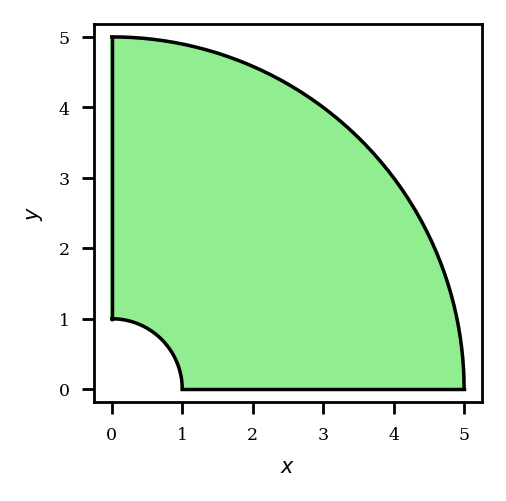

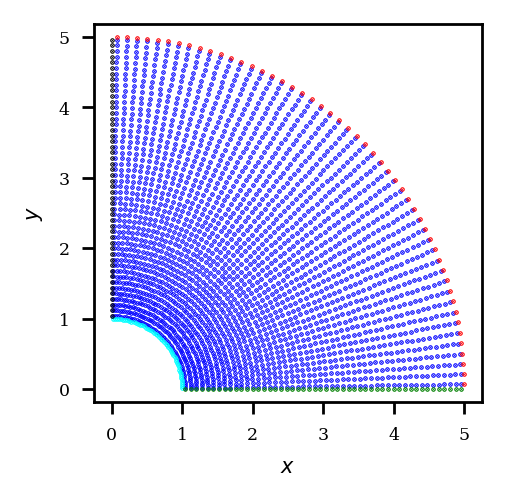

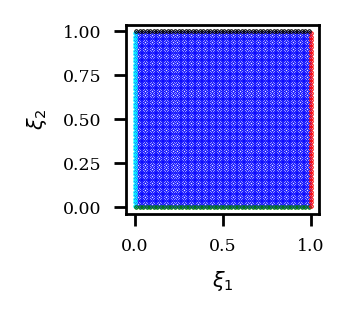

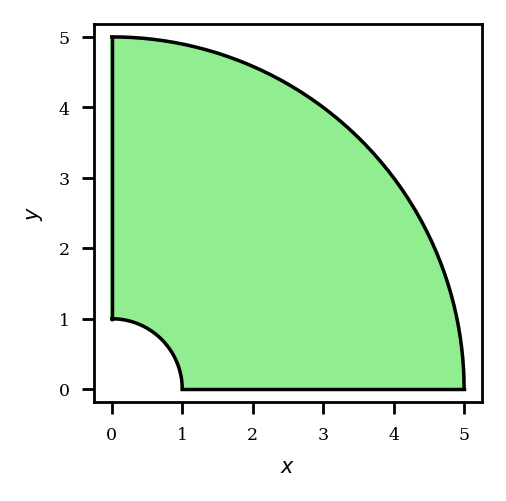

In [14]:
model_data = dict()
problem_param = dict()
realscale = 1e-3 # makes the result less sensitive w.r.t the small scale. Results will be given after unscaling.
problem_param['E'] = 135  # 135 * 1e-9 N/nm^2
problem_param['nu'] = 0.3
problem_param['lengthscale'] = 0.0 # 0.25 * 1e6 nm^2
problem_param['radInt'] = 1.0 # 1 * 1e3 nm
problem_param['radExt'] = 5.0 # 5 * 1e3 nm
problem_param['Pi'] = 10.0 # 10 * 1e-12 N/nm^2
problem_param['Po'] = 0.0 # 10 * 1e-12 N/nm^2
problem_param['scale_factor'] = realscale
# Domain bounds
problem_param['lb'] = np.array([0.0, 0.0])  # lower bound of the plate
problem_param['ub'] = np.array([problem_param['radExt'], problem_param['radExt']])  # Upper bound of the plate
NN_param = dict()
NN_param['layers'] = [2, 30, 30, 30, 2]
NN_param['iteration'] = 100
NN_param['learning_rate'] = 0.01

# Generating points inside the domain using GeometryIGA
myAnnulus = AnnulusISO(problem_param['radInt'], problem_param['radExt'])

numElemU = 50
numElemV = 50
numGauss = 1
# Generate the boundary points using Geometry class
numElemEdge = 50
numGaussEdge = 1

xyw_domain, xyw_inner, t_inner, xyw_outer, t_outer, xyw_left, xyw_right, xi_domain, dxidx_domain, xi_inner, xi_outer, xi_left, xi_right = \
gen_data_isodem_cylinder(problem_param, myAnnulus, numElemU, numElemV, numGauss, numElemEdge, numGaussEdge)

model_data['xy'] = xyw_domain
model_data['xi'] = xi_domain
model_data['dxidx'] = dxidx_domain
model_data['xy_boundary_in'] = xyw_inner
model_data['xi_boundary_in'] = xi_inner
model_data['traction_boundary_in'] = t_inner
model_data['xy_boundary_out'] = xyw_outer
model_data['xi_boundary_out'] = xi_outer
model_data['traction_boundary_out'] = t_outer
model_data['xy_boundary_left'] = xyw_left
model_data['xi_boundary_left'] = xi_left
model_data['xy_boundary_right'] = xyw_right
model_data['xi_boundary_right'] = xi_right


fig1 = plt.figure(figsize=(2, 2))
subfig1 = fig1.add_subplot(1, 1, 1)
subfig1.scatter(xyw_domain[:, 0:1], xyw_domain[:, 1:2], s=0.1, c='blue')
subfig1.scatter(xyw_inner[:, 0:1], xyw_inner[:, 1:2], s=0.1, c='cyan', zorder=10)
subfig1.scatter(xyw_right[:, 0:1], xyw_right[:, 1:2], s=0.1, c='green', zorder=10)
subfig1.scatter(xyw_outer[:, 0:1], xyw_outer[:, 1:2], s=0.1, c='red', zorder=10)
subfig1.scatter(xyw_left[:, 0:1], xyw_left[:, 1:2], s=0.1, c='black', zorder=10)
subfig1.set_xlabel(r'$x$')
subfig1.set_ylabel(r'$y$')
subfig1.axis('equal')
fig1.savefig(path_save_pic + '/physical_cylinder.eps', format='eps')  

fig2 = plt.figure(figsize=(1.0, 1.0))
subfig2 = fig2.add_subplot(1, 1, 1)
subfig2.scatter(xi_domain[:, 0:1], xi_domain[:, 1:2], s=0.1, c='blue')
subfig2.scatter(xi_inner[:, 0:1], xi_inner[:, 1:2], s=0.1, c='cyan')
subfig2.scatter(xi_right[:, 0:1], xi_right[:, 1:2], s=0.1, c='green')
subfig2.scatter(xi_outer[:, 0:1], xi_outer[:, 1:2], s=0.1, c='red')
subfig2.scatter(xi_left[:, 0:1], xi_left[:, 1:2], s=0.1, c='black')
subfig2.set_xlabel(r'$\xi_1$')
subfig2.set_ylabel(r'$\xi_2$')
subfig2.axis('equal')
fig2.savefig(path_save_pic +  '/isoparam_cylinder.eps', format='eps')
plt.show()

#  %%%%%%%%%%%%%% VALIDATION SET %%%%%%%%%%%%%% #
valnumElemU = 50
valnumElemV = 50
valnumGauss = 1
valnumElemEdge = 50
valnumGaussEdge = 1
val_xyw_domain, val_xyw_inner, val_t_inner, val_xyw_outer, val_t_outer, val_xyw__left, val_xyw_right, val_xi_domain, val_dxidx_domain, val_xi_inner, val_xi_outer, val_xi_left, val_xi_right = \
gen_data_isodem_cylinder(problem_param, myAnnulus, valnumElemU, valnumElemV, valnumGauss, valnumElemEdge, valnumGaussEdge)
model_data['val_xy'] = val_xyw_domain
model_data['val_xy_boundary_in'] = val_xyw_inner
model_data['val_traction_boundary_in'] = val_t_inner
model_data['val_xy_boundary_out'] = val_xyw_outer
model_data['val_traction_boundary_out'] = val_t_outer
model_data['val_xy_boundary_left'] = val_xyw__left
model_data['val_xy_boundary_right'] = val_xyw_right
#  %%%%%%%%%%%%%% END %%%%%%%%%%%%%% #
# -----------------------------


In [15]:
# # ----------------------------------------------------------------------
# #               TRAINING MODEL
# # ----------------------------------------------------------------------

mat = ISODEMEnergyModel('elasticity', 2, problem_param['E'], problem_param['nu'], problem_param['lengthscale'])

isodem_cylinder1_1 = ISODEMCYLINDER(NN_param['layers'], 'gauss', mat, 2, NN_param, network=False)

print(isodem_cylinder1_1.model)

start_time = time.time()
isodem_cylinder1_1.model.train()
isodem_cylinder1_1.train_model(model_data, problem_param)
end_time = time.time() - start_time
print("End time: %.5f" % end_time)
# -----------------------------

MultiLayerNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
  )
  (output): Linear(in_features=30, out_features=2, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
Iter: 1 Loss: 1.862766457e+01 - L2-error: 4.838202953e+00 - Energy-error: 3.711601613e+00 - Time: 3.000e-01
Iter: 1 Loss: 1.855501175e+01 - L2-error: 4.825360775e+00 - Energy-error: 3.704540182e+00 - Time: 1.934e-01
Iter: 1 Loss: 1.823830795e+01 - L2-error: 4.772979736e+00 - Energy-error: 3.674280868e+00 - Time: 2.081e-01
Iter: 1 Loss: 1.789789581e+01 - L2-error: 4.718807220e+00 - Energy-error: 3.641958716e+00 - Time: 1.931e-01
Iter: 1 Loss: 1.753853989e+01 - L2-error: 4.662925720e+00 - Energy-error: 3.607865176e+00 - Time: 2.155e-01
Iter: 1 Loss: 1.716060257e+01 - L2-error: 4.604918957e+00 - Energy-error: 3.571905324e+00 - Time: 2.044e-01
Iter: 1 Loss: 1.

## with transfer learning n = 50

In [16]:
# # ----------------------------------------------------------------------
# #               TRANSFER LEARNING APPLIED
# # ----------------------------------------------------------------------
NN_param['iteration'] = 100
NN_param['learning_rate'] = 0.01

mat = ISODEMEnergyModel('elasticity', 2, problem_param['E'], problem_param['nu'], problem_param['lengthscale'])

isodem_cylinder2_1 = ISODEMCYLINDER(NN_param['layers'], 'gauss', mat, 2, NN_param, network=True)

# # Free mlp1 parameters
# for param in isodem_cylinder2.model.parameters():
#     param.requires_grad = False
#     print(param)

# isodem_cylinder2.model.mlp2 = nn.Sequential(
#             nn.Linear(30, 100),
#             nn.Tanh(),
#             nn.Linear(100, 100),
#             nn.Tanh(),
#             nn.Linear(100, 30),
#             nn.Tanh()
#         )
# for param in isodem_cylinder2.model.parameters():
# #     param.requires_grad = False
#     print(param)
    
# print(isodem_cylinder2.model)

# isodem_cylinder2.optimizer = torch.optim.LBFGS(isodem_cylinder2.model.mlp2.parameters(), lr=isodem_cylinder2.learning_rate_lbfgs, max_iter=20)

start_time = time.time()
isodem_cylinder2_1.model.train()
isodem_cylinder2_1.train_model(model_data, problem_param)
end_time = time.time() - start_time
print("End time: %.5f" % end_time)
# -----------------------------

Iter: 1 Loss: 1.403364372e+01 - L2-error: 3.594815969e+00 - Energy-error: 3.290933101e+00 - Time: 2.055e-01
Iter: 1 Loss: 1.393322468e+01 - L2-error: 3.577208996e+00 - Energy-error: 3.279868645e+00 - Time: 2.062e-01
Iter: 1 Loss: 1.374080753e+01 - L2-error: 3.541691542e+00 - Energy-error: 3.258503753e+00 - Time: 2.009e-01
Iter: 1 Loss: 1.351554680e+01 - L2-error: 3.499541998e+00 - Energy-error: 3.233307774e+00 - Time: 2.243e-01
Iter: 1 Loss: 1.327464390e+01 - L2-error: 3.454797268e+00 - Energy-error: 3.206165160e+00 - Time: 2.366e-01
Iter: 1 Loss: 1.302624130e+01 - L2-error: 3.409424305e+00 - Energy-error: 3.177956826e+00 - Time: 2.043e-01
Iter: 1 Loss: 1.277429581e+01 - L2-error: 3.364197493e+00 - Energy-error: 3.149095196e+00 - Time: 1.944e-01
Iter: 1 Loss: 1.252106094e+01 - L2-error: 3.319363117e+00 - Energy-error: 3.119807453e+00 - Time: 1.947e-01
Iter: 1 Loss: 1.226795673e+01 - L2-error: 3.274971724e+00 - Energy-error: 3.090237851e+00 - Time: 1.914e-01
Iter: 1 Loss: 1.201586151e+0

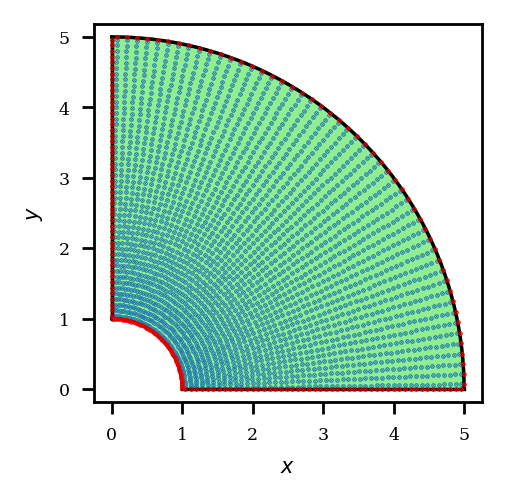

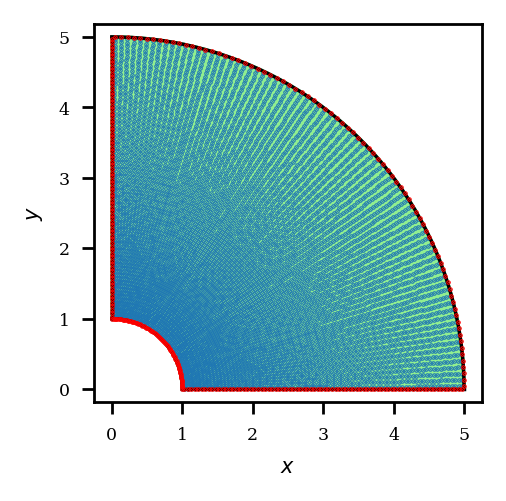

Iter: 1 Loss: 1.679081421e+03 - Validation Loss: 1.679051392e+03 - L2-error: 3.840003967e+01 - Energy-error: 3.076362981e+01 - Time: 2.173e-01
Iter: 1 Loss: 1.673359131e+03 - Validation Loss: 1.673329346e+03 - L2-error: 3.833129883e+01 - Energy-error: 3.071087369e+01 - Time: 1.969e-01
Iter: 1 Loss: 1.642045288e+03 - Validation Loss: 1.642015991e+03 - L2-error: 3.795205688e+01 - Energy-error: 3.042126210e+01 - Time: 1.980e-01
Iter: 1 Loss: 1.608143799e+03 - Validation Loss: 1.608114990e+03 - L2-error: 3.753824997e+01 - Energy-error: 3.010496057e+01 - Time: 1.950e-01
Iter: 1 Loss: 1.571210815e+03 - Validation Loss: 1.571182861e+03 - L2-error: 3.708378601e+01 - Energy-error: 2.975679709e+01 - Time: 1.976e-01
Iter: 1 Loss: 1.530091553e+03 - Validation Loss: 1.530064453e+03 - L2-error: 3.657285309e+01 - Energy-error: 2.936451655e+01 - Time: 1.975e-01
Iter: 1 Loss: 1.482982910e+03 - Validation Loss: 1.482956665e+03 - L2-error: 3.598031998e+01 - Energy-error: 2.890876324e+01 - Time: 2.060e-01

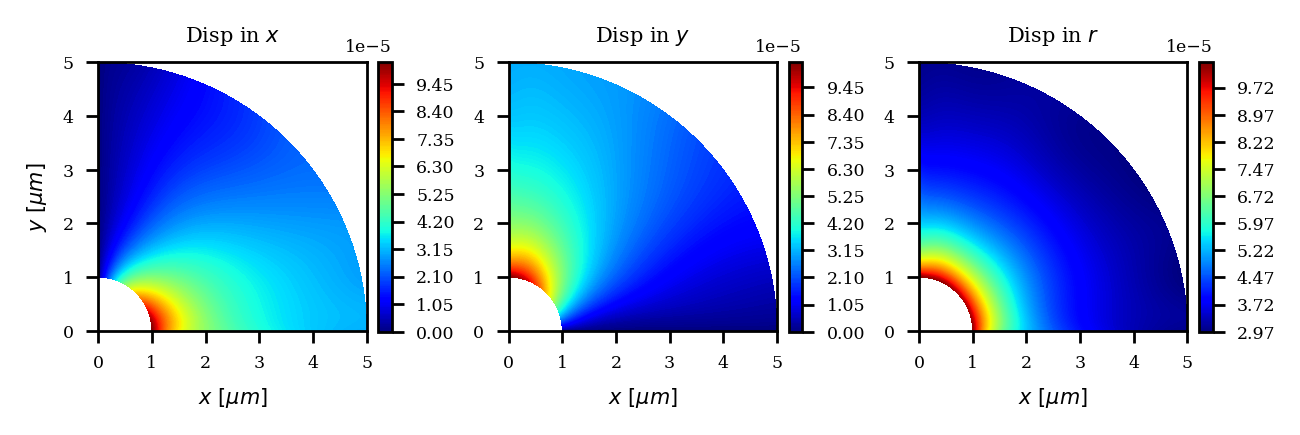

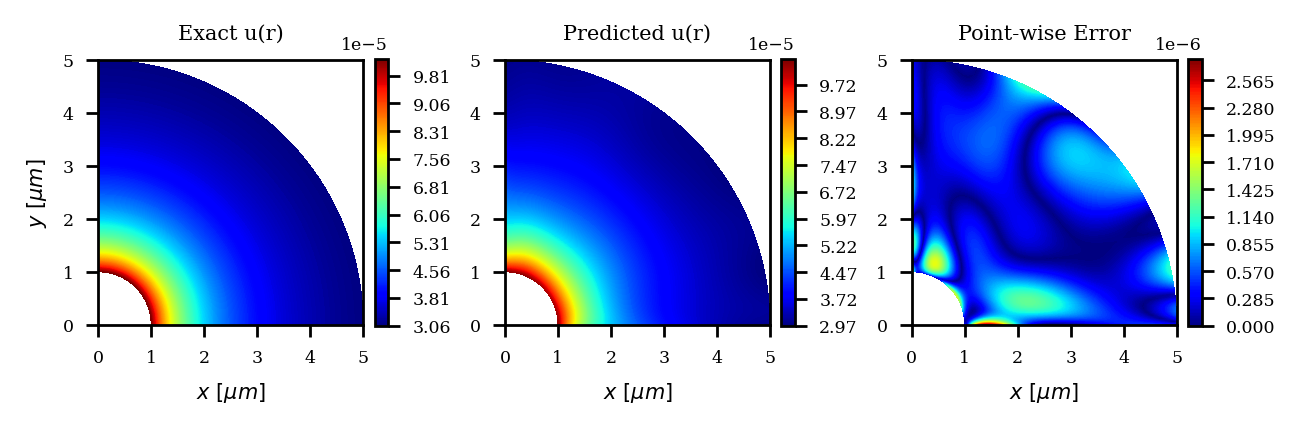

Relative L2 error:  0.008541837932800635


In [17]:
class Geometry2D:
    '''
     Base class for 2D domains
     Input: geomData - dictionary containing the geomety information
     Keys: degree_u, degree_v: polynomial degree in the u and v directions
       ctrlpts_size_u, ctrlpts_size_v: number of control points in u,v directions
       ctrlpts: weighted control points (in a list with
            ctrlpts_size_u*ctrlpts_size_v rows and 3 columns for x,y,z coordinates)
       weights: correspond weights (list with ctrlpts_size_u*ctrlpts_size_v entries)
       knotvector_u, knotvector_v: knot vectors in the u and v directions
    '''

    def __init__(self, geomData):
        self.surf = NURBS.Surface()
        self.surf.degree_u = geomData['degree_u']
        self.surf.degree_v = geomData['degree_v']
        self.surf.ctrlpts_size_u = geomData['ctrlpts_size_u']
        self.surf.ctrlpts_size_v = geomData['ctrlpts_size_v']
        self.surf.ctrlpts = self.getUnweightedCpts(geomData['ctrlpts'],
                                                   geomData['weights'])
        self.surf.weights = geomData['weights']
        self.surf.knotvector_u = geomData['knotvector_u']
        self.surf.knotvector_v = geomData['knotvector_v']

    def getUnweightedCpts(self, ctrlpts, weights):
        numCtrlPts = np.shape(ctrlpts)[0]
        PctrlPts = np.zeros_like(ctrlpts)
        for i in range(3):
            for j in range(numCtrlPts):
                PctrlPts[j, i] = ctrlpts[j][i] / weights[j]
        PctrlPts = PctrlPts.tolist()
        return PctrlPts

    def mapPoints(self, uPar, vPar):
        '''
        Map points from the parameter domain [0,1]x[0,1] to the quadrilater domain
        Input:  uPar - array containing the u-coordinates in the parameter space
                vPar - array containing the v-coordinates in the parameter space
                Note: the arrays uPar and vPar must be of the same size
        Output: xPhys - array containing the x-coordinates in the physical space
                yPhys - array containing the y-coordinates in the physical space
        '''
        gpParamUV = np.array([uPar, vPar])
        evalList = tuple(map(tuple, gpParamUV.transpose()))
        res = np.array(self.surf.evaluate_list(evalList))

        return res

    def getUnifIntPts(self, numPtsU, numPtsV, withEdges):
        '''
        Generate uniformly spaced points inside the domain
        Input: numPtsU, numPtsV - number of points (including edges) in the u and v
                   directions in the parameter space
               withEdges - 1x4 array of zeros or ones specifying whether the boundary points
                           should be included. The boundary order is [bottom, right,
                           top, left] for the unit square.
        Output: xM, yM - flattened array containing the x and y coordinates of the points
        '''
        # generate points in the x direction on the interval [0,1]
        uEdge = np.linspace(0, 1, numPtsU)
        vEdge = np.linspace(0, 1, numPtsV)

        # remove endpoints depending on values of withEdges
        if withEdges[0] == 0:
            vEdge = vEdge[1:]
        if withEdges[1] == 0:
            uEdge = uEdge[:-1]
        if withEdges[2] == 0:
            vEdge = vEdge[:-1]
        if withEdges[3] == 0:
            uEdge = uEdge[1:]

        # create meshgrid
        uPar, vPar = np.meshgrid(uEdge, vEdge)

        uPar = uPar.flatten()
        vPar = vPar.flatten()
        # map points
        res = self.mapPoints(uPar.T, vPar.T)

        xPhys = res[:, 0:1]
        yPhys = res[:, 1:2]

        return xPhys, yPhys

    def getQuadIntPts(self, numElemU, numElemV, numGauss):
        '''
        Generate quadrature points inside the domain
        Input: numElemU, numElemV - number of subdivisions in the u and v
                   directions in the parameter space
               numGauss - number of Gauss quadrature points for each subdivision
        Output: xPhys, yPhys, wgtPhy - arrays containing the x and y coordinates
                                    of the points and the corresponding weights
        '''
        # allocate quadPts array
        quadPts = np.zeros((numElemU * numElemV * numGauss ** 2, 3))

        # get the Gauss points on the reference interval [-1,1]
        gp, gw = np.polynomial.legendre.leggauss(numGauss)

        # get the Gauss weights on the reference element [-1, 1]x[-1,1]
        gpWeightU, gpWeightV = np.meshgrid(gw, gw)
        gpWeightUV = np.array(gpWeightU.flatten() * gpWeightV.flatten())

        # generate the knots on the interval [0,1]
        uEdge = np.linspace(0, 1, numElemU + 1)
        vEdge = np.linspace(0, 1, numElemV + 1)

        # create meshgrid
        uPar, vPar = np.meshgrid(uEdge, vEdge)

        # generate points for each element
        indexPt = 0
        for iV in range(numElemV):
            for iU in range(numElemU):
                uMin = uPar[iV, iU]
                uMax = uPar[iV, iU + 1]
                vMin = vPar[iV, iU]
                vMax = vPar[iV + 1, iU]
                gpParamU = (uMax - uMin) / 2 * gp + (uMax + uMin) / 2
                gpParamV = (vMax - vMin) / 2 * gp + (vMax + vMin) / 2
                gpParamUg, gpParamVg = np.meshgrid(gpParamU, gpParamV)
                gpParamUV = np.array([gpParamUg.flatten(), gpParamVg.flatten()])
                # Jacobian of the transformation from the reference element [-1,1]x[-1,1]
                scaleFac = (uMax - uMin) * (vMax - vMin) / 4

                # map the points to the physical space
                for iPt in range(numGauss ** 2):
                    curPtU = gpParamUV[0, iPt]
                    curPtV = gpParamUV[1, iPt]
                    derivMat = self.surf.derivatives(curPtU, curPtV, order=1)
                    physPtX = derivMat[0][0][0]
                    physPtY = derivMat[0][0][1]
                    derivU = derivMat[1][0][0:2]
                    derivV = derivMat[0][1][0:2]
                    JacobMat = np.array([derivU, derivV])
                    detJac = np.linalg.det(JacobMat)
                    quadPts[indexPt, 0] = physPtX
                    quadPts[indexPt, 1] = physPtY
                    quadPts[indexPt, 2] = scaleFac * detJac * gpWeightUV[iPt]
                    indexPt = indexPt + 1

        xPhys = quadPts[:, 0:1]
        yPhys = quadPts[:, 1:2]
        wgtPhys = quadPts[:, 2:3]

        return xPhys, yPhys, wgtPhys

    def getUnweightedCpts2d(self, ctrlpts2d, weights):
        numCtrlPtsU = np.shape(ctrlpts2d)[0]
        numCtrlPtsV = np.shape(ctrlpts2d)[1]
        PctrlPts = np.zeros([numCtrlPtsU, numCtrlPtsV, 3])
        counter = 0
        for j in range(numCtrlPtsU):
            for k in range(numCtrlPtsV):
                for i in range(3):
                    PctrlPts[j, k, i] = ctrlpts2d[j][k][i] / weights[counter]
                counter = counter + 1
        PctrlPts = PctrlPts.tolist()
        return PctrlPts

    def plotSurf(self):
        # plots the NURBS/B-Spline surface and the control points in 2D
        fig, ax = plt.subplots(size=(2, 1))
        patches = []

        # get the number of points in the u and v directions
        numPtsU = np.int(1 / self.surf.delta[0])
        numPtsV = np.int(1 / self.surf.delta[1])

        for j in range(numPtsV):
            for i in range(numPtsU):
                # get the index of point in the lower left corner of the visualization element
                indexPtSW = j * (numPtsU + 1) + i
                indexPtSE = indexPtSW + 1
                indexPtNE = indexPtSW + numPtsU + 2
                indexPtNW = indexPtSW + numPtsU + 1
                XYPts = np.array(self.surf.evalpts)[[indexPtSW, indexPtSE,
                                                     indexPtNE, indexPtNW], 0:2]
                poly = mpatches.Polygon(XYPts)
                patches.append(poly)

        collection = PatchCollection(patches, color="lightgreen", cmap=plt.cm.hsv, alpha=1)
        ax.add_collection(collection)

        numCtrlPtsU = self.surf._control_points_size[0]
        numCtrlPtsV = self.surf._control_points_size[1]
        ctrlpts = self.getUnweightedCpts2d(self.surf.ctrlpts2d, self.surf.weights)
        # plot the horizontal lines
        for j in range(numCtrlPtsU):
            plt.plot(np.array(ctrlpts)[j, :, 0], np.array(ctrlpts)[j, :, 1], ls='--', color='black')
        # plot the vertical lines
        for i in range(numCtrlPtsV):
            plt.plot(np.array(ctrlpts)[:, i, 0], np.array(ctrlpts)[:, i, 1], ls='--', color='black')
        # plot the control points
        plt.scatter(np.array(self.surf.ctrlpts)[:, 0], np.array(self.surf.ctrlpts)[:, 1], color='red', zorder=10)
        plt.axis('equal')

    def plotKntSurf(self):
        # plots the NURBS/B-Spline surface and the knot lines in 2D
        fig, ax = plt.subplots(figsize=(2,2))
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        patches = []

        # get the number of points in the u and v directions
        self.surf.delta = 0.02
        self.surf.evaluate()
        numPtsU = np.int(1 / self.surf.delta[0])
        numPtsV = np.int(1 / self.surf.delta[1])

        for j in range(numPtsV):
            for i in range(numPtsU):
                # get the index of point in the lower left corner of the visualization element
                indexPtSW = j * (numPtsU + 1) + i
                indexPtSE = indexPtSW + 1
                indexPtNE = indexPtSW + numPtsU + 2
                indexPtNW = indexPtSW + numPtsU + 1
                XYPts = np.array(self.surf.evalpts)[[indexPtSW, indexPtSE, indexPtNE, indexPtNW], 0:2]
                poly = mpatches.Polygon(XYPts)
                patches.append(poly)

        collection = PatchCollection(patches, color="lightgreen", cmap=plt.cm.hsv, alpha=1)
        ax.add_collection(collection)

        # plot the horizontal knot lines
        for j in np.unique(self.surf.knotvector_u):
            vVal = np.linspace(0, 1, numPtsV)
            uVal = np.ones(numPtsV) * j
            uvVal = np.array([uVal, vVal])

            evalList = tuple(map(tuple, uvVal.transpose()))
            res = np.array(self.surf.evaluate_list(evalList))
            plt.plot(res[:, 0], res[:, 1], ls='-', linewidth=1, color='black')

        # plot the vertical lines
        for i in np.unique(self.surf.knotvector_v):
            uVal = np.linspace(0, 1, numPtsU)
            vVal = np.ones(numPtsU) * i
            uvVal = np.array([uVal, vVal])

            evalList = tuple(map(tuple, uvVal.transpose()))
            res = np.array(self.surf.evaluate_list(evalList))
            plt.plot(res[:, 0], res[:, 1], ls='-', linewidth=1, color='black')

        plt.axis('equal')

    def getQuadEdgePts(self, numElem, numGauss, orient):
        '''
        Generate points on the boundary edge given by orient
        Input: numElem - number of number of subdivisions (in the v direction)
               numGauss - number of Gauss points per subdivision
               orient - edge orientation in parameter space: 1 is down (v=0),
                        2 is left (u=1), 3 is top (v=1), 4 is right (u=0)
        Output: xBnd, yBnd, wgtBnd - coordinates of the boundary in the physical
                                     space and the corresponding weights
                xNorm, yNorm  - x and y component of the outer normal vector
        '''
        # allocate quadPts array
        quadPts = np.zeros((numElem * numGauss, 5))

        # get the Gauss points on the reference interval [-1,1]
        gp, gw = np.polynomial.legendre.leggauss(numGauss)

        # generate the knots on the interval [0,1]
        edgePar = np.linspace(0, 1, numElem + 1)

        # generate points for each element
        indexPt = 0
        for iE in range(numElem):
            edgeMin = edgePar[iE]
            edgeMax = edgePar[iE + 1]
            if orient == 1:
                gpParamU = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
                gpParamV = np.zeros_like(gp)
            elif orient == 2:
                gpParamU = np.ones_like(gp)
                gpParamV = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
            elif orient == 3:
                gpParamU = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
                gpParamV = np.ones_like(gp)
            elif orient == 4:
                gpParamU = np.zeros_like(gp)
                gpParamV = (edgeMax - edgeMin) / 2 * gp + (edgeMax + edgeMin) / 2
            else:
                raise Exception('Wrong orientation given')

            gpParamUV = np.array([gpParamU.flatten(), gpParamV.flatten()])

            # Jacobian of the transformation from the reference element [-1,1]
            scaleFac = (edgeMax - edgeMin) / 2

            # map the points to the physical space
            for iPt in range(numGauss):
                curPtU = gpParamUV[0, iPt]
                curPtV = gpParamUV[1, iPt]
                derivMat = self.surf.derivatives(curPtU, curPtV, order=1)
                physPtX = derivMat[0][0][0]
                physPtY = derivMat[0][0][1]
                derivU = derivMat[1][0][0:2]
                derivV = derivMat[0][1][0:2]
                JacobMat = np.array([derivU, derivV])
                if orient == 1:
                    normX = JacobMat[0, 1]
                    normY = -JacobMat[0, 0]
                elif orient == 2:
                    normX = JacobMat[1, 1]
                    normY = -JacobMat[1, 0]
                elif orient == 3:
                    normX = -JacobMat[0, 1]
                    normY = JacobMat[0, 0]
                elif orient == 4:
                    normX = -JacobMat[1, 1]
                    normY = JacobMat[1, 0]
                else:
                    raise Exception('Wrong orientation given')

                JacobEdge = np.sqrt(normX ** 2 + normY ** 2)
                normX = normX / JacobEdge
                normY = normY / JacobEdge

                quadPts[indexPt, 0] = physPtX
                quadPts[indexPt, 1] = physPtY
                quadPts[indexPt, 2] = normX
                quadPts[indexPt, 3] = normY
                quadPts[indexPt, 4] = scaleFac * JacobEdge * gw[iPt]
                indexPt = indexPt + 1

        xPhys = quadPts[:, 0:1]
        yPhys = quadPts[:, 1:2]
        xNorm = quadPts[:, 2:3]
        yNorm = quadPts[:, 3:4]
        wgtPhys = quadPts[:, 4:5]

        return xPhys, yPhys, xNorm, yNorm, wgtPhys


class Annulus(Geometry2D):
    """
     Class for definining a quarter-annulus domain centered at the orgin
         (the domain is in the first quadrant)
     Input: rad_int, rad_ext - internal and external radii of the annulus
    """

    def __init__(self, radInt, radExt):
        geomData = dict()

        # Set degrees
        geomData['degree_u'] = 1
        geomData['degree_v'] = 2

        # Set control points
        geomData['ctrlpts_size_u'] = 2
        geomData['ctrlpts_size_v'] = 3

        geomData['ctrlpts'] = [[radInt, 0., 0.],
                               [radInt * np.sqrt(2) / 2, radInt * np.sqrt(2) / 2, 0.],
                               [0., radInt, 0.],
                               [radExt, 0., 0.],
                               [radExt * np.sqrt(2) / 2, radExt * np.sqrt(2) / 2, 0.],
                               [0., radExt, 0.]]

        geomData['weights'] = [1, np.sqrt(2) / 2, 1, 1, np.sqrt(2) / 2, 1]

        # Set knot vectors
        geomData['knotvector_u'] = [0.0, 0.0, 1.0, 1.0]
        geomData['knotvector_v'] = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0]

        super().__init__(geomData)


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Energy model %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
class EnergyModel:
    # ---------------------------------------------------------------------------------------------------------------------------
    def __init__(self, energy, dim, E=None, nu=None, c=None):
        self.type = energy
        self.dim = dim
        self.E = E
        self.nu = nu
        self.mu = E / (2 * (1 + nu))
        self.lam = (E * nu) / ((1 + nu) * (1 - 2 * nu))
        if self.type == 'straingradient' or self.type == 'straingradientrphi':
            self.c = c

    def linear_elasticity(self, u, xy):
        du1_dxy = grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        du2_dxy = grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        eps11 = du1_dxy[:, 0]
        eps12 = 0.5 * (du1_dxy[:, 1] + du2_dxy[:, 0])
        eps21 = 0.5 * (du2_dxy[:, 0] + du1_dxy[:, 1])
        eps22 = du2_dxy[:, 1]
        traceEps = eps11 + eps22

        self.c11 = self.E / (1 - self.nu ** 2)
        self.c22 = self.E / (1 - self.nu ** 2)
        self.c12 = self.E * self.nu / (1 - self.nu ** 2)
        self.c21 = self.E * self.nu / (1 - self.nu ** 2)
        self.c31 = 0.0
        self.c32 = 0.0
        self.c13 = 0.0
        self.c23 = 0.0
        self.c33 = self.E / (2 * (1 + self.nu))
        sig11 = self.c11 * eps11 + self.c12 * eps22
        sig22 = self.c21 * eps11 + self.c22 * eps22
        sig12 = self.c33 * 2 * eps12
        
        sigma = torch.cat((sig11.unsqueeze(1), sig22.unsqueeze(1), sig12.unsqueeze(1)), 1)
        epsilon = torch.cat((eps11.unsqueeze(1), eps22.unsqueeze(1), (eps12*2).unsqueeze(1)), 1)
        
#         print(sig11)
        energy = 0.5 * (sig11 * eps11 + sig22 * eps22 + 2 * sig12 * eps12)
        return energy, sigma, epsilon
        
    def getGraduBoundary(self, u, xy):
#         print('uxy = ', u)
#         print('xy = ', xy)
        duy_dxy = \
            grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
#         print('duy_dxy = ', duy_dxy)
        dux_dxy = \
            grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
#         print('dux_dxy = ', dux_dxy)
        return duy_dxy[:, 0], dux_dxy[:, 1]

    def getBCRight(self, u, xy):
        dux_dxy = \
            grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
        duy_dxy = \
            grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True,
                 retain_graph=True)[0]
        return dux_dxy[:, 1], duy_dxy[:, 0]

    def getStrainGradient2D(self, u, xy):
        du1_dxy = grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        du2_dxy = grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        eps11 = du1_dxy[:, 0]
        eps12 = 0.5 * (du1_dxy[:, 1] + du2_dxy[:, 0])
        eps21 = 0.5 * (du2_dxy[:, 0] + du1_dxy[:, 1])
        eps22 = du2_dxy[:, 1]
        traceEps = eps11 + eps22
        tau11 = self.lam * traceEps + 2 * self.mu * eps11
        tau12 = 2 * self.mu * eps12
        tau21 = 2 * self.mu * eps21
        tau22 = self.lam * traceEps + 2 * self.mu * eps22
        deps11_dxy = grad(eps11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps12_dxy = grad(eps12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps21_dxy = grad(eps21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps22_dxy = grad(eps22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        kappa111 = deps11_dxy[:, 0]
        kappa112 = deps11_dxy[:, 1]
        kappa121 = deps12_dxy[:, 0]
        kappa122 = deps12_dxy[:, 1]
        kappa211 = deps21_dxy[:, 0]
        kappa212 = deps21_dxy[:, 1]
        kappa221 = deps22_dxy[:, 0]
        kappa222 = deps22_dxy[:, 1]
        dtau11_dxy = grad(tau11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau12_dxy = grad(tau12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau21_dxy = grad(tau21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau22_dxy = grad(tau22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        mu111 = self.c * dtau11_dxy[:, 0]
        mu112 = self.c * dtau11_dxy[:, 1]
        mu121 = self.c * dtau12_dxy[:, 0]
        mu122 = self.c * dtau12_dxy[:, 1]
        mu211 = self.c * dtau21_dxy[:, 0]
        mu212 = self.c * dtau21_dxy[:, 1]
        mu221 = self.c * dtau22_dxy[:, 0]
        mu222 = self.c * dtau22_dxy[:, 1]
        strainEnergy = 0.5 * ((tau11 * eps11 + tau12 * eps12 + tau21 * eps21 + tau22 * eps22) + (
            mu111 * kappa111 + mu112 * kappa112 + mu121 * kappa121 + mu122 * kappa122 + mu211 * kappa211 + mu212 * kappa212 + mu221 * kappa221 + mu222 * kappa222))
        return strainEnergy
    
    def get_stress_strain(self, u, xy):
#     xy_tensor = torch.from_numpy(xy).float()
#     xy_tensor = xy_tensor.to(dev)
#     xy_tensor = requires_grad_(True)
#     u_pred_torch = self.getU(xy_tensor)
#     duxdxy = grad(u_pred_torch[:, 0].unsqueeze(1), xy_tensor, torch.ones(xy_tensor.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
#     duydxy = grad(u_pred_torch[:, 1].unsqueeze(1), xy_tensor, torch.ones(xy_tensor.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
    
        du1_dxy = grad(u[:, 0].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        du2_dxy = grad(u[:, 1].unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        eps11 = du1_dxy[:, 0]
        eps12 = 0.5 * (du1_dxy[:, 1] + du2_dxy[:, 0])
        eps21 = 0.5 * (du2_dxy[:, 0] + du1_dxy[:, 1])
        eps22 = du2_dxy[:, 1]
        traceEps = eps11 + eps22
        tau11 = self.lam * traceEps + 2 * self.mu * eps11
        tau12 = 2 * self.mu * eps12
        tau21 = 2 * self.mu * eps21
        tau22 = self.lam * traceEps + 2 * self.mu * eps22
        deps11_dxy = grad(eps11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps12_dxy = grad(eps12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps21_dxy = grad(eps21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        deps22_dxy = grad(eps22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        kappa111 = deps11_dxy[:, 0]
        kappa112 = deps11_dxy[:, 1]
        kappa121 = deps12_dxy[:, 0]
        kappa122 = deps12_dxy[:, 1]
        kappa211 = deps21_dxy[:, 0]
        kappa212 = deps21_dxy[:, 1]
        kappa221 = deps22_dxy[:, 0]
        kappa222 = deps22_dxy[:, 1]
        dtau11_dxy = grad(tau11.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau12_dxy = grad(tau12.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau21_dxy = grad(tau21.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dtau22_dxy = grad(tau22.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        mu111 = self.c * dtau11_dxy[:, 0]
        mu112 = self.c * dtau11_dxy[:, 1]
        mu121 = self.c * dtau12_dxy[:, 0]
        mu122 = self.c * dtau12_dxy[:, 1]
        mu211 = self.c * dtau21_dxy[:, 0]
        mu212 = self.c * dtau21_dxy[:, 1]
        mu221 = self.c * dtau22_dxy[:, 0]
        mu222 = self.c * dtau22_dxy[:, 1]

        dmu111_dxy = grad(mu111.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu112_dxy = grad(mu112.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu121_dxy = grad(mu121.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu122_dxy = grad(mu122.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu211_dxy = grad(mu211.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu212_dxy = grad(mu212.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu221_dxy = grad(mu221.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        dmu222_dxy = grad(mu222.unsqueeze(1), xy, torch.ones(xy.size()[0], 1, device=dev), create_graph=True, retain_graph=True)[0]
        sigma11 = tau11 - (dmu111_dxy[:, 0] + dmu112_dxy[:, 1])
        sigma12 = tau12 - (dmu121_dxy[:, 0] + dmu122_dxy[:, 1])
        sigma21 = tau21 - (dmu211_dxy[:, 0] + dmu212_dxy[:, 1])
        sigma22 = tau22 - (dmu221_dxy[:, 0] + dmu222_dxy[:, 1])

        Phi = torch.atan(xy[:, 1] / xy[:, 0])
        cosPhi = torch.cos(Phi)
        sinPhi = torch.sin(Phi)
        Srr = (cosPhi ** 2) * sigma11 + (sinPhi ** 2) * sigma22 + (sinPhi * cosPhi) * (sigma12 + sigma21)
        Spp = (sinPhi ** 2) * sigma11 + (cosPhi ** 2) * sigma22 - (sinPhi * cosPhi) * (sigma12 + sigma21)
        
        taurr = (cosPhi ** 2) * tau11 + (sinPhi ** 2) * tau22 + (sinPhi * cosPhi) * (tau12 + tau21)
        taupp = (sinPhi ** 2) * tau11 + (cosPhi ** 2) * tau22 - (sinPhi * cosPhi) * (tau12 + tau21)
        epsrr = (cosPhi ** 2) * eps11 + (sinPhi ** 2) * eps22 + (sinPhi * cosPhi) * (eps12 + eps21)
        epspp = (sinPhi ** 2) * eps11 + (cosPhi ** 2) * eps22 - (sinPhi * cosPhi) * (eps12 + eps21)
        
    #     strainEnergy = 0.5 * ((tau11 * eps11 + tau12 * eps12 + tau21 * eps21 + tau22 * eps22) 
    #                    + (mu111 * kappa111 + mu112 * kappa112 + mu121 * kappa121 + mu122 * kappa122 + mu211 * kappa211 + mu212 * kappa212 + mu221 * kappa221 + mu222 * kappa222))

        return taurr, taupp, epsrr, epspp

def u_exact(P, E, nu, ro, ri, r):
    return (ri **2 * P * r) / (E * (ro**2 - ri**2)) * (1 - nu + (ro/r)**2 * (1 + nu))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Deep energy method %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
class DeepEnergyMethod:
    # Instance attributes
    def __init__(self, layers, numIntType, energy, dim, network=False):
        # self.data = data
        if network == False:
            self.model = MultiLayerNet(layers)
        else:
            state_dict = torch.load('dem_AdvNN_v1_thickwall_straingrad_xy_checkpoint.pth', map_location=torch.device('cpu'))
#             print(state_dict.keys())
            # Try this
            print("Transfer learning")
            self.model = MultiLayerNet(layers)
            # This will throw an error because the tensor sizes are wrong!
            self.model.load_state_dict(state_dict)
            self.model = self.model.to(dev)
#         self.intLoss = IntegrationLoss(numIntType, dim)
        self.energy = energy
        # self.post = PostProcessing(energy, dim)
        self.dim = dim
        self.lossArray = []
        self.valLossArray = []
        self.l2errorArray = []
        self.enerrorArray = []

    def train_model(self, data, nn_param, problem_param):
        # ---------- training data ---------------#
        xy_domain = data['xy']

        xy_boundary_in = data['xy_boundary_in']
        traction_boundary_in = data['traction_boundary_in']

        xy_boundary_out = data['xy_boundary_out']
        traction_boundary_out = data['traction_boundary_out']

        xy_boundary_left = data['xy_boundary_left']
        xy_boundary_right = data['xy_boundary_right']

        xy = torch.from_numpy(xy_domain[:, 0:2]).float()
        xy = xy.to(dev)
        xy.requires_grad_(True)
        weightXY = torch.from_numpy(xy_domain[:, 2]).float()
        weightXY = weightXY.to(dev)

        xyIn = torch.from_numpy(xy_boundary_in[:, 0:2]).float()
        xyIn = xyIn.to(dev)
        xyIn.requires_grad_(True)
        weightXYBoundI = torch.from_numpy(xy_boundary_in[:, 2:3]).float()
        weightXYBoundI = weightXYBoundI.to(dev)

        xyOut = torch.from_numpy(xy_boundary_out[:, 0:2]).float()
        xyOut = xyOut.to(dev)
        xyOut.requires_grad_(True)
        weightXYBoundO = torch.from_numpy(xy_boundary_out[:, 2:3]).float()
        weightXYBoundO = weightXYBoundO.to(dev)

        xyLeft = torch.from_numpy(xy_boundary_left[:, 0:2]).float()
        xyLeft = xyLeft.to(dev)
        xyLeft.requires_grad_(True)

        xyRight = torch.from_numpy(xy_boundary_right[:, 0:2]).float()
        xyRight = xyRight.to(dev)
        xyRight.requires_grad_(True)

        inner_t = torch.from_numpy(traction_boundary_in).float().to(dev)
        outer_t = torch.from_numpy(traction_boundary_out).float().to(dev)

        # ---------- validation data ---------------#
        
        val_xy_domain = data['val_xy']

        val_xy_boundary_in = data['val_xy_boundary_in']
        val_traction_boundary_in = data['val_traction_boundary_in']

        val_xy_boundary_out = data['val_xy_boundary_out']
        val_traction_boundary_out = data['val_traction_boundary_out']

        val_xy_boundary_left = data['val_xy_boundary_left']
        val_xy_boundary_right = data['val_xy_boundary_right']

        val_xy = torch.from_numpy(val_xy_domain[:, 0:2]).float()
        val_xy = val_xy.to(dev)
        val_xy.requires_grad_(True)
        val_weightXY = torch.from_numpy(val_xy_domain[:, 2]).float()
        val_weightXY = val_weightXY.to(dev)

        val_xyIn = torch.from_numpy(val_xy_boundary_in[:, 0:2]).float()
        val_xyIn = val_xyIn.to(dev)
        val_xyIn.requires_grad_(True)
        val_weightXYBoundI = torch.from_numpy(val_xy_boundary_in[:, 2:3]).float()
        val_weightXYBoundI = val_weightXYBoundI.to(dev)

        val_xyOut = torch.from_numpy(val_xy_boundary_out[:, 0:2]).float()
        val_xyOut = val_xyOut.to(dev)
        val_xyOut.requires_grad_(True)
        val_weightXYBoundO = torch.from_numpy(val_xy_boundary_out[:, 2:3]).float()
        val_weightXYBoundO = val_weightXYBoundO.to(dev)

        val_xyLeft = torch.from_numpy(val_xy_boundary_left[:, 0:2]).float()
        val_xyLeft = val_xyLeft.to(dev)
        val_xyLeft.requires_grad_(True)

        val_xyRight = torch.from_numpy(val_xy_boundary_right[:, 0:2]).float()
        val_xyRight = val_xyRight.to(dev)
        val_xyRight.requires_grad_(True)

        val_inner_t = torch.from_numpy(val_traction_boundary_in).float().to(dev)
        val_outer_t = torch.from_numpy(val_traction_boundary_out).float().to(dev)
        # ----------------- end ---------------------- #
        
        iteration_lbfgs = nn_param['iteration']
        learning_rate_lbfgs = nn_param['learning_rate']

        optimizer1 = torch.optim.Adam(self.model.parameters())
        optimizer = torch.optim.LBFGS(self.model.parameters(), lr=learning_rate_lbfgs, max_iter=20)
        start_time = time.time()
        energy_loss_array = []
        boundary_loss_array = []
        # loss_array = []
        iteration1 = 1000
        # iteration2 = 90
        # for t in range(iteration1):
        #     it_time = time.time()
        #     # ------------------------------------------------------------------------------------
        #     u_pred = self.getU(xy)
        #     u_pred.double()
        #     strain_energy = self.energy.getStoredEnergy(u_pred, xy)
        #     U = torch.sum(strain_energy * weightXY)
        #
        #     u_boundary_i_pred = self.getU(xyIn)
        #     pressure_i = torch.bmm(u_boundary_i_pred.unsqueeze(1), inner_t.unsqueeze(2))
        #     W1 = torch.sum(pressure_i[:, 0] * weightXYBound)
        #
        #     u_boundary_o_pred = self.getU(xyOut)
        #     pressure_o = torch.bmm(u_boundary_o_pred.unsqueeze(1), outer_t.unsqueeze(2))
        #     W2 = torch.sum(pressure_o[:, 0] * weightXYBoundO)
        #
        #     u_boundary_left_pred = self.getU(xyLeft)
        #     bcleft1, bcleft2 = self.energy.getBCLeft(u_boundary_left_pred, xyLeft)
        #     crit1 = self.mse_loss(bcleft1, torch.zeros_like(bcleft1))
        #     crit2 = self.mse_loss(bcleft2, torch.zeros_like(bcleft2))
        #     u_boundary_right_pred = self.getU(xyRight)
        #     bcright1, bcright2 = self.energy.getBCRight(u_boundary_right_pred, xyRight)
        #     crit3 = self.mse_loss(bcright1, torch.zeros_like(bcright1))
        #     crit4 = self.mse_loss(bcright2, torch.zeros_like(bcright2))
        #     loss = U - (W1 + W2) + (crit1 + crit2 + crit3 + crit4) * 1e4
        #     # ------------------------------------------------------------------------------------
        #     optimizer1.zero_grad()
        #     loss.backward()
        #     optimizer1.step()  # Them vao cho adam optimizer
        #     print('Iter: %d Loss: %.9e Time: %.3e' % (t + 1, loss.item(), time.time() - it_time))
        #     self.lossArray.append(loss.data)

        for t in range(iteration_lbfgs):
            # Zero gradients, perform a backward pass, and update the weights.
            def closure():
                it_time = time.time()
                optimizer.zero_grad()
                # ------------------------------------------------------------------------------------
                u_pred = self.getU(xy)
                u_pred.double()
                strain_energy, sigma_pred, eps_pred = self.energy.linear_elasticity(u_pred, xy)
                U = torch.sum(strain_energy * weightXY)

                u_boundary_i_pred = self.getU(xyIn)
                pressure_i = torch.bmm(u_boundary_i_pred.unsqueeze(1), inner_t.unsqueeze(2))
                W1 = torch.sum(pressure_i[:, 0] * weightXYBoundI)

                u_boundary_o_pred = self.getU(xyOut)
                pressure_o = torch.bmm(u_boundary_o_pred.unsqueeze(1), outer_t.unsqueeze(2))
                W2 = torch.sum(pressure_o[:, 0] * weightXYBoundO)

                u_boundary_left_pred = self.getU(xyLeft)
                u_boundary_right_pred = self.getU(xyRight)
                
                loss = U - (W1 + W2)
                
                
                # ------------------------------------------------------------------------------------
                # # ----------------------------------------------------------------------------------
                # # Internal Energy
                # # ----------------------------------------------------------------------------------
                # u_pred = self.getU(xy)
                # u_pred.double()
                # strain_energy = self.energy.getStoredEnergy(u_pred, xy)
                # # internal2 = self.intLoss.lossInternalEnergy(storedEnergy, x, shape=shape)
                # # area = 1. / 4. * math.pi * (cf.radiusOut ** 2 - cf.radiusIn ** 2)
                # # U = area * torch.sum(strain_energy) / strain_energy.data.nelement()
                # U = torch.sum(strain_energy * weightXY)
                # # internal2 = self.intLoss.montecarlo2D(strain_energy, LHD[0], LHD[1])
                # # internal2 = self.intLoss.lossInternalEnergy(storedEnergy, dx=dxdydz[0], dy=dxdydz[1], shape=shape)
                # # bc_n_crit = torch.zeros(len(neuBC_coordinates))
                #
                # externalWork1 = torch.zeros(len(inner_points))
                # u_boundary_i_pred = self.getU(xyIn)
                # pressure_i = torch.bmm(u_boundary_i_pred.unsqueeze(1), inner_t.unsqueeze(2))
                # W1 = torch.sum(pressure_i[:, 0] * weightXYBound)
                #
                # u_boundary_o_pred = self.getU(xyOut)
                # pressure_o = torch.bmm(u_boundary_o_pred.unsqueeze(1), outer_t.unsqueeze(2))
                # W2 = torch.sum(pressure_o[:, 0] * weightXYBoundO)
                #
                # # area1 = 2 * math.pi * cf.radiusIn
                # # W1 = 1. / 4. * area1 * torch.sum(pressure_i) / pressure_i.data.nelement()
                # # externalWork_o = torch.zeros(len(outer_points))
                # # u_boundary_o_pred = self.getU(xyOut)
                # # pressure_o = torch.bmm(u_boundary_o_pred.unsqueeze(1), outer_t.unsqueeze(2))
                # # area2 = 2 * math.pi * cf.radiusOut
                # # W2 = 1. / 4. * area2 * torch.sum(pressure_o) / pressure_o.data.nelement()
                #
                # u_boundary_left_pred = self.getU(xyLeft)
                # bcleft = self.energy.getBCLeft(u_boundary_left_pred, xyLeft)
                # crit1 = self.mse_loss(bcleft, torch.zeros_like(bcleft)) * 1e2
                # u_boundary_right_pred = self.getU(xyRight)
                # bcright = self.energy.getBCRight(u_boundary_right_pred, xyRight)
                # crit2 = self.mse_loss(bcright, torch.zeros_like(bcright)) * 1e2
                # loss = U - (W1 + W2) + (crit1 + crit2)
                # # for i, vali in enumerate(neuBC_coordinates):
                # #     neu_u_pred = self.getU(neuBC_coordinates[i])
                # #     # area = LHD[1] * LHD[2]
                # #     fext = torch.bmm((neu_u_pred + neuBC_coordinates[i]).unsqueeze(1), neuBC_values[i].unsqueeze(2))
                # #     # bc_n_crit[i] = area * self.loss_sum(fext) * neuBC_penalty[i]
                # #     # external2[i] = self.intLoss.lossExternalEnergy(fext, neuBC_coordinates[i][:, 1])
                # #     # external2[i] = self.intLoss.lossExternalEnergy(fext, dx=dxdydz[1])
                # #     external2[i] = self.intLoss.montecarlo1D(fext, LHD[1])
                # # bc_u_crit = torch.zeros((len(dirBC_coordinates)))
                # # for i, vali in enumerate(dirBC_coordinates):
                # #     dir_u_pred = self.getU(dirBC_coordinates[i])
                # #     bc_u_crit[i] = self.loss_squared_sum(dir_u_pred, dirBC_values[i])
                # # energy_loss = internal2 - torch.sum(external2)
                # # boundary_loss = torch.sum(bc_u_crit)
                # # loss = energy_loss + boundary_loss
                
                # ---- validation ------ #
                val_u_pred = self.getU(val_xy)
                val_u_pred.double()
                val_strain_energy, val_stress, val_strain = self.energy.linear_elasticity(val_u_pred, val_xy)
                val_U = torch.sum(val_strain_energy * val_weightXY)

                val_u_boundary_i_pred = self.getU(val_xyIn)
                val_pressure_i = torch.bmm(val_u_boundary_i_pred.unsqueeze(1), val_inner_t.unsqueeze(2))
                val_W1 = torch.sum(val_pressure_i[:, 0] * val_weightXYBoundI)

                val_u_boundary_o_pred = self.getU(val_xyOut)
                val_pressure_o = torch.bmm(val_u_boundary_o_pred.unsqueeze(1), val_outer_t.unsqueeze(2))
                val_W2 = torch.sum(val_pressure_o[:, 0] * val_weightXYBoundO)
                val_loss = val_U - (val_W1 + val_W2)
                # -------------------------- #
                # Compare L2 norm
#                 u_nn_torch = torch.cat((u_pred, u_boundary_i_pred, u_boundary_o_pred, u_boundary_left_pred, u_boundary_right_pred), 0)
#                 u_nn = u_nn_torch.detach().cpu().numpy()
#                 ur_nn = np.sqrt(u_nn[:, 0] ** 2 + u_nn[:, 1] ** 2)
# #                 print(ur_nn[20:25])
#                 xy_coordinates_torch = torch.cat((xy, xyIn, xyOut, xyLeft, xyRight), 0)
#                 xy_coordinates = xy_coordinates_torch.detach().cpu().numpy()
#                 radius = np.sqrt(xy_coordinates[:, 0] ** 2 + xy_coordinates[:, 1] ** 2)
#                 ur_exact = u_exact(problem_param['Pi'], self.energy.E, self.energy.nu, problem_param['radExt'], problem_param['radInt'], radius)
#                 l2_error = np.linalg.norm((ur_exact - ur_nn), 2) / np.linalg.norm(ur_exact, 2)
                
  
                u_nn = u_pred.detach().cpu().numpy()
                ur_nn = np.sqrt(u_nn[:, 0] ** 2 + u_nn[:, 1] ** 2)
                xy_coordinates = xy.detach().cpu().numpy()
                radius = np.sqrt(xy_coordinates[:, 0] ** 2 + xy_coordinates[:, 1] ** 2)
                ur_exact = u_exact(problem_param['Pi'], self.energy.E, self.energy.nu, problem_param['radExt'], problem_param['radInt'], radius)
                l2_error = np.linalg.norm((ur_exact - ur_nn), 2) / np.linalg.norm(ur_exact, 2)
                
                sigma_nn = sigma_pred.detach().cpu().numpy()
                eps_nn = eps_pred.detach().cpu().numpy()
                sigma_exact = sigma_exact_cylinder(xy_domain[:, 0:1], xy_domain[:, 1:2], problem_param)
                eps_exact = eps_exact_cylinder(self.energy.mu, self.energy.lam, sigma_exact)
                energy_norm_nu = 0.5 * np.matmul(np.reshape((eps_exact - eps_nn), (len(xy), 1, 3)), np.reshape((sigma_exact - sigma_nn), (len(xy), 3, 1 )))
                energy_norm_de = 0.5 * np.matmul(np.reshape(eps_exact, (len(xy), 1, 3)), np.reshape(sigma_exact, (len(xy), 3, 1 )))
                e_error = np.sqrt(np.sum(energy_norm_nu * xy_domain[:, 2:3]) / np.sum(energy_norm_de * xy_domain[:, 2:3]))
                
                
                #--------------------------- #
                loss.backward()
                print('Iter: %d Loss: %.9e - Validation Loss: %.9e - L2-error: %.9e - Energy-error: %.9e - Time: %.3e' % (t + 1, loss.item(), val_loss.item(), l2_error, e_error, time.time() - it_time))
                # energy_loss_array.append(energy_loss.data)
                # boundary_loss_array.append(boundary_loss.data)
                self.lossArray.append(loss.data)
                self.valLossArray.append(val_loss.data)
                self.l2errorArray.append(l2_error)
                self.enerrorArray.append(e_error)
                return loss
            optimizer.step(closure)
            
        elapsed = time.time() - start_time
        print('Training time: %.4f' % elapsed)

    def getU(self, xy):
        u = self.model(xy)
        Ux = (xy[:, 0:1]) * u[:, 0:1]
        Uy = (xy[:, 1:2]) * u[:, 1:2]
        # Ux = u[:, 0:1]
        # Uy = u[:, 1:2]
        u_pred = torch.cat((Ux, Uy), 1)
        return u_pred

    # --------------------------------------------------------------------------------
    # method: loss sum for the energy part
    # --------------------------------------------------------------------------------
    @staticmethod
    def loss_sum(tinput):
        return torch.sum(tinput) / tinput.data.nelement()

    def mse_loss(self, tinput, target):
        return torch.sum((tinput - target) ** 2) / tinput.data.nelement()

    # --------------------------------------------------------------------------------
    # purpose: loss square sum for the boundary part
    # --------------------------------------------------------------------------------
    @staticmethod
    def loss_squared_sum(tinput, target):
        row, column = tinput.shape
        loss = 0
        for j in range(column):
            loss += torch.sum((tinput[:, j] - target[:, j]) ** 2) / tinput[:, j].data.nelement()
        return loss

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% GENERATE DATA %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def gen_data(model, annulus, numElemU, numElemV, numGauss, numElemEdge, numGaussEdge):
    xPhys, yPhys, wgtsPhys = annulus.getQuadIntPts(numElemU, numElemV, numGauss)
    annulus.plotKntSurf()
    X_f = np.concatenate((xPhys, yPhys, wgtsPhys), axis=1)
    plt.axis('equal')
    plt.scatter(X_f[:, 0:1], X_f[:, 1:2], s=0.1)
    # Generate the boundary points using Geometry class
    xEdgeI, yEdgeI, xNormEdgeI, yNormEdgeI, wgtsEdgeI = annulus.getQuadEdgePts(numElemEdge, numGaussEdge, 4)
    phiEdgeI = np.arctan(yEdgeI / xEdgeI)
    inner_tEdgeI = np.zeros([phiEdgeI.shape[0], 2])
    inner_tEdgeI[:, 0:1] = model['Pi'] * np.cos(phiEdgeI)
    inner_tEdgeI[:, 1:2] = model['Pi'] * np.sin(phiEdgeI)
    X_fEdgeI = np.concatenate((xEdgeI, yEdgeI, wgtsEdgeI), axis=1)
#     trac_x = -model['P'] * xNormEdgeI
#     trac_y = -model['P'] * yNormEdgeI
#     inner_tEdgeI = np.concatenate((trac_x, trac_y), axis=1)
    plt.scatter(xEdgeI, yEdgeI, s=0.1, c='red', zorder=10)

    xEdgeO, yEdgeO, xNormEdgeO, yNormEdgeO, wgtsEdgeO = annulus.getQuadEdgePts(numElemEdge, numGaussEdge, 2)
    phiEdgeO = np.arctan(yEdgeO / xEdgeO)
    inner_tEdgeO = np.zeros([phiEdgeO.shape[0], 2])
    inner_tEdgeO[:, 0:1] = -model['Po'] * np.cos(phiEdgeO)
    inner_tEdgeO[:, 1:2] = -model['Po'] * np.sin(phiEdgeO)
    X_fEdgeO = np.concatenate((xEdgeO, yEdgeO, wgtsEdgeO), axis=1)
    plt.scatter(xEdgeO, yEdgeO, s=0.1, c='red', zorder=10)

    xEdgeL, yEdgeL, xNormEdgeL, yNormEdgeL, wgtsEdgeL = annulus.getQuadEdgePts(numElemEdge, numGaussEdge, 3)
    X_fEdgeL = np.concatenate((xEdgeL, yEdgeL, wgtsEdgeL), axis=1)
    plt.scatter(xEdgeL, yEdgeL, s=0.1, c='red', zorder=10)
    xEdgeR, yEdgeR, xNormEdgeR, yNormEdgeR, wgtsEdgeR = annulus.getQuadEdgePts(numElemEdge, numGaussEdge, 1)
    X_fEdgeR = np.concatenate((xEdgeR, yEdgeR, wgtsEdgeR), axis=1)
    plt.scatter(xEdgeR, yEdgeR, s=0.1, c='red', zorder=10)
    # plt.quiver(xEdge, yEdge, xNormEdge, yNormEdge)
    plt.show()    
    return X_f, X_fEdgeI, inner_tEdgeI, X_fEdgeO, inner_tEdgeO, X_fEdgeL, X_fEdgeR

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Main program %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
model_data = dict()
problem_param = dict()
realscale = 1e-3 # makes the result less sensitive w.r.t the small scale. Results will be given after unscaling.
problem_param['E'] = 135  # 135 * 1e-9 N/nm^2
problem_param['nu'] = 0.3
problem_param['lengthscale'] = 0.25 # 0.25 * 1e6 nm^2
problem_param['radInt'] = 1.0 # 1 * 1e3 nm
problem_param['radExt'] = 5.0 # 5 * 1e3 nm
problem_param['Pi'] = 10.0 # 10 * 1e-12 N/nm^2
problem_param['Po'] = 0.0 # 10 * 1e-12 N/nm^2
problem_param['scale_factor'] = realscale
# Domain bounds
problem_param['lb'] = np.array([0.0, 0.0])  # lower bound of the plate
problem_param['ub'] = np.array([problem_param['radExt'], problem_param['radExt']])  # Upper bound of the plate
NN_param = dict()
NN_param['layers'] = [2, 30, 30, 30, 2]
NN_param['iteration'] = 100
NN_param['learning_rate'] = 0.01

# Generating points inside the domain using GeometryIGA
myAnnulus = Annulus(problem_param['radInt'], problem_param['radExt'])
numElemU = 50
numElemV = 50
numGauss = 1
# Generate the boundary points using Geometry class
numElemEdge = 50
numGaussEdge = 1
X_f, X_fEdgeI, inner_tEdgeI, X_fEdgeO, inner_tEdgeO, X_fEdgeL, X_fEdgeR = gen_data(problem_param, myAnnulus, numElemU, numElemV, numGauss, numElemEdge, numGaussEdge)
model_data['xy'] = X_f
model_data['xy_boundary_in'] = X_fEdgeI
model_data['traction_boundary_in'] = inner_tEdgeI
model_data['xy_boundary_out'] = X_fEdgeO
model_data['traction_boundary_out'] = inner_tEdgeO
model_data['xy_boundary_left'] = X_fEdgeL
model_data['xy_boundary_right'] = X_fEdgeR

valnumElemU = 80
valnumElemV = 80
valnumGauss = 1
valnumElemEdge = 80
valnumGaussEdge = 1
val_X_f, val_X_fEdgeI, val_inner_tEdgeI, val_X_fEdgeO, val_inner_tEdgeO, val_X_fEdgeL, val_X_fEdgeR = gen_data(problem_param, myAnnulus, valnumElemU, valnumElemV, valnumGauss, valnumElemEdge, valnumGaussEdge)
model_data['val_xy'] = val_X_f
model_data['val_xy_boundary_in'] = val_X_fEdgeI
model_data['val_traction_boundary_in'] = val_inner_tEdgeI
model_data['val_xy_boundary_out'] = val_X_fEdgeO
model_data['val_traction_boundary_out'] = val_inner_tEdgeO
model_data['val_xy_boundary_left'] = val_X_fEdgeL
model_data['val_xy_boundary_right'] = val_X_fEdgeR


# data_feed = np.concatenate((X_f, X_fEdge, X_fEdgeO, X_fEdgeL, X_fEdgeR), axis=0)

# # pi_x = cf.pi * np.cos(np.arctan(X_fEdge[:, 1:2] / X_fEdge[:, 0:1]))
# # pi_y = cf.pi * np.sin(np.arctan(X_fEdge[:, 1:2] / X_fEdge[:, 0:1]))
# # inner_t = np.concatenate((pi_x, pi_y), axis=1)

# # ----------------------------------------------------------------------
# #                   STEP 1: SETUP DOMAIN - COLLECT CLEAN DATABASE
# # ----------------------------------------------------------------------
# data, _, _, _, _ = des.setup_domain()
# # x, y, datatest = des.get_datatest()
# # ----------------------------------------------------------------------
# #                   STEP 2: SETUP MODEL
# # ----------------------------------------------------------------------
mat = EnergyModel('elasticity', 2, problem_param['E'], problem_param['nu'], problem_param['lengthscale'])

dem_cylinder0_2 = DeepEnergyMethod(NN_param['layers'], 'gauss', mat, 2, network=False)

# # ----------------------------------------------------------------------
# #                   STEP 3: TRAINING MODEL
# # ----------------------------------------------------------------------
start_time = time.time()
iteration = 50
# # cf.filename_out = "./output/dem/NeoHook_2Layer_mesh400x100_iter80_mont"
# TURN ON DROPOUT TECHNIQUE #
dem_cylinder0_2.model.train()
dem_cylinder0_2.train_model(model_data, NN_param, problem_param)

end_time = time.time() - start_time
print("End time: %.5f" % end_time)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% POST PROCESSING %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def plotDeformedDisp(surfaceUx, surfaceUy, defShapeX, defShapeY, unscaled_factor, exact_solution, num_figures):
    if num_figures == 2:
        fig, axes = plt.subplots(1, 3, figsize=(5, 5))
        cs2 = axes[0].contourf(defShapeX, defShapeY, exact_solution, 255, cmap=plt.cm.jet)
        cs3 = axes[1].contourf(defShapeX, defShapeY, np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * unscaled_factor, 255, cmap=plt.cm.jet)
        cs4 = axes[2].contourf(defShapeX, defShapeY, np.abs(exact_solution - (np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * unscaled_factor)), 255, cmap=plt.cm.jet)
        # plot equal colorbars as in
        # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
        cb2 = fig.colorbar(cs2, ax=axes[0], fraction=0.046, pad=0.04)
        cb3 = fig.colorbar(cs3, ax=axes[1], fraction=0.046, pad=0.04)
        cb4 = fig.colorbar(cs4, ax=axes[2], fraction=0.046, pad=0.04)
        cb2.formatter.set_powerlimits((0, 0))
        cb2.update_ticks()
        cb3.formatter.set_powerlimits((0, 0))
        cb3.update_ticks()
        cb4.formatter.set_powerlimits((0, 0))
        cb4.update_ticks()
        fig.tight_layout()
        axes[0].set_title("Exact u(r)")
        axes[1].set_title("Predicted u(r)")
        axes[2].set_title("Point-wise Error")
        axes[0].set_ylabel('$y \,\, [\mu m]$')
        for tax in axes:
          tax.set_xlabel('$x \,\, [\mu m]$')
          tax.set_aspect('equal')
        plt.show()
    if num_figures == 3:
        fig, axes = plt.subplots(1, 3, figsize=(5, 5))
        cs1 = axes[0].contourf(defShapeX, defShapeY, surfaceUx * unscaled_factor, 255, cmap=plt.cm.jet)
        cs2 = axes[1].contourf(defShapeX, defShapeY, surfaceUy * unscaled_factor, 255, cmap=plt.cm.jet)
        cs3 = axes[2].contourf(defShapeX, defShapeY, np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * unscaled_factor, 255, cmap=plt.cm.jet)
        # plot equal colorbars as in
        # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
        cb1 = fig.colorbar(cs1, ax=axes[0], fraction=0.046, pad=0.04)
        cb2 = fig.colorbar(cs2, ax=axes[1], fraction=0.046, pad=0.04)
        cb3 = fig.colorbar(cs3, ax=axes[2], fraction=0.046, pad=0.04)
        cb1.formatter.set_powerlimits((0, 0))
        cb1.update_ticks()
        cb2.formatter.set_powerlimits((0, 0))
        cb2.update_ticks()
        cb3.formatter.set_powerlimits((0, 0))
        cb3.update_ticks()
        fig.tight_layout()
        axes[0].set_title("Disp in $x$")
        axes[1].set_title("Disp in $y$")
        axes[2].set_title("Disp in $r$")
        axes[0].set_ylabel('$y \,\, [\mu m]$')
        for tax in axes:
          tax.set_xlabel('$x \,\, [\mu m]$')
          tax.set_aspect('equal')
        plt.show()

def setup_domain(problem_param, NPhi, NR):
#     NPhi = 120
#     NR = 120
    radiusIn = problem_param['radInt']
    radiusOut = problem_param['radExt']
    pi = problem_param['Pi']
    po = problem_param['Po']
    minPhi, maxPhi = (0, np.pi/2)
    # mesh
    dR = np.linspace(radiusIn, radiusOut, NR)
    dPhi = np.arange(0, NPhi)/(NPhi-1) * maxPhi
    R_grid, Phi_grid = np.meshgrid(dR, dPhi)
    R1D = np.array([R_grid.flatten()]).T
    Phi1D = np.array([Phi_grid.flatten()]).T
    cylCoord = np.concatenate((R1D, Phi1D), axis=1)
    X = R1D * np.cos(Phi1D)
    Y = R1D * np.sin(Phi1D)
    coordinates = np.concatenate((X, Y), axis=1)
    # left boundary
    left_idx = np.where(np.abs(cylCoord[:, 1] - maxPhi) < 1e-12)[0]
    left_points = coordinates[left_idx, :]
    left_points[:, 0] = 0.0
    # bottom boundary
    bottom_idx = np.where(np.abs(cylCoord[:, 1] - minPhi) < 1e-12)[0]
    bottom_points = coordinates[bottom_idx, :]
    bottom_points[:, 1] = 0.0
    # inner boundary
    inner_idx = np.where(np.abs(cylCoord[:, 0] - radiusIn) < 1e-12)[0]
    inner_points = coordinates[inner_idx, :]
    pi_x = pi * np.cos(np.arctan(inner_points[:, 1:2] / inner_points[:, 0:1]))
    pi_y = pi * np.sin(np.arctan(inner_points[:, 1:2] / inner_points[:, 0:1]))
    inner_t = np.concatenate((pi_x, pi_y), axis=1)
    # outer boundary
    outer_idx = np.where(np.abs(cylCoord[:, 0] - radiusOut) < 1e-12)[0]
    outer_points = coordinates[outer_idx, :]
    po_x = -po * np.cos(np.arctan(outer_points[:, 1:2] / outer_points[:, 0:1]))
    po_y = -po * np.sin(np.arctan(outer_points[:, 1:2] / outer_points[:, 0:1]))
    outer_t = np.concatenate((po_x, po_y), axis=1)
    # drawing
    # fig = plt.figure(figsize=(3, 2))
    # ax = fig.add_subplot(111)
    # ax.scatter(coordinates[:, 0], coordinates[:, 1], s=0.05, facecolor='blue')
    # ax.scatter(left_points[:, 0], left_points[:, 1], s=0.5, facecolor='green')
    # ax.scatter(bottom_points[:, 0], bottom_points[:, 1], s=0.5, facecolor='red')
    # ax.scatter(inner_points[:, 0], inner_points[:, 1], s=0.5, facecolor='yellow')
    # ax.scatter(outer_points[:, 0], outer_points[:, 1], s=0.5, facecolor='black')
    # # ax.set(xlim=(centerX - 0.5*1e-6, centerX + radiusOut + 0.5*1e-6), ylim=(centerY - 0.5*1e-6, centerY + radiusOut + 0.5*1e-6))
    # ax.set_aspect('equal')
    # ax.set_xlabel('X', fontsize=3)
    # ax.set_ylabel('Y', fontsize=3)
    # ax.tick_params(labelsize=4)
    # plt.show()
    # exit()
    return coordinates, inner_points, outer_points, inner_t, outer_t

realscale = problem_param['scale_factor'] # makes the result less sensitive w.r.t the small scale. Results will be given after unscaling.
# TURN OFF DROPOUT - TURN ON EVAL MODE
dem_cylinder0_2.model.eval()

NPhi=121
NR=121
avr = int(((NPhi * NR) - NR) / 2)
data, _, _, _, _ = setup_domain(problem_param, NPhi, NR)

xy_tensor = torch.from_numpy(data).float()
xy_tensor = xy_tensor.to(dev)
xy_tensor.requires_grad_(True)
# u_pred_torch = dem.model(xy_tensor)
u_pred_torch = dem_cylinder0_2.getU(xy_tensor)
u_pred = u_pred_torch.detach().cpu().numpy()

x_fac = 1
y_fac = 1

oShapeX = np.resize(data[:, 0], [NPhi, NR])
oShapeY = np.resize(data[:, 1], [NPhi, NR])
surfaceUx = np.resize(u_pred[:, 0], [NPhi, NR])
surfaceUy = np.resize(u_pred[:, 1], [NPhi, NR])

defShapeX = oShapeX * x_fac
defShapeY = oShapeY * y_fac

radius = np.sqrt(oShapeX**2 + oShapeY**2)
# A, B, C, D = get_coeff_of_exact_solution(model)
# exact_ur = exact_solution(A, B, C, D, model['lengthscale'], np.sqrt(oShapeX**2 + oShapeY**2)) * realscale
exact_ur = u_exact(problem_param['Pi'], problem_param['E'], problem_param['nu'], problem_param['radExt'], problem_param['radInt'], radius) * realscale
plotDeformedDisp(surfaceUx, surfaceUy, defShapeX, defShapeY, realscale, exact_ur, num_figures=3)
plotDeformedDisp(surfaceUx, surfaceUy, defShapeX, defShapeY, realscale, exact_ur, num_figures=2)

pred_ur = np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * realscale
print("Relative L2 error: ", np.linalg.norm((pred_ur - exact_ur), 2)/np.linalg.norm(exact_ur, 2))

### Step 6: Post processing; Verify result; Plot convergence

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


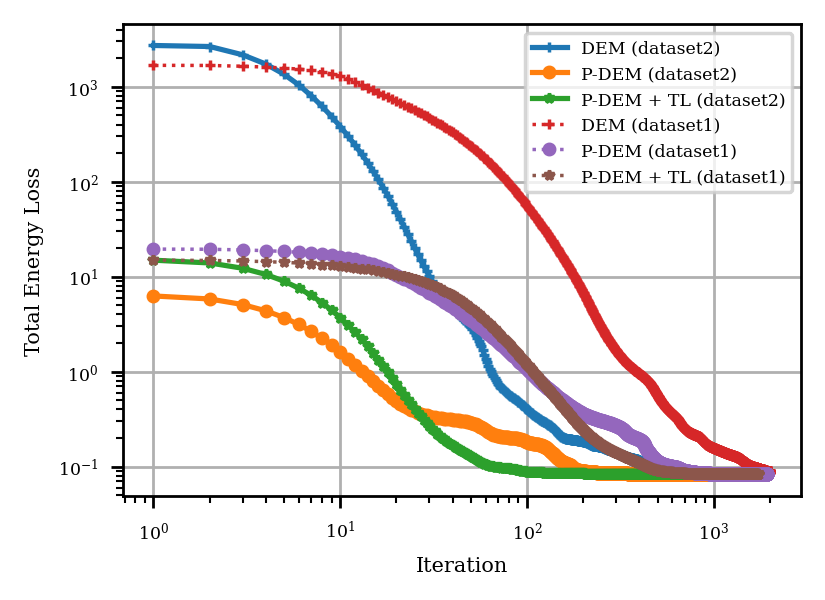

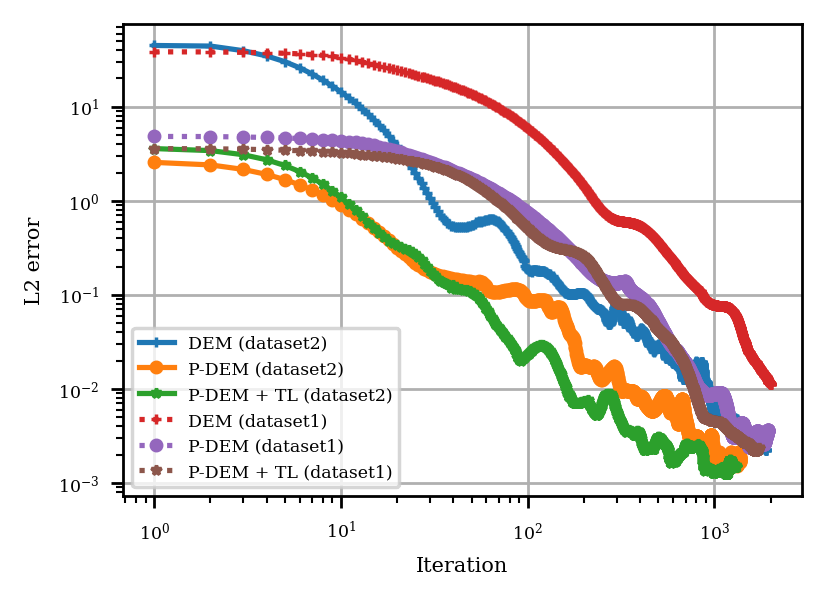

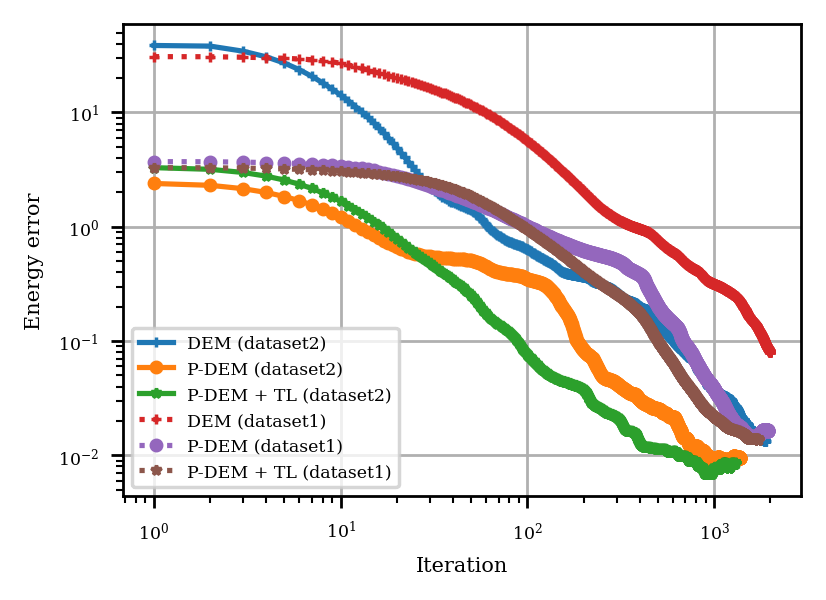

In [18]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PLOT TRAINING LOSS CONVERGENCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
iter_step0 = np.arange(1, len(dem_cylinder.lossArray) + 1)
lossArray0 = np.zeros(len(dem_cylinder.lossArray))
l2errorArray0 = dem_cylinder.l2errorArray
enerrorArray0 = dem_cylinder.enerrorArray


iter_step1 = np.arange(1, len(isodem_cylinder1.lossArray) + 1)
lossArray1 = np.zeros(len(isodem_cylinder1.lossArray))
l2errorArray1 = isodem_cylinder1.l2errorArray
enerrorArray1 = isodem_cylinder1.enerrorArray

iter_step2 = np.arange(1, len(isodem_cylinder2.lossArray) + 1)
lossArray2 = np.zeros(len(isodem_cylinder2.lossArray))
l2errorArray2 = isodem_cylinder2.l2errorArray
enerrorArray2 = isodem_cylinder2.enerrorArray
 # ------------

iter_step02 = np.arange(1, len(dem_cylinder0_2.lossArray) + 1)
lossArray02 = np.zeros(len(dem_cylinder0_2.lossArray))
l2errorArray02 = dem_cylinder0_2.l2errorArray
enerrorArray02 = dem_cylinder0_2.enerrorArray


iter_step12 = np.arange(1, len(isodem_cylinder1_1.lossArray) + 1)
lossArray12 = np.zeros(len(isodem_cylinder1_1.lossArray))
l2errorArray12 = isodem_cylinder1_1.l2errorArray
enerrorArray12 = isodem_cylinder1_1.enerrorArray

iter_step22 = np.arange(1, len(isodem_cylinder2_1.lossArray) + 1)
lossArray22 = np.zeros(len(isodem_cylinder2_1.lossArray))
l2errorArray22 = isodem_cylinder2_1.l2errorArray
enerrorArray22 = isodem_cylinder2_1.enerrorArray
# valLossArray = np.zeros(len(dem.valLossArray))



# PLOTTING LOSS
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5))
# Without transfer learning + dem
i = 0
for loss in dem_cylinder.lossArray:
    lossArray0[i] = loss.data.cpu().numpy()
    i = i + 1
    
# without transfer learning + isodem
i = 0
for loss in isodem_cylinder1.lossArray:
    lossArray1[i] = loss.data.cpu().numpy()
    i = i + 1
    
# With transfer learning + isodem
i = 0
for loss in isodem_cylinder2.lossArray:
    lossArray2[i] = loss.data.cpu().numpy()
    i = i + 1

    
    # --------
# PLOTTING LOSS
# Without transfer learning + dem
i = 0
for loss in dem_cylinder0_2.lossArray:
    lossArray02[i] = loss.data.cpu().numpy()
    i = i + 1
    
# without transfer learning + isodem
i = 0
for loss in isodem_cylinder1_1.lossArray:
    lossArray12[i] = loss.data.cpu().numpy()
    i = i + 1
    
# With transfer learning + isodem
i = 0
for loss in isodem_cylinder2_1.lossArray:
    lossArray22[i] = loss.data.cpu().numpy()
    i = i + 1
    
posValue = 0.88888
t0 = lossArray0[:] + posValue
t1 = lossArray1[:] + posValue
t2 = lossArray2[:] + posValue

t02 = lossArray02[:] + posValue
t12 = lossArray12[:] + posValue
t22 = lossArray22[:] + posValue

loss_plt0, = ax.loglog(iter_step0[:], t0, '-+', label='DEM (dataset2)', linewidth=1.5, markersize=3)
loss_plt1, = ax.loglog(iter_step1[:], t1, '-o', label='P-DEM (dataset2)', linewidth=1.5, markersize=3)
loss_plt2, = ax.loglog(iter_step2[:], t2, '-*', label='P-DEM + TL (dataset2)', linewidth=1.5, markersize=3)

loss_plt02, = ax.loglog(iter_step02[:], t02, ':+', label='DEM (dataset1)', linewidth=1.0, markersize=3)
loss_plt12, = ax.loglog(iter_step12[:], t12, ':o', label='P-DEM (dataset1)', linewidth=1.0, markersize=3)
loss_plt22, = ax.loglog(iter_step22[:], t22, ':*', label='P-DEM + TL (dataset1)', linewidth=1.0, markersize=3)

# plt2,     = plt.semilogx(iter_step, valLossArray, label='L-BFGS', linewidth=2)
ax.legend(handles=[loss_plt0, loss_plt1, loss_plt2, loss_plt02, loss_plt12, loss_plt22])
# ax.legend(handles=[loss_plt0, loss_plt1, loss_plt02, loss_plt12])
ax.grid(True)
ax.set_xlabel('Iteration')
ax.set_ylabel('Total Energy Loss')

fig.savefig(path_save_pic + '/isoparam_lossconvergence_cylinder.eps', format='eps')


# PLOTING L2 enorm
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5))
# Without transfer learning + dem
# i = 0
# for l2error in dem_cylinder.l2errorArray:
#     l2errorArray0[i] = l2error.cpu().numpy()
#     i = i + 1
    
# # without transfer learning + isodem
# i = 0
# for l2error in isodem_cylinder1.l2errorArray:
#     l2errorArray1[i] = l2error.cpu().numpy()
#     i = i + 1
    
# # With transfer learning + isodem
# i = 0
# for l2error in isodem_cylinder2.l2errorArray:
#     l2errorArray2[i] = l2error.cpu().numpy()
#     i = i + 1

l2error_plt0, = ax.loglog(iter_step0[:], l2errorArray0, '-+', label='DEM (dataset2)', linewidth=1.5, markersize=3)
l2error_plt1, = ax.loglog(iter_step1[:], l2errorArray1, '-o', label='P-DEM (dataset2)', linewidth=1.5, markersize=3)
l2error_plt2, = ax.loglog(iter_step2[:], l2errorArray2, '-*', label='P-DEM + TL (dataset2)', linewidth=1.5, markersize=3)

l2error_plt02, = ax.loglog(iter_step02[:], l2errorArray02, ':+', label='DEM (dataset1)', linewidth=1.5, markersize=3)
l2error_plt12, = ax.loglog(iter_step12[:], l2errorArray12, ':o', label='P-DEM (dataset1)', linewidth=1.5, markersize=3)
l2error_plt22, = ax.loglog(iter_step22[:], l2errorArray22, ':*', label='P-DEM + TL (dataset1)', linewidth=1.5, markersize=3)

# plt2,     = plt.semilogx(iter_step, valLossArray, label='L-BFGS', linewidth=2)
ax.legend(handles=[l2error_plt0, l2error_plt1, l2error_plt2, l2error_plt02, l2error_plt12, l2error_plt22])
# ax.legend(handles=[l2error_plt0, l2error_plt1, l2error_plt02, l2error_plt12])
ax.grid(True)
ax.set_xlabel('Iteration')
ax.set_ylabel('L2 error')

fig.savefig(path_save_pic + '/isoparam_l2error_cylinder.eps', format='eps')

# PLOTING Energy enorm
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5))
# Without transfer learning + dem
# i = 0
# for l2error in dem_cylinder.l2errorArray:
#     l2errorArray0[i] = l2error.cpu().numpy()
#     i = i + 1
    
# # without transfer learning + isodem
# i = 0
# for l2error in isodem_cylinder1.l2errorArray:
#     l2errorArray1[i] = l2error.cpu().numpy()
#     i = i + 1
    
# # With transfer learning + isodem
# i = 0
# for l2error in isodem_cylinder2.l2errorArray:
#     l2errorArray2[i] = l2error.cpu().numpy()
#     i = i + 1

eerror_plt0, = ax.loglog(iter_step0[:], enerrorArray0, '-+', label='DEM (dataset2)', linewidth=1.5, markersize=3)
eerror_plt1, = ax.loglog(iter_step1[:], enerrorArray1, '-o', label='P-DEM (dataset2)', linewidth=1.5, markersize=3)
eerror_plt2, = ax.loglog(iter_step2[:], enerrorArray2, '-*', label='P-DEM + TL (dataset2)', linewidth=1.5, markersize=3)

eerror_plt02, = ax.loglog(iter_step02[:], enerrorArray02, ':+', label='DEM (dataset1)', linewidth=1.5, markersize=3)
eerror_plt12, = ax.loglog(iter_step12[:], enerrorArray12, ':o', label='P-DEM (dataset1)', linewidth=1.5, markersize=3)
eerror_plt22, = ax.loglog(iter_step22[:], enerrorArray22, ':*', label='P-DEM + TL (dataset1)', linewidth=1.5, markersize=3)

# plt2,     = plt.semilogx(iter_step, valLossArray, label='L-BFGS', linewidth=2)
ax.legend(handles=[eerror_plt0, eerror_plt1, eerror_plt2, eerror_plt02, eerror_plt12, eerror_plt22])
# ax.legend(handles=[eerror_plt0, eerror_plt1, eerror_plt02, eerror_plt12])
ax.grid(True)
ax.set_xlabel('Iteration')
ax.set_ylabel('Energy error')

fig.savefig(path_save_pic + '/isoparam_enererror_cylinder.eps', format='eps')

plt.show()

In [20]:
def plotDeformedDisp(surfaceUx, surfaceUy, defShapeX, defShapeY, unscaled_factor, exact_solution, num_figures, figure_name):
    if num_figures == 2:
        fig, axes = plt.subplots(1, 3, figsize=(5, 5))
        phi = np.arctan(defShapeY/defShapeX)
        exactUx = np.cos(phi) * exact_solution
        exactUy = np.sin(phi) * exact_solution
        cs2 = axes[0].contourf(defShapeX, defShapeY, np.abs(exactUx - surfaceUx * unscaled_factor), 255, cmap=plt.cm.jet)
        cs3 = axes[1].contourf(defShapeX, defShapeY, np.abs(exactUy - surfaceUy * unscaled_factor), 255, cmap=plt.cm.jet)
        cs4 = axes[2].contourf(defShapeX, defShapeY, np.abs(exact_solution - (np.sqrt(surfaceUx ** 2 + surfaceUy ** 2)) * unscaled_factor), 255, cmap=plt.cm.jet)
        # plot equal colorbars as in
        # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
        cb2 = fig.colorbar(cs2, ax=axes[0], fraction=0.046, pad=0.04)
        cb3 = fig.colorbar(cs3, ax=axes[1], fraction=0.046, pad=0.04)
        cb4 = fig.colorbar(cs4, ax=axes[2], fraction=0.046, pad=0.04)
        cb2.formatter.set_powerlimits((0, 0))
        cb2.update_ticks()
        cb3.formatter.set_powerlimits((0, 0))
        cb3.update_ticks()
        cb4.formatter.set_powerlimits((0, 0))
        cb4.update_ticks()
        fig.tight_layout()
        axes[0].set_title("Point-wise error ${u}_x$")
        axes[1].set_title("Point-wise error ${u}_y$")
        axes[2].set_title("Point-wise error ${u}(r)$")
        axes[0].set_ylabel('$y \,\, [\mu m]$')
        for tax in axes:
          tax.set_xlabel('$x \,\, [\mu m]$')
          tax.set_aspect('equal')
        plt.show()
        fig.savefig(path_save_pic + figure_name + '.eps', format='eps')

    if num_figures == 3:
        fig, axes = plt.subplots(1, 3, figsize=(5, 5))
        cs1 = axes[0].contourf(defShapeX, defShapeY, surfaceUx * unscaled_factor, 255, cmap=plt.cm.jet)
        cs2 = axes[1].contourf(defShapeX, defShapeY, surfaceUy * unscaled_factor, 255, cmap=plt.cm.jet)
        cs3 = axes[2].contourf(defShapeX, defShapeY, np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * unscaled_factor, 255, cmap=plt.cm.jet)
        # plot equal colorbars as in
        # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
        cb1 = fig.colorbar(cs1, ax=axes[0], fraction=0.046, pad=0.04)
        cb2 = fig.colorbar(cs2, ax=axes[1], fraction=0.046, pad=0.04)
        cb3 = fig.colorbar(cs3, ax=axes[2], fraction=0.046, pad=0.04)
        cb1.formatter.set_powerlimits((0, 0))
        cb1.update_ticks()
        cb2.formatter.set_powerlimits((0, 0))
        cb2.update_ticks()
        cb3.formatter.set_powerlimits((0, 0))
        cb3.update_ticks()
        fig.tight_layout()
        axes[0].set_title("Predicted $\hat{u}_x$")
        axes[1].set_title("Predicted $\hat{u}_y$")
        axes[2].set_title("Predicted $\hat{u}(r)$")
        axes[0].set_ylabel('$y \,\, [\mu m]$')
        for tax in axes:
          tax.set_xlabel('$x \,\, [\mu m]$')
          tax.set_aspect('equal')
        plt.show()
        fig.savefig(path_save_pic + figure_name + '.eps', format='eps')
        
            
    if num_figures == 33:
        fig, axes = plt.subplots(1, 3, figsize=(5, 5))
        phi = np.arctan(defShapeY/defShapeX)
        exactUx = np.cos(phi) * exact_solution
        exactUy = np.sin(phi) * exact_solution
        cs1 = axes[0].contourf(defShapeX, defShapeY, exactUx, 255, cmap=plt.cm.jet)
        cs2 = axes[1].contourf(defShapeX, defShapeY, exactUy, 255, cmap=plt.cm.jet)
        cs3 = axes[2].contourf(defShapeX, defShapeY, exact_solution, 255, cmap=plt.cm.jet)
        # plot equal colorbars as in
        # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
        cb1 = fig.colorbar(cs1, ax=axes[0], fraction=0.046, pad=0.04)
        cb2 = fig.colorbar(cs2, ax=axes[1], fraction=0.046, pad=0.04)
        cb3 = fig.colorbar(cs3, ax=axes[2], fraction=0.046, pad=0.04)
        cb1.formatter.set_powerlimits((0, 0))
        cb1.update_ticks()
        cb2.formatter.set_powerlimits((0, 0))
        cb2.update_ticks()
        cb3.formatter.set_powerlimits((0, 0))
        cb3.update_ticks()
        fig.tight_layout()
        axes[0].set_title("Exact $u_x$")
        axes[1].set_title("Exact $u_y$")
        axes[2].set_title("Exact $u(r)$")
        axes[0].set_ylabel('$y \,\, [\mu m]$')
        for tax in axes:
          tax.set_xlabel('$x \,\, [\mu m]$')
          tax.set_aspect('equal')
        plt.show()
        fig.savefig(path_save_pic + figure_name + '.eps', format='eps')
        
        
    if num_figures == 31:
        fig, axes = plt.subplots(1, 3, figsize=(5, 5))
        cs1 = axes[0].contourf(defShapeX, defShapeY, surfaceUx * unscaled_factor, 255, cmap=plt.cm.jet)
        cs2 = axes[1].contourf(defShapeX, defShapeY, surfaceUy * unscaled_factor, 255, cmap=plt.cm.jet)
        cs3 = axes[2].contourf(defShapeX, defShapeY, np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * unscaled_factor, 255, cmap=plt.cm.jet)
        # plot equal colorbars as in
        # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
        cb1 = fig.colorbar(cs1, ax=axes[0], fraction=0.046, pad=0.04)
        cb2 = fig.colorbar(cs2, ax=axes[1], fraction=0.046, pad=0.04)
        cb3 = fig.colorbar(cs3, ax=axes[2], fraction=0.046, pad=0.04)
        cb1.formatter.set_powerlimits((0, 0))
        cb1.update_ticks()
        cb2.formatter.set_powerlimits((0, 0))
        cb2.update_ticks()
        cb3.formatter.set_powerlimits((0, 0))
        cb3.update_ticks()
        fig.tight_layout()
        axes[0].set_title("Predicted $\hat{u}_x$")
        axes[1].set_title("Predicted $\hat{u}_y$")
        axes[2].set_title("Predicted $\hat{u}(r)$")
        axes[0].set_ylabel(r"$\xi_2 \,\, [\mu m]$")
        for tax in axes: 
          tax.set_xlabel(r"$\xi_1 \,\, [\mu m]$")
          tax.set_aspect('equal')
        plt.show()
        fig.savefig(path_save_pic + figure_name + '.eps', format='eps')
    if num_figures == 5:
        fig, axes = plt.subplots(1, 5, figsize=(5, 5))
        cs1 = axes[0].contourf(defShapeX, defShapeY, surfaceUx * unscaled_factor, 255, cmap=plt.cm.jet)
        cs2 = axes[1].contourf(defShapeX, defShapeY, surfaceUy * unscaled_factor, 255, cmap=plt.cm.jet)
        cs3 = axes[2].contourf(defShapeX, defShapeY, np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * unscaled_factor, 255, cmap=plt.cm.jet)
        cs4 = axes[3].contourf(defShapeX, defShapeY, np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * unscaled_factor, 255, cmap=plt.cm.jet)
        cs5 = axes[4].contourf(defShapeX, defShapeY, np.abs(exact_solution - (np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * unscaled_factor)), 255, cmap=plt.cm.jet)
        # plot equal colorbars as in
        # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
        cb1 = fig.colorbar(cs1, ax=axes[0], fraction=0.046, pad=0.04)
        cb2 = fig.colorbar(cs2, ax=axes[1], fraction=0.046, pad=0.04)
        cb3 = fig.colorbar(cs3, ax=axes[2], fraction=0.046, pad=0.04)
        cb4 = fig.colorbar(cs4, ax=axes[3], fraction=0.046, pad=0.04)
        cb5 = fig.colorbar(cs5, ax=axes[4], fraction=0.046, pad=0.04)
        cb1.formatter.set_powerlimits((0, 0))
        cb1.update_ticks()
        cb2.formatter.set_powerlimits((0, 0))
        cb2.update_ticks()
        cb3.formatter.set_powerlimits((0, 0))
        cb3.update_ticks()
        cb4.formatter.set_powerlimits((0, 0))
        cb4.update_ticks()
        cb5.formatter.set_powerlimits((0, 0))
        cb5.update_ticks()
        fig.tight_layout()
        
        axes[0].set_title("Predicted $\hat{u}_x$")
        axes[1].set_title("Predicted $\hat{u}_y$")
        axes[2].set_title("Predicted $\hat{u}(r)$")
        axes[0].set_ylabel('$y \,\, [\mu m]$')
        for tax in axes:
            tax.set_xlabel('$x \,\, [\mu m]$')
            tax.set_aspect('equal')

    
        axes[3].set_title("Predicted \hat{u}(r)")
        axes[4].set_title("Point-wise Error")
        axes[3].set_ylabel('$y \,\, [\mu m]$')

#         fig, axes = plt.subplots(1, 3, figsize=(5, 5))
        

#         cb1.formatter.set_powerlimits((0, 0))
#         cb1.update_ticks()
#         cb2.formatter.set_powerlimits((0, 0))
#         cb2.update_ticks()
#         cb3.formatter.set_powerlimits((0, 0))
#         cb3.update_ticks()
#         fig.tight_layout()

            
        plt.show()
#         fig.savefig(path_save_pic + figure_name + '.eps', format='eps')

In [21]:
def setup_domain(problem_param, NPhi, NR):
#     NPhi = 120
#     NR = 120
    radiusIn = problem_param['radInt']
    radiusOut = problem_param['radExt']
    pi = problem_param['Pi']
    po = problem_param['Po']
    minPhi, maxPhi = (0, np.pi/2)
    # mesh
    dR = np.linspace(radiusIn, radiusOut, NR)
    dPhi = np.arange(0, NPhi)/(NPhi-1) * maxPhi
    R_grid, Phi_grid = np.meshgrid(dR, dPhi)
    R1D = np.array([R_grid.flatten()]).T
    Phi1D = np.array([Phi_grid.flatten()]).T
    cylCoord = np.concatenate((R1D, Phi1D), axis=1)
    X = R1D * np.cos(Phi1D)
    Y = R1D * np.sin(Phi1D)
    coordinates = np.concatenate((X, Y), axis=1)
    # left boundary
    left_idx = np.where(np.abs(cylCoord[:, 1] - maxPhi) < 1e-12)[0]
    left_points = coordinates[left_idx, :]
    left_points[:, 0] = 0.0
    # bottom boundary
    bottom_idx = np.where(np.abs(cylCoord[:, 1] - minPhi) < 1e-12)[0]
    bottom_points = coordinates[bottom_idx, :]
    bottom_points[:, 1] = 0.0
    # inner boundary
    inner_idx = np.where(np.abs(cylCoord[:, 0] - radiusIn) < 1e-12)[0]
    inner_points = coordinates[inner_idx, :]
    pi_x = pi * np.cos(np.arctan(inner_points[:, 1:2] / inner_points[:, 0:1]))
    pi_y = pi * np.sin(np.arctan(inner_points[:, 1:2] / inner_points[:, 0:1]))
    inner_t = np.concatenate((pi_x, pi_y), axis=1)
    # outer boundary
    outer_idx = np.where(np.abs(cylCoord[:, 0] - radiusOut) < 1e-12)[0]
    outer_points = coordinates[outer_idx, :]
    po_x = -po * np.cos(np.arctan(outer_points[:, 1:2] / outer_points[:, 0:1]))
    po_y = -po * np.sin(np.arctan(outer_points[:, 1:2] / outer_points[:, 0:1]))
    outer_t = np.concatenate((po_x, po_y), axis=1)
    # drawing
    # fig = plt.figure(figsize=(3, 2))
    # ax = fig.add_subplot(111)
    # ax.scatter(coordinates[:, 0], coordinates[:, 1], s=0.05, facecolor='blue')
    # ax.scatter(left_points[:, 0], left_points[:, 1], s=0.5, facecolor='green')
    # ax.scatter(bottom_points[:, 0], bottom_points[:, 1], s=0.5, facecolor='red')
    # ax.scatter(inner_points[:, 0], inner_points[:, 1], s=0.5, facecolor='yellow')
    # ax.scatter(outer_points[:, 0], outer_points[:, 1], s=0.5, facecolor='black')
    # # ax.set(xlim=(centerX - 0.5*1e-6, centerX + radiusOut + 0.5*1e-6), ylim=(centerY - 0.5*1e-6, centerY + radiusOut + 0.5*1e-6))
    # ax.set_aspect('equal')
    # ax.set_xlabel('X', fontsize=3)
    # ax.set_ylabel('Y', fontsize=3)
    # ax.tick_params(labelsize=4)
    # plt.show()
    # exit()
    return coordinates, inner_points, outer_points, inner_t, outer_t

/home/minh/anaconda2/envs/dem/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/minh/anaconda2/envs/dem/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


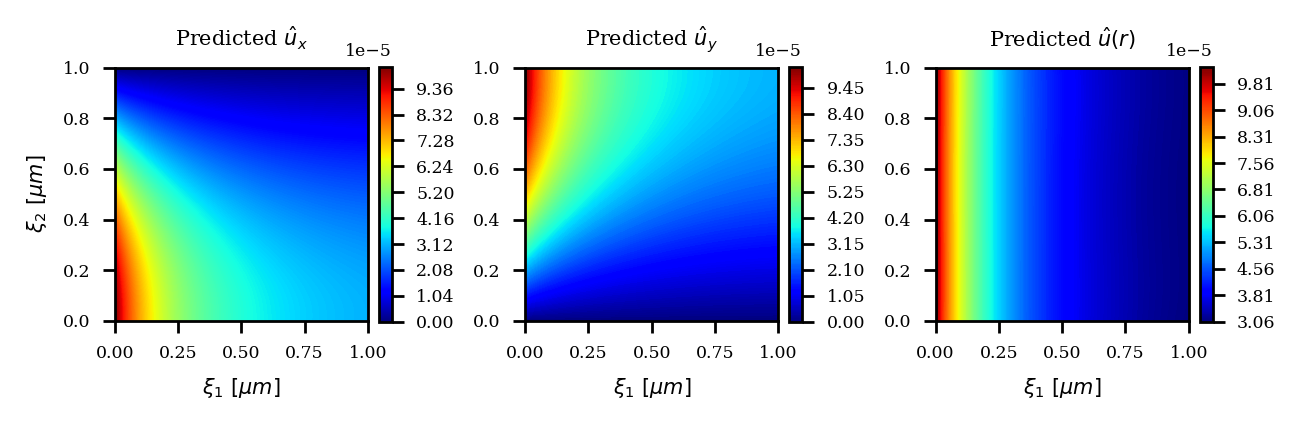

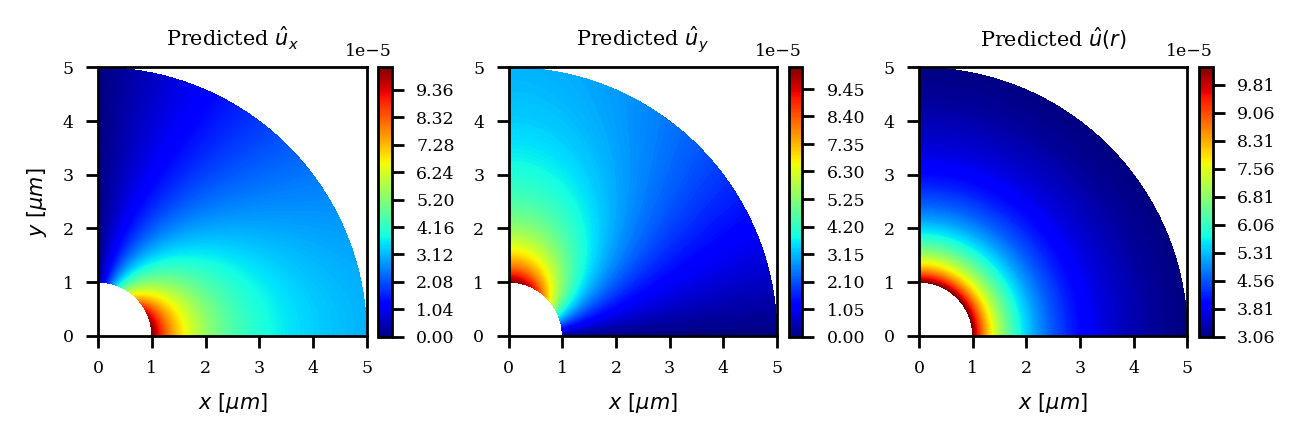

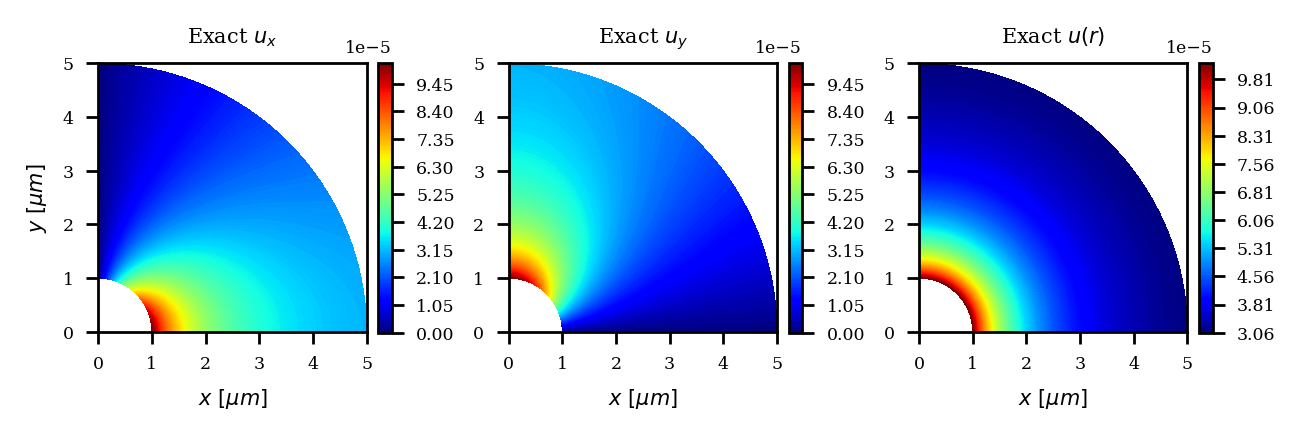

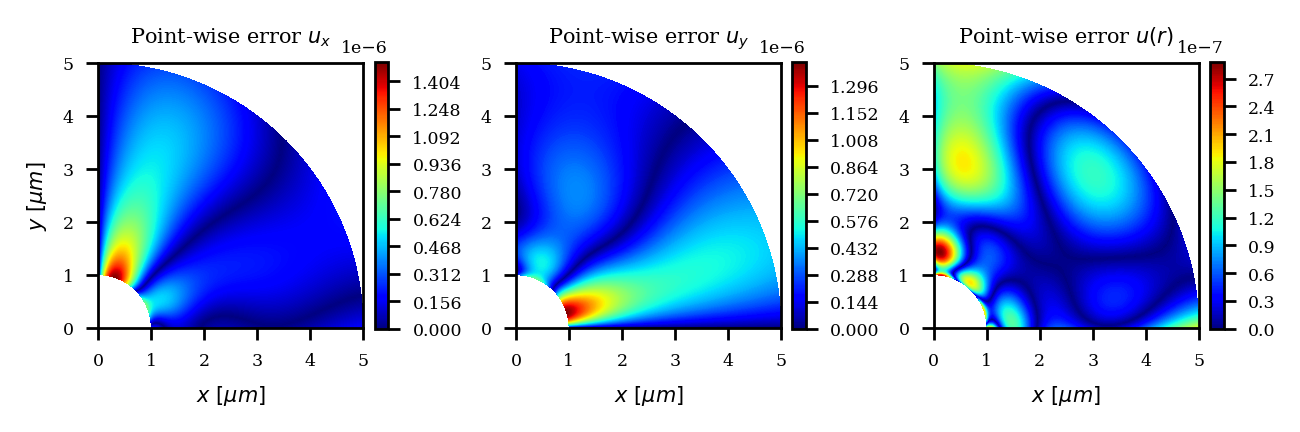

Relative L2 error:  0.0014667309770975913


In [22]:
realscale = problem_param['scale_factor'] # makes the result less sensitive w.r.t the small scale. Results will be given after unscaling.
# TURN OFF DROPOUT - TURN ON EVAL MODE

isodem_cylinder1.model.eval()

NPhi=121
NR=121
avr = int(((NPhi * NR) - NR) / 2)
XYdata, _, _, _, _ = setup_domain(problem_param, NPhi, NR)

xi1 = np.linspace(0, 1, NPhi)
xi2 = np.linspace(0, 1, NR)
xi1Grid, xi2Grid = np.meshgrid(xi1, xi2)
xiData = np.concatenate((xi1Grid.reshape(xi1Grid.shape[0] * xi1Grid.shape[1], -1), 
                xi2Grid.reshape(xi2Grid.shape[0] * xi2Grid.shape[1], -1)), axis=1)

# NPhi = numElemU
# NR = numElemU
# data = model_data['xi']

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PLOT IN REFERENCE DOMAIN %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
XY_xi = xiData

xi_tensor = torch.from_numpy(xiData).float()
xi_tensor = xi_tensor.to(dev)
xi_tensor.requires_grad_(True)
# u_pred_torch = dem.model(xy_tensor)
u_pred_torch = isodem_cylinder1.getU(xi_tensor)
u_pred = u_pred_torch.detach().cpu().numpy()


x_fac = 1
y_fac = 1

oShapeX_xi = np.resize(XY_xi[:, 0], [NPhi, NR])
oShapeY_xi = np.resize(XY_xi[:, 1], [NPhi, NR])
surfaceUx_xi = np.resize(u_pred[:, 0], [NPhi, NR])
surfaceUy_xi = np.resize(u_pred[:, 1], [NPhi, NR])

defShapeX_xi = oShapeX_xi * x_fac
defShapeY_xi = oShapeY_xi * y_fac

radius = np.sqrt(oShapeX_xi**2 + oShapeY_xi**2)
# A, B, C, D = get_coeff_of_exact_solution(model)
# exact_ur = exact_solution(A, B, C, D, model['lengthscale'], np.sqrt(oShapeX**2 + oShapeY**2)) * realscale
exact_ur = u_exact_cylinder(problem_param['Pi'], problem_param['E'], problem_param['nu'], problem_param['radExt'], problem_param['radInt'], radius) * realscale

plotDeformedDisp(surfaceUx_xi, surfaceUy_xi, defShapeX_xi, defShapeY_xi, realscale, exact_ur, num_figures=31, figure_name="thickwall_ux_uy_ur_referencedomain")

# plotDeformedDisp(surfaceUx, surfaceUy, defShapeX, defShapeY, realscale, exact_ur, num_figures=2)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PLOT IN PHYSICAL DOMAIN %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
XY = XYdata

xi_tensor = torch.from_numpy(xiData).float()
xi_tensor = xi_tensor.to(dev)
xi_tensor.requires_grad_(True)
# u_pred_torch = dem.model(xy_tensor)
u_pred_torch = isodem_cylinder1.getU(xi_tensor)
u_pred = u_pred_torch.detach().cpu().numpy()


x_fac = 1
y_fac = 1

oShapeX = np.resize(XY[:, 0], [NPhi, NR])
oShapeY = np.resize(XY[:, 1], [NPhi, NR])
surfaceUx = np.resize(u_pred[:, 0], [NPhi, NR])
surfaceUy = np.resize(u_pred[:, 1], [NPhi, NR])

defShapeX = oShapeX * x_fac
defShapeY = oShapeY * y_fac

radius = np.sqrt(oShapeX**2 + oShapeY**2)
# A, B, C, D = get_coeff_of_exact_solution(model)
# exact_ur = exact_solution(A, B, C, D, model['lengthscale'], np.sqrt(oShapeX**2 + oShapeY**2)) * realscale

exact_ur = u_exact_cylinder(problem_param['Pi'], problem_param['E'], problem_param['nu'], problem_param['radExt'], problem_param['radInt'], radius) * realscale

plotDeformedDisp(surfaceUx, surfaceUy, defShapeX, defShapeY, realscale, exact_ur, num_figures=3, figure_name="thickwall_ux_uy_ur_physicaldomain")

plotDeformedDisp(surfaceUx, surfaceUy, defShapeX, defShapeY, realscale, exact_ur, num_figures=33, figure_name="thickwall_exact_solutons")

plotDeformedDisp(surfaceUx, surfaceUy, defShapeX, defShapeY, realscale, exact_ur, num_figures=2, figure_name="thickwall_compare_with_exact_ur")

pred_ur = np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * realscale
# err_norm = exact_ur - pred_ur
# error_u = np.sqrt((err_norm**2).sum()/(exact_ur**2).sum())
# print("Relative L2 error: ", error_u)
print("Relative L2 error: ", np.linalg.norm((pred_ur - exact_ur), 2)/np.linalg.norm(exact_ur, 2))

Relative L2 error:  0.003422328268125591


/home/minh/anaconda2/envs/dem/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/minh/anaconda2/envs/dem/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


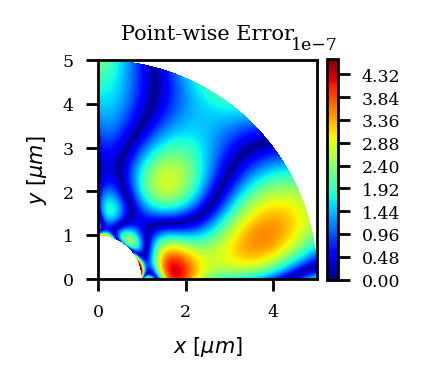

Relative L2 error:  0.001642374484621757


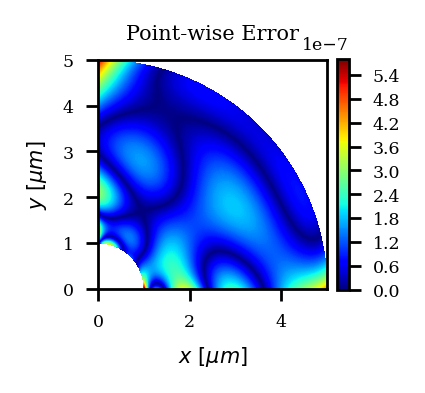

Relative L2 error:  0.0014667309770975913


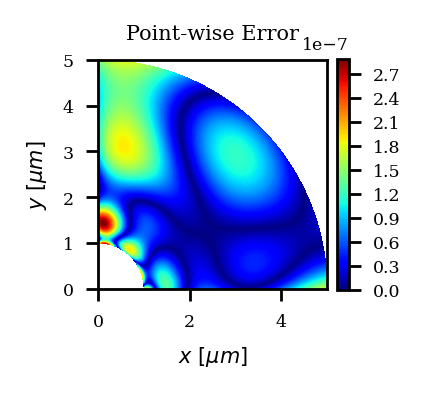

Relative L2 error:  0.0013213111578375305


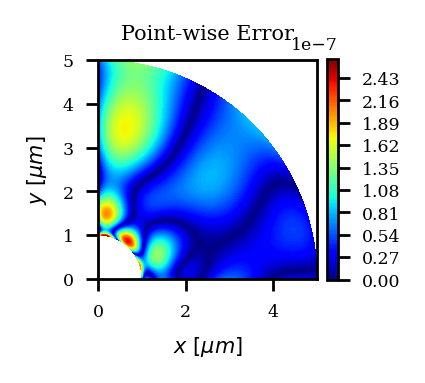

Relative L2 error:  0.008541837932800635


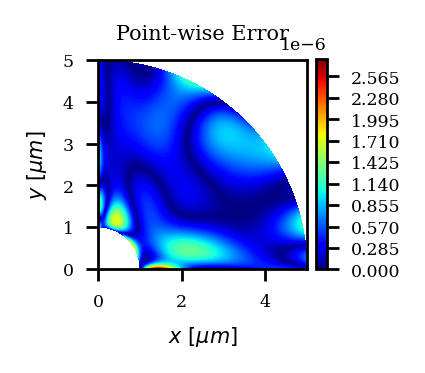

Relative L2 error:  0.0015925708394280357


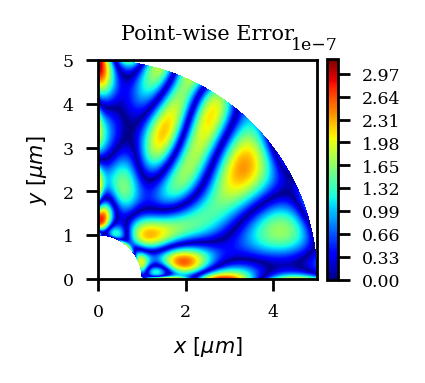

In [23]:
isodem_cylinder_array = [isodem_cylinder1_1, isodem_cylinder2_1, isodem_cylinder1, isodem_cylinder2]
                        #[isodem-noTL-dataset1, #isodem-TL-dataset1, #isodem-noTL-dataset2, #isodem-TL-dataset2]

for i in [0,1,2,3]:
    isodem_cylinder = isodem_cylinder_array[i]
    isodem_cylinder.model.eval()
    realscale = problem_param['scale_factor'] # makes the result less sensitive w.r.t the small scale. Results will be given after unscaling.
    # TURN OFF DROPOUT - TURN ON EVAL MODE
    NPhi=121
    NR=121
    avr = int(((NPhi * NR) - NR) / 2)
    XYdata, _, _, _, _ = setup_domain(problem_param, NPhi, NR)

    xi1 = np.linspace(0, 1, NPhi)
    xi2 = np.linspace(0, 1, NR)
    xi1Grid, xi2Grid = np.meshgrid(xi1, xi2)
    xiData = np.concatenate((xi1Grid.reshape(xi1Grid.shape[0] * xi1Grid.shape[1], -1), 
                    xi2Grid.reshape(xi2Grid.shape[0] * xi2Grid.shape[1], -1)), axis=1)

    # NPhi = numElemU
    # NR = numElemU
    # data = model_data['xi']

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PLOT IN REFERENCE DOMAIN %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    XY_xi = xiData

    xi_tensor = torch.from_numpy(xiData).float()
    xi_tensor = xi_tensor.to(dev)
    xi_tensor.requires_grad_(True)
    # u_pred_torch = dem.model(xy_tensor)
    u_pred_torch = isodem_cylinder.getU(xi_tensor)
    u_pred = u_pred_torch.detach().cpu().numpy()


    x_fac = 1
    y_fac = 1

    oShapeX_xi = np.resize(XY_xi[:, 0], [NPhi, NR])
    oShapeY_xi = np.resize(XY_xi[:, 1], [NPhi, NR])
    surfaceUx_xi = np.resize(u_pred[:, 0], [NPhi, NR])
    surfaceUy_xi = np.resize(u_pred[:, 1], [NPhi, NR])

    defShapeX_xi = oShapeX_xi * x_fac
    defShapeY_xi = oShapeY_xi * y_fac

    radius = np.sqrt(oShapeX_xi**2 + oShapeY_xi**2)
    # A, B, C, D = get_coeff_of_exact_solution(model)
    # exact_ur = exact_solution(A, B, C, D, model['lengthscale'], np.sqrt(oShapeX**2 + oShapeY**2)) * realscale
    exact_ur = u_exact_cylinder(problem_param['Pi'], problem_param['E'], problem_param['nu'], problem_param['radExt'], problem_param['radInt'], radius) * realscale

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PLOT IN PHYSICAL DOMAIN %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    XY = XYdata

    xi_tensor = torch.from_numpy(xiData).float()
    xi_tensor = xi_tensor.to(dev)
    xi_tensor.requires_grad_(True)
    # u_pred_torch = dem.model(xy_tensor)
    u_pred_torch = isodem_cylinder.getU(xi_tensor)
    u_pred = u_pred_torch.detach().cpu().numpy()
    x_fac = 1
    y_fac = 1
    oShapeX = np.resize(XY[:, 0], [NPhi, NR])
    oShapeY = np.resize(XY[:, 1], [NPhi, NR])
    surfaceUx = np.resize(u_pred[:, 0], [NPhi, NR])
    surfaceUy = np.resize(u_pred[:, 1], [NPhi, NR])
    defShapeX = oShapeX * x_fac
    defShapeY = oShapeY * y_fac
    radius = np.sqrt(oShapeX**2 + oShapeY**2)
    exact_ur = u_exact_cylinder(problem_param['Pi'], problem_param['E'], problem_param['nu'], problem_param['radExt'], problem_param['radInt'], radius) * realscale
    pred_ur = np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * realscale
    print("Relative L2 error: ", np.linalg.norm((pred_ur - exact_ur), 2)/np.linalg.norm(exact_ur, 2))
    # ------------------------------------------------
    # ------------------------------------------------
    fig, axes = plt.subplots(1, 1, figsize=(1.5, 1.5))
    unscaled_factor = realscale
    exact_solution = exact_ur
    cs = axes.contourf(defShapeX, defShapeY, np.abs(exact_solution - (np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * unscaled_factor)), 255, cmap=plt.cm.jet)
    # plot equal colorbars as in
    # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph

    cb = fig.colorbar(cs, ax=axes, fraction=0.046, pad=0.04)

    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    fig.tight_layout()

    axes.set_title("Point-wise Error")
        
    
    axes.set_xlabel("$x \,\, [\mu m]$")
    axes.set_ylabel("$y \,\, [\mu m]$")
    axes.set_aspect('equal')


    #         axes[3].set_ylabel('$y \,\, [\mu m]$')
    plt.show()
    
    
# DEM
dem_cylinder_array = [dem_cylinder0_2, dem_cylinder]
for i in range(2):
    dem_cylinder = dem_cylinder_array[i]
    dem_cylinder.model.eval()
    realscale = problem_param['scale_factor'] # makes the result less sensitive w.r.t the small scale. Results will be given after unscaling.
    # TURN OFF DROPOUT - TURN ON EVAL MODE
    NPhi=121
    NR=121
    avr = int(((NPhi * NR) - NR) / 2)
    XYdata, _, _, _, _ = setup_domain(problem_param, NPhi, NR)

    # NPhi = numElemU
    # NR = numElemU
    # data = model_data['xi']

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PLOT IN PHYSICAL DOMAIN %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    XY = XYdata
    XY_tensor = torch.from_numpy(XY).float()
    XY_tensor = XY_tensor.to(dev)
    XY_tensor.requires_grad_(True)
    # u_pred_torch = dem.model(xy_tensor)
    u_pred_torch = dem_cylinder.getU(XY_tensor)
    u_pred = u_pred_torch.detach().cpu().numpy()
    x_fac = 1
    y_fac = 1
    oShapeX = np.resize(XY[:, 0], [NPhi, NR])
    oShapeY = np.resize(XY[:, 1], [NPhi, NR])
    surfaceUx = np.resize(u_pred[:, 0], [NPhi, NR])
    surfaceUy = np.resize(u_pred[:, 1], [NPhi, NR])
    defShapeX = oShapeX * x_fac
    defShapeY = oShapeY * y_fac
    radius = np.sqrt(oShapeX**2 + oShapeY**2)
    exact_ur = u_exact_cylinder(problem_param['Pi'], problem_param['E'], problem_param['nu'], problem_param['radExt'], problem_param['radInt'], radius) * realscale
    pred_ur = np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * realscale
    print("Relative L2 error: ", np.linalg.norm((pred_ur - exact_ur), 2)/np.linalg.norm(exact_ur, 2))
    # ------------------------------------------------
    # ------------------------------------------------
    fig, axes = plt.subplots(1, 1, figsize=(1.5, 1.5))
    unscaled_factor = realscale
    exact_solution = exact_ur
    cs = axes.contourf(defShapeX, defShapeY, np.abs(exact_solution - (np.sqrt(surfaceUx ** 2 + surfaceUy ** 2) * unscaled_factor)), 255, cmap=plt.cm.jet)
    # plot equal colorbars as in
    # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph

    cb = fig.colorbar(cs, ax=axes, fraction=0.046, pad=0.04)

    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    fig.tight_layout()

    axes.set_title("Point-wise Error")
        
    
    axes.set_xlabel("$x \,\, [\mu m]$")
    axes.set_ylabel("$y \,\, [\mu m]$")
    axes.set_aspect('equal')


    #         axes[3].set_ylabel('$y \,\, [\mu m]$')
    plt.show()

## Calculate L2 error norm & Energy error norm

Relative L2 error (integration):  0.004260215130808811
Relative energy error (integration):  0.016827416098426373
Relative L2 error (integration):  0.002584422785591125
Relative energy error (integration):  0.01378642570496739
Relative L2 error (integration):  0.0018727239259082506
Relative energy error (integration):  0.00940638706611172
Relative L2 error (integration):  0.0016615000904328652
Relative energy error (integration):  0.008630194480588979
Relative L2 error (integration):  0.011732783893498466
Relative energy error (integration):  0.08031535139199349
Relative L2 error (integration):  0.0026360983719188433
Relative energy error (integration):  0.01333759277297982


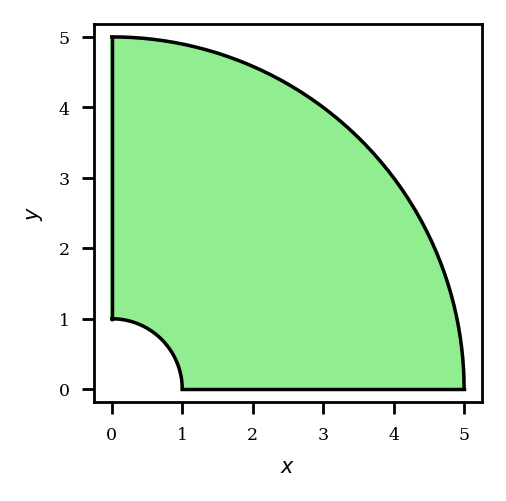

In [24]:
numElemU = 80
numElemV = 80
numGauss = 1
# Generate the boundary points using Geometry class
numElemEdge = 80
numGaussEdge = 1

# Generating points inside the domain using GeometryIGA
myAnnulus = AnnulusISO(problem_param['radInt'], problem_param['radExt'])

xyw_domain, xyw_inner, t_inner, xyw_outer, t_outer, xyw_left, xyw_right, xi_domain, dxidx_domain, xi_inner, xi_outer, xi_left, xi_right = \
gen_data_isodem_cylinder(problem_param, myAnnulus, numElemU, numElemV, numGauss, numElemEdge, numGaussEdge)

model_data['xy'] = xyw_domain

model_data['xi'] = xi_domain
XY_tensor = torch.from_numpy(xyw_domain[:, 0:2]).float()
XY_tensor = XY_tensor.to(dev)
XY_tensor.requires_grad_(True)

xi_tensor = torch.from_numpy(xi_domain[:, 0:2]).float()
xi_tensor = xi_tensor.to(dev)
xi_tensor.requires_grad_(True)

model_data['dxidx'] = dxidx_domain
dxidx_tensor = torch.from_numpy(dxidx_domain[:, 0:4]).float()
dxidx_tensor = dxidx_tensor.to(dev)
dxidx_tensor.requires_grad_(True)

# P-DEM
isodem_cylinder_array = [isodem_cylinder1_1, isodem_cylinder2_1, isodem_cylinder1, isodem_cylinder2]
for i in range(4):
    isodem_cylinder = isodem_cylinder_array[i]
    u_pred_torch = isodem_cylinder.getU(xi_tensor)
    # print(u_pred_torch)
    uv_pred = u_pred_torch.detach().cpu().numpy()

    radius = np.sqrt(xyw_domain[:, 0:1]**2 + xyw_domain[:, 1:2]**2)
    exact_ur = u_exact_cylinder(problem_param['Pi'], problem_param['E'], problem_param['nu'], problem_param['radExt'], problem_param['radInt'], radius) * realscale
    ur_pred = np.sqrt(uv_pred[:, 0:1]**2 + uv_pred[:, 1:2]**2) * realscale
    err_l2 = np.sum((exact_ur-ur_pred)**2*xyw_domain[:,2:3])
    norm_l2 = np.sum((exact_ur**2)*xyw_domain[:,2:3])
    error_u_l2 = np.sqrt(err_l2/norm_l2)
    print("Relative L2 error (integration): ", error_u_l2)

    strain_energy, sigma_pred, eps_pred = isodem_cylinder.energy.linear_elasticity(u_pred_torch, xi_tensor, dxidx_tensor)
    sigma_nn = sigma_pred.detach().cpu().numpy()
    eps_nn = eps_pred.detach().cpu().numpy()
    sigma_exact = sigma_exact_cylinder(xyw_domain[:, 0:1], xyw_domain[:, 1:2], problem_param)
    eps_exact = eps_exact_cylinder(isodem_cylinder.energy.mu, isodem_cylinder.energy.lam, sigma_exact)
    energy_norm_nu = 0.5 * np.matmul(np.reshape((eps_exact - eps_nn), (len(xyw_domain), 1, 3)), np.reshape((sigma_exact - sigma_nn), (len(xyw_domain), 3, 1 )))
    energy_norm_de = 0.5 * np.matmul(np.reshape(eps_exact, (len(xyw_domain), 1, 3)), np.reshape(sigma_exact, (len(xyw_domain), 3, 1 )))
    e_error = np.sqrt(np.sum(energy_norm_nu * xyw_domain[:, 2:3]) / np.sum(energy_norm_de * xyw_domain[:, 2:3]))
    print("Relative energy error (integration): ", e_error)           
    
# DEM
dem_cylinder_array = [dem_cylinder0_2, dem_cylinder]
for i in range(2):
    isodem_cylinder = dem_cylinder_array[i]
    u_pred_torch = isodem_cylinder.getU(XY_tensor)
    # print(u_pred_torch)
    uv_pred = u_pred_torch.detach().cpu().numpy()

    radius = np.sqrt(xyw_domain[:, 0:1]**2 + xyw_domain[:, 1:2]**2)
    exact_ur = u_exact_cylinder(problem_param['Pi'], problem_param['E'], problem_param['nu'], problem_param['radExt'], problem_param['radInt'], radius) * realscale
    ur_pred = np.sqrt(uv_pred[:, 0:1]**2 + uv_pred[:, 1:2]**2) * realscale
    err_l2 = np.sum((exact_ur-ur_pred)**2*xyw_domain[:,2:3])
    norm_l2 = np.sum((exact_ur**2)*xyw_domain[:,2:3])
    error_u_l2 = np.sqrt(err_l2/norm_l2)
    print("Relative L2 error (integration): ", error_u_l2)

    strain_energy, sigma_pred, eps_pred = isodem_cylinder.energy.linear_elasticity(u_pred_torch, XY_tensor)
    sigma_nn = sigma_pred.detach().cpu().numpy()
    eps_nn = eps_pred.detach().cpu().numpy()
    sigma_exact = sigma_exact_cylinder(xyw_domain[:, 0:1], xyw_domain[:, 1:2], problem_param)
    eps_exact = eps_exact_cylinder(isodem_cylinder.energy.mu, isodem_cylinder.energy.lam, sigma_exact)
    energy_norm_nu = 0.5 * np.matmul(np.reshape((eps_exact - eps_nn), (len(xyw_domain), 1, 3)), np.reshape((sigma_exact - sigma_nn), (len(xyw_domain), 3, 1 )))
    energy_norm_de = 0.5 * np.matmul(np.reshape(eps_exact, (len(xyw_domain), 1, 3)), np.reshape(sigma_exact, (len(xyw_domain), 3, 1 )))
    e_error = np.sqrt(np.sum(energy_norm_nu * xyw_domain[:, 2:3]) / np.sum(energy_norm_de * xyw_domain[:, 2:3]))
    print("Relative energy error (integration): ", e_error)           


### Save network parameters (2nd)

In [31]:
torch.save(isodem_cylinder2.model.state_dict(), 'isodem_elasticity_annulus2d.pth')